<a href="https://colab.research.google.com/github/Samir-atra/BDSD_Minor_Project/blob/main/MediaPipe_Stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download and install packages for colab
# !python -m pip install mediapipe
# !wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
# !wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

# Imports
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pathlib
# from google.colab.patches import cv2_imshow
import csv
import pandas as pd
import tensorflow as tf
import keras_tuner
import math
import time
import os

2024-05-21 00:55:34.892970: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 00:55:35.039660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 00:55:35.039770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 00:55:35.066184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 00:55:35.130821: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


In [2]:
# MediaPipe visualizations


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()


In [3]:
# a function to write dta into csv files
def csv_writer(filename, fields, data):

    csvfile = filename
    fields = fields
    with open(csvfile, mode="a") as first:
        csvwriter = csv.writer(first)
        csvwriter.writerow(fields)
        csvwriter.writerows(data)

        return True

In [4]:
# download and upload images from and into colab

# download
# img = cv2.imread("images.jpg")
# cv2_imshow(img)

# # upload images to colab
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

In [5]:
#inferencing and visualizing

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)
# print(detection_result.facial_transformation_matrixes)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)


libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

I0000 00:00:1716245737.500568   23790 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
W0000 00:00:1716245737.506763   23790 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
libEGL 

In [6]:
# plot bar graphs for specific image blendshapes

# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
# print(detection_result.face_blendshapes[0])

In [12]:
# dataset analysis/calculations       (styled)

# categories_counts = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0}
# skipped = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0}


# with open("fer2013.csv", mode= "r") as data:                    # open the dataset file
#   csvFile = csv.reader(data)
#   next(csvFile)
#   for lines in csvFile:                                         # loop throught the training instances
#     if lines[0] in categories_counts.keys():
#       categories_counts[lines[0]] = categories_counts[lines[0]] + 1
#     image = np.array(str(lines[1]).split(' ')).reshape(48, 48, 1).astype(np.uint8)     # build the image from a list of numbers
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
#     detection_result = detector.detect(rgb_frame)                                       # detect the face in the image
#     # check if the image get recognized or skipped by mediapipe
#     if detection_result.face_blendshapes == []:                                         # check if mediapipe is able to detect a face in the image
#         skipped[lines[0]] = skipped[lines[0]] + 1
#     else:
#         img = plt.imshow(image)
#         plt.show()
#         continue

{'0': 738, '1': 90, '2': 751, '3': 467, '4': 1063, '5': 311, '6': 334}
{'0': 4953, '1': 547, '2': 5121, '3': 8989, '4': 6077, '5': 4002, '6': 6198}


In [16]:
# # Processing, cleaning and visualizing the fer2023 dataset    (styled)

fullset = []
Training_set = []
validation_set = []
test_set = []
class_counter = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0}


with open("training_set_full.csv", mode= "r") as data:
  csvFile = csv.reader(data)
  next(csvFile)
  # iterate over the dataset and append the images to a list, for limited numbers according to it's classes, to creat the training set
  for lines in csvFile:
      if lines[0] == "0" and class_counter['0'] < 150000:
        class_counter[lines[0]] = class_counter[lines[0]] + 1
        lines[0] = '1'
        fullset.append(lines)
      elif lines[0] == "1" and class_counter['1'] < 150000:
        class_counter[lines[0]] = class_counter[lines[0]] + 1
        lines[0] = '1'
        fullset.append(lines)
      elif lines[0] == '2' and class_counter['2'] < 150000:
        class_counter[lines[0]] = class_counter[lines[0]] + 1
        lines[0] = '1'
        fullset.append(lines) 
      elif lines[0] == '3' and class_counter['3'] < 4000:
        class_counter[lines[0]] = class_counter[lines[0]] + 1
        lines[0] = '0'
        fullset.append(lines) 
      elif lines[0] == '4' and class_counter['4'] < 4000:
        class_counter[lines[0]] = class_counter[lines[0]] + 1
        lines[0] = '2'
        fullset.append(lines) 
      elif lines[0] == '5' and class_counter['5'] < 1500:
        class_counter[lines[0]] = class_counter[lines[0]] + 1
        lines[0] = '1'
        fullset.append(lines) 
      elif lines[0] == '6' and class_counter['6'] < 1500:
        class_counter[lines[0]] = class_counter[lines[0]] + 1
        lines[0] = '1'
        fullset.append(lines) 

# print(class_counter)
# plot the required image with annotations
# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])
# annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))



In [17]:
# cleaning the dataset      (styled)

training_set = []
validation_set = []
test_set = []

# creat lists for dataset splits
for i in fullset:
    if i[2] == 'Training':
        training_set.append(i)
    elif i[2] == 'PublicTest':
        validation_set.append(i)
    elif i[2] == 'PrivateTest':
        test_set.append(i)

training_set_hus = []
validation_set_hus = []
test_set_hus = []

# append the understandable images of the original dataset splits to new lists
for lines in training_set:
      image = np.array(lines[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #   plt.imshow(image)
    #   plt.show()
      frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
      detection_result = detector.detect(frame)
      if detection_result.face_blendshapes == []:
        continue
      else:
        training_set_hus.append(lines)

for val_line in validation_set:
      imagee = np.array(val_line[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
      imagee = cv2.cvtColor(imagee, cv2.COLOR_GRAY2RGB)
    #   plt.imshow(image)
    #   plt.show()
      framee = mp.Image(image_format=mp.ImageFormat.SRGB,data=imagee)
      detection_result = detector.detect(framee)
      if detection_result.face_blendshapes == []:
        continue
      else:
        validation_set_hus.append(val_line)

for test_lines in test_set:
      imageee = np.array(test_lines[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
      imageee = cv2.cvtColor(imageee, cv2.COLOR_GRAY2RGB)
    #   plt.imshow(image)
    #   plt.show()
      frameee = mp.Image(image_format=mp.ImageFormat.SRGB,data=imageee)
      detection_result = detector.detect(frameee)
      if detection_result.face_blendshapes == []:
        continue
      else:
        test_set_hus.append(test_lines)

# create files for the new dataset splits for the created lists
# fields = ["emotion", "pixels", "Usage"]
# csv_writer("training_set_full.csv", fields, training_set_hus)
# csv_writer("validation_set_full.csv", fields, validation_set_hus)
# csv_writer("test_set_full.csv", fields, test_set_hus)


In [18]:
# choosing relevant blendshapes for the happy, sad dataset and the happy, sad, neutral dataset
blendS_to_print = ['1', '2', '3', '4', '5', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '25', '34', '35', '38', '44', '45', '46', '47', '48', '49', 'emotion']

blend_shapes = dict()
for i in range(0,52):
    blend_shapes[str(i)] = 0

print(blend_shapes)
# sad = 0
# happy = 0
counter = 0

  # find which blendshapes are most relevant to happiness and sadness by passing them on a 0.4 threshold 
for i in range(len(training_set_hus)):
    image = np.array(training_set_hus[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=image)
    detection_result = detector.detect(frame)
    if detection_result.face_blendshapes == []:
        continue
    else:
        counter += 1
    if counter %500 == 0:
        time.sleep(5)
    for i in detection_result.face_blendshapes[0]:
        if i.score > 0.4:
            blend_shapes[str(i.index)] = blend_shapes[str(i.index)] + 1
print(blend_shapes)

# detect annotate and plot blendshapes for the image
# frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=aug_image)
# detection_result = detector.detect(frame)
# annotated_image = draw_landmarks_on_image(frame.numpy_view(), detection_result)
# cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
# plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 0, '44': 0, '45': 0, '46': 0, '47': 0, '48': 0, '49': 0, '50': 0, '51': 0}
{'0': 0, '1': 2375, '2': 2486, '3': 4373, '4': 5908, '5': 4355, '6': 0, '7': 0, '8': 0, '9': 3439, '10': 3275, '11': 4885, '12': 4971, '13': 1610, '14': 3496, '15': 3659, '16': 1883, '17': 1713, '18': 1433, '19': 9507, '20': 5979, '21': 33, '22': 53, '23': 0, '24': 144, '25': 1581, '26': 8, '27': 24, '28': 39, '29': 50, '30': 196, '31': 220, '32': 12, '33': 50, '34': 3653, '35': 4289, '36': 189, '37': 232, '38': 3656, '39': 8, '40': 357, '41': 74, '42': 402, '43': 121, '44': 5863, '45': 5909, '46': 1100, '47': 1409, '48': 2403, '49': 2

In [ ]:
# indexing the testset   (styled)

# test_set_hus = []

# with open("test_set_full.csv", mode= "r") as data:
#   csvFile = csv.reader(data)
#   next(csvFile)
#   for lines in csvFile:
#       imageee = np.array(lines[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#       imageee = cv2.cvtColor(imageee, cv2.COLOR_GRAY2RGB)
#     #   plt.imshow(image)
#     #   plt.show()
#       frameee = mp.Image(image_format=mp.ImageFormat.SRGB,data=imageee)
#       detection_result = detector.detect(frameee)
#       if detection_result.face_blendshapes == []:
#         continue
#       else:
#         test_set_hus.append(lines)
        
# nums = np.array([i for i in range(0,1648)])               # create a list of numbers to be appended as indices
# nums = np.reshape(nums, (1648,1))
# test_set_hus = np.array(test_set_hus)
# test_set_hus= np.delete(test_set_hus,2,1)                 # delete the third column which contains the name of the split
# test_set_hus = np.hstack((test_set_hus, nums))            # add the indices column
# fields = ["emotion", "pixels", "Index"]
# csv_writer("test_set_full_index.csv", fields, test_set_hus)          # creat an indexed dataset


In [41]:
# Augmenting the training set images   (styled)


# augmented_training_set = []
# training_images = []
# training_labels = []

# # create an image list and a labels list for the training dataset
# for i in range(math.floor(len(training_set_hus))):
#     image = np.array(training_set_hus[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#     training_images.append(image)
#     training_labels.append(int(training_set_hus[i][0]))


# # rescaling and augmenting images models
# rescaling1 = tf.keras.Sequential([ 
#   tf.keras.layers.Rescaling(1./255)                         # scale down the images pixel values
# ])

# rescaling2 = tf.keras.Sequential([                          # scale up the pixel values
#   tf.keras.layers.Rescaling(1.*255)
# ])

# augment = tf.keras.Sequential([                             # augment by random flipping and random rotation
#   tf.keras.layers.RandomFlip("horizontal"),
#   tf.keras.layers.RandomRotation(0.1)
# ])

# for ele in range(len(training_images)):
# # scale down the image and augment
#   img = training_images[ele]
#   label = training_labels[ele]
#   image = rescaling1(img)
#   aug_image = augment(image)
# #   scale up the image cast to an integer and transform into a numpy array for it to be understood by mediapipe
#   aug_image = rescaling2(aug_image)
#   aug_image = tf.cast(aug_image, tf.uint8)
#   aug_image = np.array(aug_image)
#   flatten_image = aug_image.flatten()                                            # flatten the augmented image, to be used in creating the csv file
#   flat_aug_image = [flatten_image[i] for i in range(0,len(flatten_image),3)]
#   # flattt = np.reshape(flat_aug_image,(48,48))
#   # plt.imshow(flattt)
#   # plt.show()
#   frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=aug_image)
#   detection_result = detector.detect(frame)
#   if detection_result.face_blendshapes == []:
#     continue
#   else:
#     element = [training_labels[ele]]
#     for i in flat_aug_image:
#       element.append(i)
#     augmented_training_set.append([element[0],str(element[1:]).replace(',',"").replace('[','').replace(']',''),'Training'])

# for images in augmented_training_set:
#   image = np.array(images[1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
#   image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#   plt.imshow(image)
#   plt.show()

# csv_writer("training_set_full.csv", ['emotion','pixels'], augmented_training_set)


NameError: name 'training_set_hus' is not defined

In [11]:
# if-else classification

# if detection_result.face_blendshapes[0][44].score > 0.5 and detection_result.face_blendshapes[0][45].score > 0.5 :
#   print("Happy")
# elif detection_result.face_blendshapes[0][42].score > 0.5:
#   print("Sad")


In [29]:
# creating blendshapes dataset

set = []
images = []
labels = []
full_set = []
indices = []

blendS_to_print = ['1', '2', '3', '4', '5', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '24', '25', '30', '31', '34', '35', '36', '37', '38', '40', '42', '44', '45', '46', '47', '48', '49']
with open("validation_set_full.csv", mode= "r") as data:
  csvFile = csv.reader(data)
  next(csvFile)
  for lines in csvFile:
    set.append(lines)
  # print(test_set[0])
  for i in range(len(set)):
    # print(training_set[i][1])
    image = np.array(set[i][1].split(' ')).reshape(48, 48, 1).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    images.append(image)
    labels.append(int(set[i][0]))
    # indices.append(int(set[i][2]))
    
    
print(len(blendS_to_print))
arr = np.zeros((len(images), 36))

# print(len(images))
# arr[0,:]= blendS_to_print
for ele in range(len(images)-1):
  img = images[ele]
  label = labels[ele]
  # img_index = indices[ele]
  frame = mp.Image(image_format=mp.ImageFormat.SRGB,data=img)
  detection_result = detector.detect(frame)
  # print(detection_result.face_blendshapes[0])
  cat_counter = 0
  for category in detection_result.face_blendshapes[0]:
    if str(category.index) in blendS_to_print:
      arr[ele, cat_counter] = category.score
      cat_counter += 1
    else:
       continue
  arr[ele, 34] = label
  # arr[ele, 35] = img_index

     
# fields = ["emotion", "pixels", "Index"]
csv_writer("blends_val_all_emotion.csv",'beedoo', arr)


34


True

In [31]:
# load data for LSTM model

traindata = []
blend_set = []
labels_set = []
class1=[]
class2=[]
class3=[]
with open("blends_train_all_emotion.csv", mode= "r") as data:
  csvFile = csv.reader(data)
  next(csvFile)
  for line in csvFile:
    traindata.append(line[:])
  np.random.shuffle(traindata)
  for lines in traindata:
      blend_set.append(lines[0:34])
      labels_set.append(lines[34])
blends_set = np.array(blend_set, dtype=np.float64)
labels_set = np.array(labels_set, dtype=np.float64)
#Reshaping Array
X_train = np.reshape(blends_set, (22514, 34,1))
Y_train = np.reshape(labels_set, (22514,1)).astype('int')
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=3)
# for ins in traindata:
#   if float(ins[52]) == 0:
#     class1.append(ins)
#   elif float(ins[52]) == 1:
#     class2.append(ins)
#   elif float(ins[52]) == 2:
#     class3.append(ins)
    
# csv_writer("class1.csv",'beedoo', class1)
# csv_writer("class2.csv",'beedoo', class2)
# csv_writer("class3.csv",'beedoo', class3)

# plt.figure(figsize = [18,18])
# y = np.linspace(0,199,199)
# for i in range(1,52):
  # plt.subplot(10,6,i)
# print(class1)
# print(class1[1:100])
# class1_slice = [float(i[25]) for i in class1[1:200]]
# class2_slice = [float(i[25]) for i in class2[1:200]]
# plt.scatter(y,class1_slice,color='blue')
# plt.scatter(y,class2_slice, color='red')
# print(class1[1:100])
# corr_mat = np.corrcoef(class1_slice, class2_slice)
# print(corr_mat)

# load validation data
valdata = []
val_blend_set = []
val_labels_set = []
with open("blends_val_all_emotion.csv", mode= "r") as val_data:
  csvFile = csv.reader(val_data)
  next(csvFile)
  for line in csvFile:
    valdata.append(line[:])
  np.random.shuffle(valdata)
  for lines in valdata:
      val_blend_set.append(lines[0:34])
      val_labels_set.append(lines[34])
val_blend_set = np.array(val_blend_set, dtype=np.float64)
val_labels_set = np.array(val_labels_set, dtype=np.float64)
X_val = np.reshape(val_blend_set, (1657, 34,1))
y_val = np.reshape(val_labels_set, (1657,1)).astype('int')
y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)

# mean = tf.math.reduce_mean(X_train,axis=0)
# stddev = tf.math.reduce_std(X_train, axis=0)
# mean = np.array(mean).T
# stddev = np.array(stddev).T
# csv_writer("mean_and_std.csv",'beedoo', mean)
# csv_writer("mean_and_std.csv",'beedoo', stddev)

# # normalize data
# norm = tf.keras.layers.Normalization(axis=1)
# norm.adapt(X_train)
# print(X_train[0])
# XX_train = norm(X_train)
# print(XX_train[0])
# XX_train = np.array(X_train)
# XX_train = X_train[1]
# plt.scatter(X_train[1],XX_train)

# norm.adapt(X_train)
# X_val = norm(X_val)
# X_val = np.array(X_val)

In [33]:
# keras tuner for LSTM model


def build_model(hp):
  
  learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-4, sampling="log")
  layer_u = hp.Int("lu", min_value=10, max_value=32, step=4)
  kernel_r = hp.Float("kr", min_value=1e-10, max_value=1e-5, sampling="log")
  acti_f = hp.Choice("af", ['selu', 'tanh', 'selu', 'leaky_relu'])
  weight_d = hp.Float("wd", min_value=1e-10, max_value=0.0009, sampling="log")
  
# model structure
  model = tf.keras.Sequential([
      tf.keras.layers.LSTM(units = 34, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
      tf.keras.layers.LSTM(units = 26, activation = acti_f, return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r)),
      tf.keras.layers.LSTM(units = layer_u, activation = acti_f, return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r)),
      tf.keras.layers.LSTM(units = layer_u, activation = acti_f, return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r)),
      tf.keras.layers.LSTM(units = layer_u, activation = acti_f, return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r)),
      tf.keras.layers.LSTM(units = layer_u, activation = acti_f, return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r)),
      tf.keras.layers.LSTM(units = 30, activation = acti_f, return_sequences= False, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
      tf.keras.layers.Dense(units = 3, activation = 'softmax'),
  ])


  # model = tf.keras.Sequential([
  #     tf.keras.layers.LSTM(units = 52, activation = acti_f, return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r)),
  #     tf.keras.layers.LSTM(units = layer_2, activation = acti_f, return_sequences= True, 
  #             kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r),kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)),
  #     tf.keras.layers.LSTM(units = layer_3, activation = acti_f, return_sequences= False, 
  #             kernel_regularizer=tf.keras.regularizers.L2(l2=kernel_r),kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1)),
  #     tf.keras.layers.Dense(units = 3, activation = 'softmax'),
  # ])


  # model = tf.keras.Sequential([ 
  #     tf.keras.layers.Dense(units = 330, activation = 'relu', batch_input_shape = (64,33)),    
  #     tf.keras.layers.Dense(units = 300, activation = 'relu', kernel_regularizer='l2'),
  #     tf.keras.layers.Dropout(0.2),                         
  #     tf.keras.layers.Dense(units = 250, activation = 'relu', kernel_regularizer='l2'),                         
  #     tf.keras.layers.Dropout(0.2),                               
  #     tf.keras.layers.Dense(units = 220, activation = 'relu', kernel_regularizer='l2'),   
  #     tf.keras.layers.Dropout(0.2),                                                
  #     tf.keras.layers.Dense(units = 200, activation = 'relu', kernel_regularizer='l2'), 
  #     tf.keras.layers.Dropout(0.2),                                                       
  #     tf.keras.layers.Dense(units = 150, activation = 'relu', kernel_regularizer='l2'), 
  #     tf.keras.layers.Dropout(0.2),                                                       
  #     tf.keras.layers.Dense(units = 10, activation = 'relu', kernel_regularizer='l2'),                         
  #     tf.keras.layers.Dense(units = 3, activation = 'softmax'),
  # ])



# Compiling the RNN
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer= tf.keras.optimizers.Adam(learning_rate = learning_rate, global_clipnorm=1, amsgrad = True, weight_decay=weight_d),
              metrics = [tf.keras.metrics.CategoricalCrossentropy(), tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.F1Score()])

  return model 

build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    max_trials=30,
    objective=keras_tuner.Objective('val_loss', 'min'),
    executions_per_trial=1,
    overwrite=True,
    directory="/home/samer/Desktop/Big data Small Data/BDSD/Minor_project/emotion_estimation/",
    project_name="Emotion_estimation_tuning",
)

tuner.search_space_summary()

tuner.search(x=X_train, y=Y_train, validation_data = (X_val,y_val), epochs=100, batch_size = 150)

tuner.results_summary()



# EStop = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,restore_best_weights=True)


Search space summary
Default search space size: 5
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.0001, 'step': None, 'sampling': 'log'}
lu (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 32, 'step': 4, 'sampling': 'linear'}
kr (Float)
{'default': 1e-10, 'conditions': [], 'min_value': 1e-10, 'max_value': 1e-05, 'step': None, 'sampling': 'log'}
af (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'tanh', 'selu', 'leaky_relu'], 'ordered': False}
wd (Float)
{'default': 1e-10, 'conditions': [], 'min_value': 1e-10, 'max_value': 0.0009, 'step': None, 'sampling': 'log'}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
5.6996e-05        |5.6996e-05        |lr
22                |22                |lu
2.828e-07         |2.828e-07         |kr
leaky_relu        |leaky_relu        |af
0.00085556        |0.00085556        |wd

Epoch 1/100


2024-05-13 04:43:56.206105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 04:43:56.233650: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-13 04:43:56.233818: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/1000


2024-05-13 04:44:02.632224: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ca54636d890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 04:44:02.632324: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-05-13 04:44:02.640525: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-13 04:44:02.652682: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1715568242.714993  320242 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 - 35s - loss: 1.0967 - categorical_crossentropy: 1.0960 - categorical_accuracy: 0.3935 - f1_score: 0.1883 - val_loss: 1.0134 - val_categorical_crossentropy: 1.0126 - val_categorical_accuracy: 0.6789 - val_f1_score: 0.2696 - 35s/epoch - 230ms/step
Epoch 2/1000
151/151 - 26s - loss: 1.0909 - categorical_crossentropy: 1.0901 - categorical_accuracy: 0.3936 - f1_score: 0.1884 - val_loss: 1.0070 - val_categorical_crossentropy: 1.0063 - val_categorical_accuracy: 0.6789 - val_f1_score: 0.2696 - 26s/epoch - 174ms/step
Epoch 3/1000
151/151 - 25s - loss: 1.0869 - categorical_crossentropy: 1.0861 - categorical_accuracy: 0.3936 - f1_score: 0.1884 - val_loss: 1.0048 - val_categorical_crossentropy: 1.0040 - val_categorical_accuracy: 0.6789 - val_f1_score: 0.2696 - 25s/epoch - 167ms/step
Epoch 4/1000
151/151 - 27s - loss: 1.0833 - categorical_crossentropy: 1.0825 - categorical_accuracy: 0.3936 - f1_score: 0.1884 - val_loss: 1.0055 - val_categorical_crossentropy: 1.0048 - val_categorical_accura

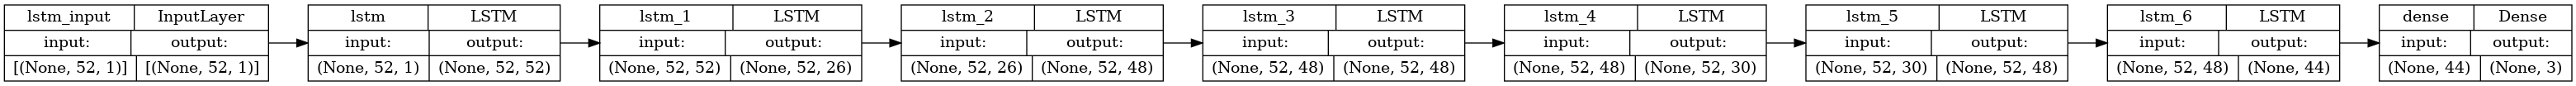

In [15]:
# LSTM model fitting

# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(units = 33, activation = 'relu', return_sequences= True),
#     tf.keras.layers.LSTM(units = 12, activation = 'relu', return_sequences= False),
#     tf.keras.layers.Dense(units = 3, activation = 'softmax'),
# ])


# model = tf.keras.Sequential([ 
#     tf.keras.layers.Dense(units = 330, activation = 'relu', batch_input_shape = (64,33)),    
#     tf.keras.layers.Dense(units = 300, activation = 'relu', kernel_regularizer='l2'),
#     tf.keras.layers.Dropout(0.2),                         
#     tf.keras.layers.Dense(units = 250, activation = 'relu', kernel_regularizer='l2'),                         
#     tf.keras.layers.Dropout(0.2),                               
#     tf.keras.layers.Dense(units = 220, activation = 'relu', kernel_regularizer='l2'),   
#     tf.keras.layers.Dropout(0.2),                                                
#     tf.keras.layers.Dense(units = 200, activation = 'relu', kernel_regularizer='l2'), 
#     tf.keras.layers.Dropout(0.2),                                                       
#     tf.keras.layers.Dense(units = 150, activation = 'relu', kernel_regularizer='l2'), 
#     tf.keras.layers.Dropout(0.2),                                                       
#     tf.keras.layers.Dense(units = 10, activation = 'relu', kernel_regularizer='l2'),                         
#     tf.keras.layers.Dense(units = 3, activation = 'softmax'),
# ])


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units = 52, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.LSTM(units = 26, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.LSTM(units = 48, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.LSTM(units = 48, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.LSTM(units = 30, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.LSTM(units = 48, activation = 'selu', return_sequences= True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.LSTM(units = 44, activation = 'selu', return_sequences= False, kernel_regularizer=tf.keras.regularizers.L2(l2=0.00000195)),
    tf.keras.layers.Dense(units = 3, activation = 'softmax'),
])

# # Compiling the RNN
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#             optimizer= tf.keras.optimizers.Adam(learning_rate = 1.0955e-06, clipnorm=1),
#             metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.F1Score(), tf.keras.metrics.CategoricalCrossentropy()])

# best learning rate so far with 600 epochs Adam(learning_rate = 3.206e-05, global_clipnorm=1, use_ema=True, ema_momentum=0.99, amsgrad = True, beta_1=0.9, beta_2=0.999)

# model = tf.keras.saving.load_model("/ckpt/checkpoint.model.keras")

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    0.0001,
    1000,
    alpha=1.0e-07,
    warmup_target=0.0001,
    warmup_steps=10
)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer= tf.keras.optimizers.AdamW(learning_rate = 1.0955e-06, global_clipnorm=1, amsgrad = True, weight_decay=1.0955e-06),
            metrics = [tf.keras.metrics.CategoricalCrossentropy(),tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.F1Score()])

# save model checkpoints
checkpoint_filepath = 'ckpt/epoch:{epoch:02d}-val_loss:{val_loss:.4f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 0)

# earlystopping callback
EStop = tf.keras.callbacks.EarlyStopping(monitor="categorical_crossentropy", mode = 'min', min_delta= 0.0001, patience=500, restore_best_weights=True, verbose=0)

# assigning weights for the classes
weight_for_0 = 1
weight_for_1 = 1
weight_for_2 = 1

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

# # Fitting the RNN to the Training set
model.fit(x=X_train, y=Y_train, validation_data = (X_val,y_val) ,epochs = 1000, batch_size=150, verbose=2, class_weight=class_weight, callbacks=[model_checkpoint_callback, EStop])
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [12]:
# evaluate
model = tf.keras.models.load_model('/home/samer/Desktop/Big data Small Data/BDSD/Minor_project/BDSD_Minor_Project/trained_models/epoch4437val_loss0.6506.keras')

test_blend_set = []
test_labels_set = []
test_index_set = []
with open("blends_test_index.csv", mode= "r") as test_data:
  csvFile = csv.reader(test_data)
  next(csvFile)
  for lines in csvFile:
      test_blend_set.append(lines[0:52])
      test_labels_set.append(lines[52])
      test_index_set.append(lines[53])
test_blend_set = np.array(test_blend_set, dtype=np.float64)
test_labels_set = np.array(test_labels_set, dtype=np.float64).astype('int')
test_labels_set = tf.keras.utils.to_categorical(test_labels_set, num_classes=3)
X_test = np.reshape(test_blend_set, (1646, 52,1))

model.evaluate(X_test,test_labels_set)


# model.save('LSTM_model_full_data_acc:63_f1:55.keras')

2024-05-18 01:23:49.215582: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 01:23:49.297344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-18 01:23:49.297581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

52/52 [==============================] - 2s 18ms/step - loss: 0.6238 - categorical_crossentropy: 0.6235 - categorical_accuracy: 0.7199 - f1_score: 0.6298


[0.6237841248512268,
 0.6234527826309204,
 0.7199270725250244,
 array([0.7459138 , 0.7962529 , 0.34710744], dtype=float32)]

In [15]:
# predict test classes
# new_model = tf.keras.models.load_model('LSTM_model_73%_test_acc')
predictions = []
for inst in X_test:
    inst = np.array(inst, dtype=np.float64)
    inst = np.reshape(inst, (1,52,1))
    # print(inst)
    y_pred = model.predict(inst, verbose=0)
    y_pred = np.argmax(y_pred)
    predictions.append(y_pred)
    # print(predictions)

In [19]:
# confusion matrix

errors_count = {"0":0, "1":0, "2":0}
ground_truth = []
errors = []
for i in test_labels_set:
    i = np.argmax(i)
    ground_truth.append(i)
for j in range(len(test_blend_set)):
    if predictions[j] != ground_truth[j]:
        errors.append(test_index_set[j])
cm=tf.math.confusion_matrix(ground_truth,predictions,num_classes=3,dtype=tf.dtypes.int32,)
print(cm)
for i in range(1646):
    if predictions[i]==ground_truth[i]:
        continue
    elif predictions[i] != ground_truth[i]:
        errors_count[str(ground_truth[i])] = errors_count[str(ground_truth[i])] + 1
print(errors_count)
print(errors)
print(len(errors))

tf.Tensor(
[[251  35   5]
 [110 850 150]
 [ 21 140  84]], shape=(3, 3), dtype=int32)
{'0': 40, '1': 260, '2': 161}
['1.0', '4.0', '6.0', '8.0', '10.0', '30.0', '32.0', '34.0', '36.0', '43.0', '45.0', '50.0', '52.0', '53.0', '54.0', '60.0', '70.0', '75.0', '79.0', '81.0', '83.0', '87.0', '90.0', '98.0', '105.0', '106.0', '114.0', '116.0', '118.0', '122.0', '124.0', '126.0', '129.0', '136.0', '138.0', '141.0', '146.0', '153.0', '156.0', '159.0', '162.0', '166.0', '167.0', '175.0', '178.0', '186.0', '187.0', '192.0', '201.0', '202.0', '205.0', '207.0', '212.0', '214.0', '224.0', '231.0', '234.0', '235.0', '239.0', '243.0', '244.0', '246.0', '248.0', '249.0', '250.0', '251.0', '253.0', '254.0', '255.0', '260.0', '262.0', '264.0', '270.0', '271.0', '274.0', '282.0', '283.0', '288.0', '295.0', '296.0', '297.0', '301.0', '307.0', '308.0', '310.0', '312.0', '314.0', '317.0', '319.0', '322.0', '323.0', '328.0', '334.0', '338.0', '342.0', '343.0', '346.0', '352.0', '353.0', '357.0', '358.0', '35

1.0


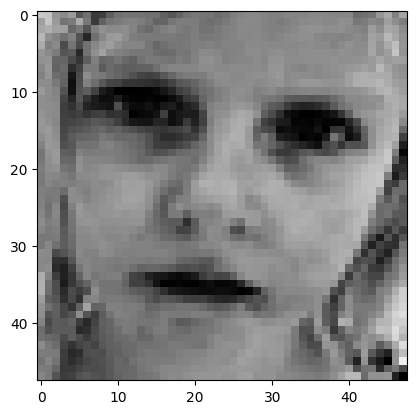

4.0


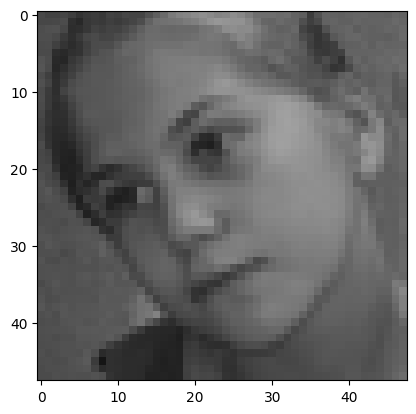

6.0


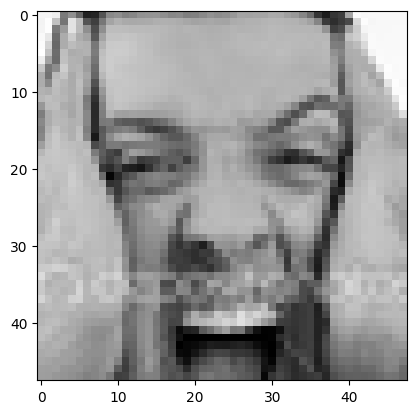

8.0


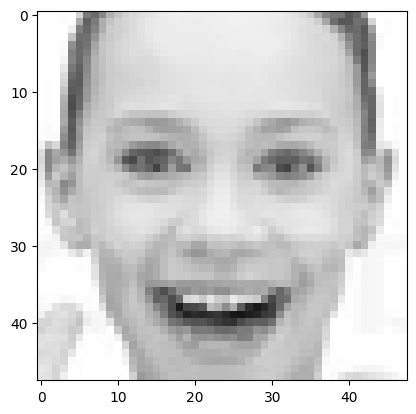

10.0


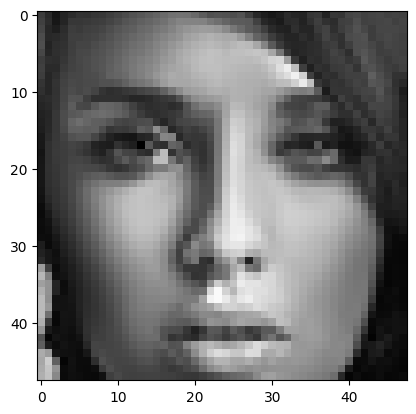

30.0


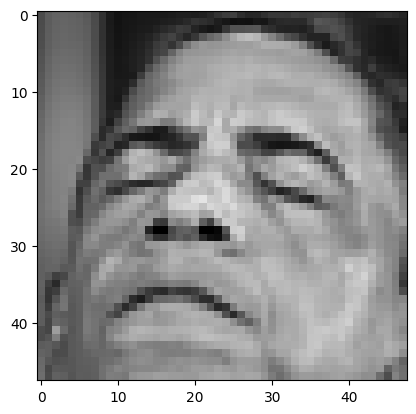

32.0


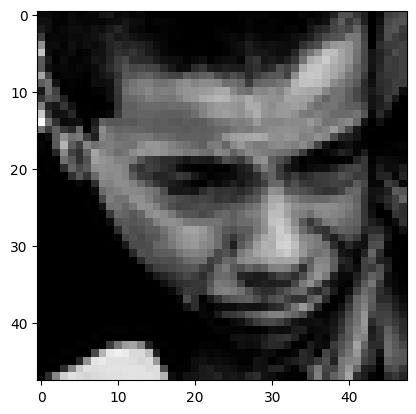

34.0


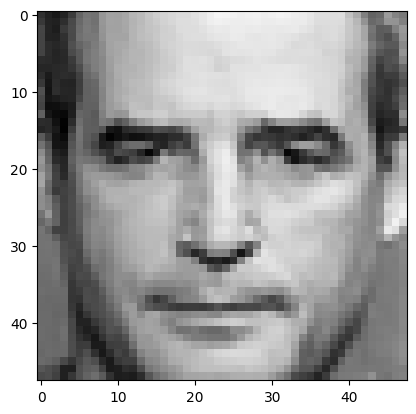

36.0


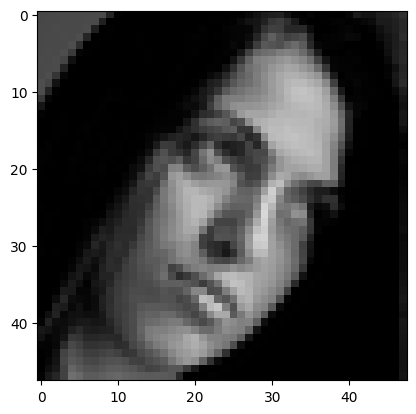

43.0


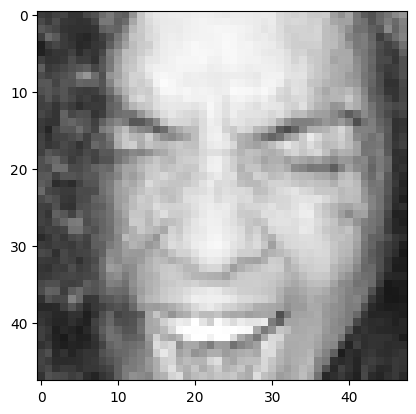

45.0


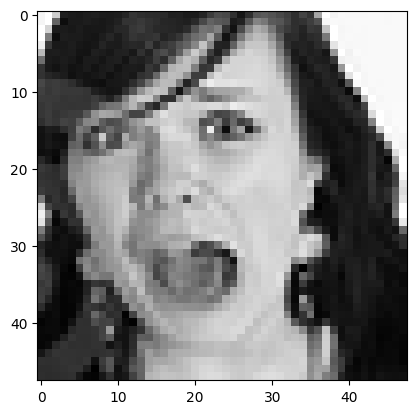

50.0


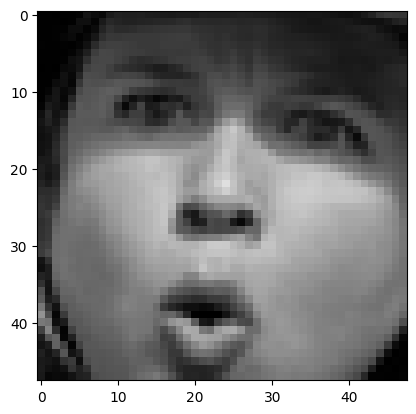

52.0


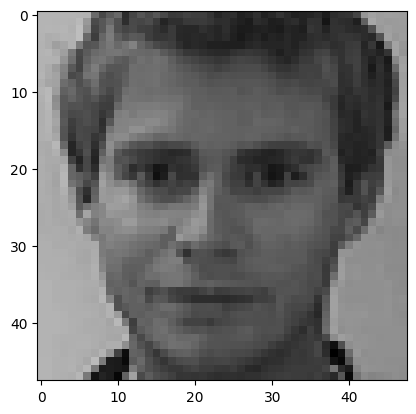

53.0


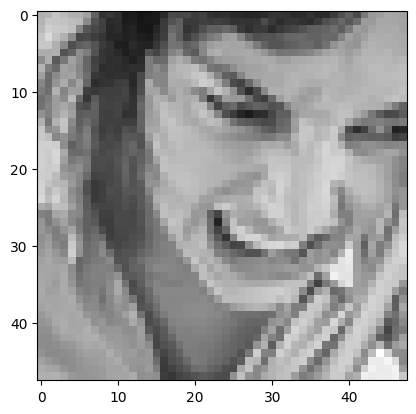

54.0


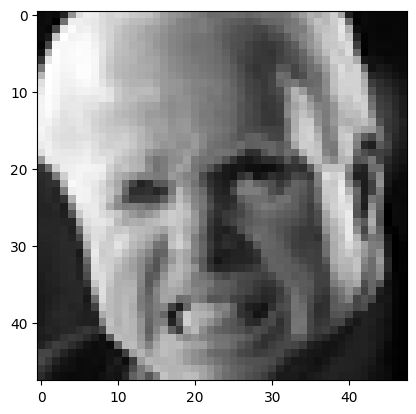

60.0


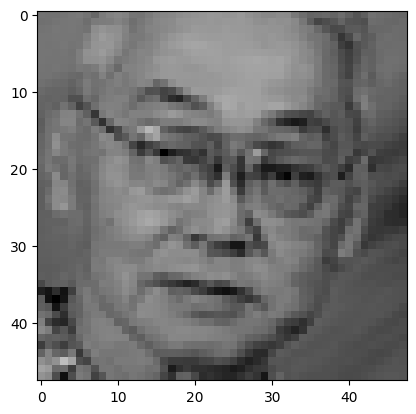

70.0


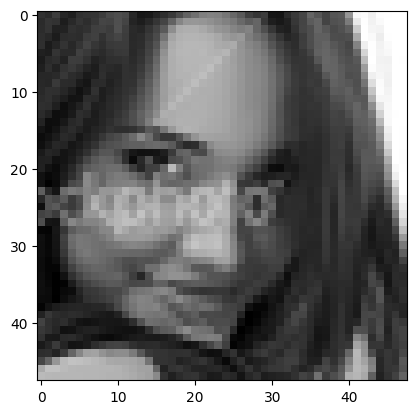

75.0


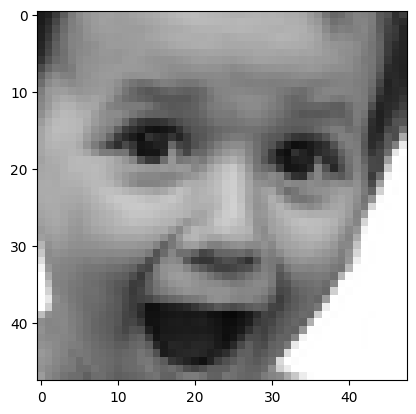

79.0


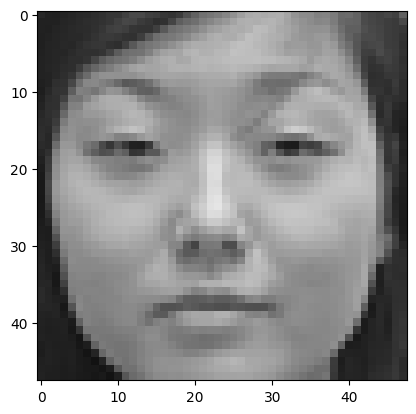

81.0


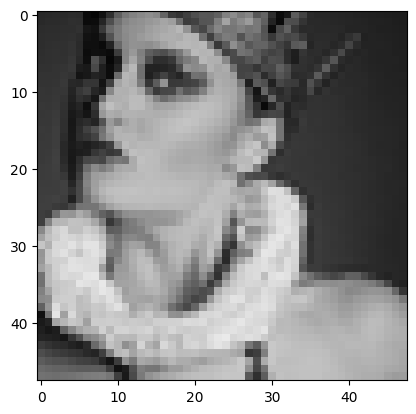

83.0


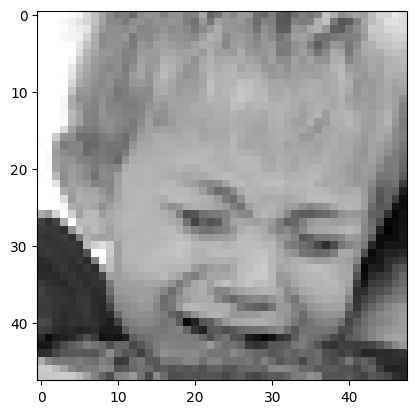

87.0


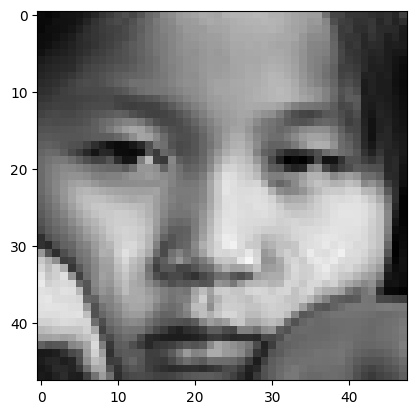

90.0


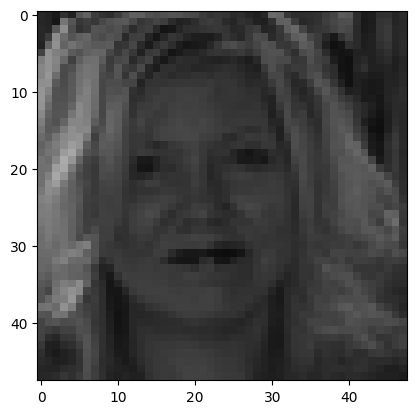

98.0


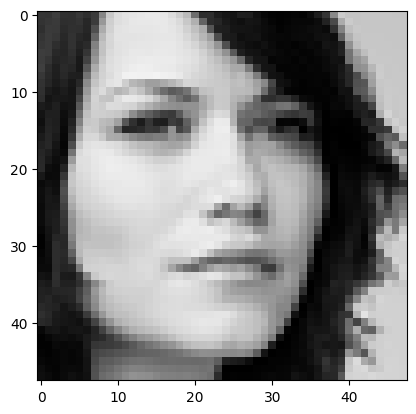

105.0


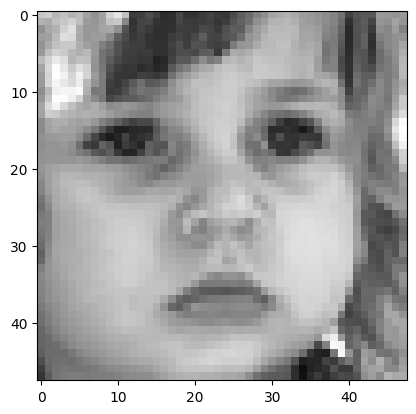

106.0


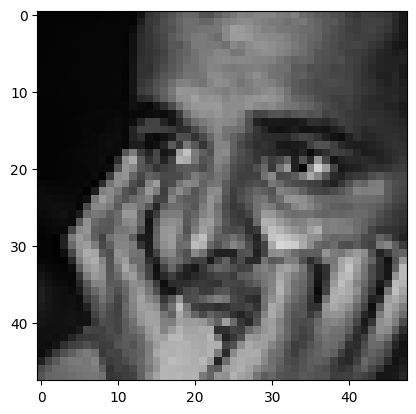

114.0


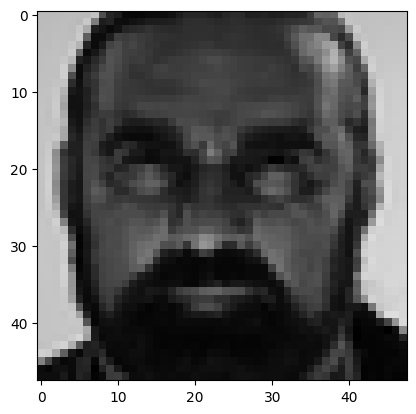

116.0


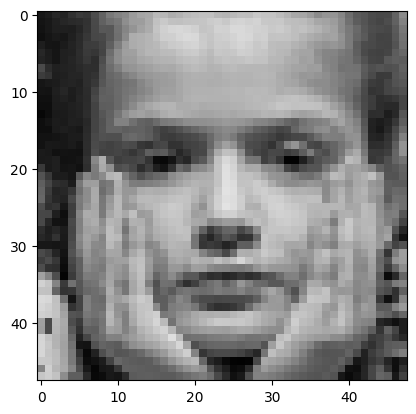

118.0


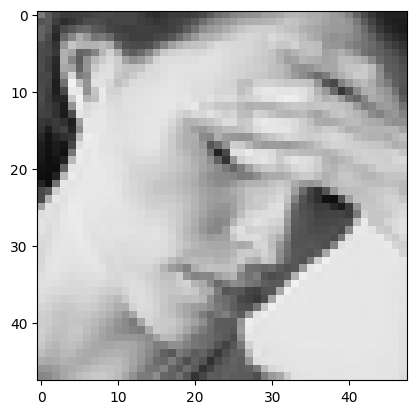

122.0


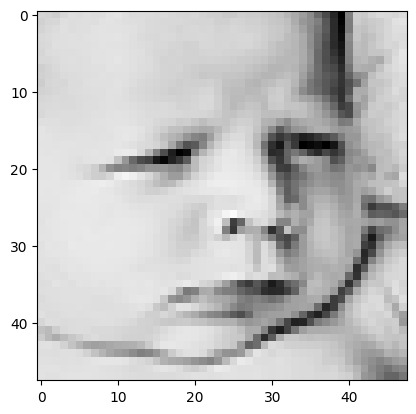

124.0


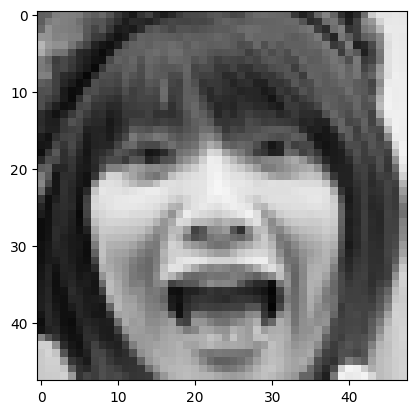

126.0


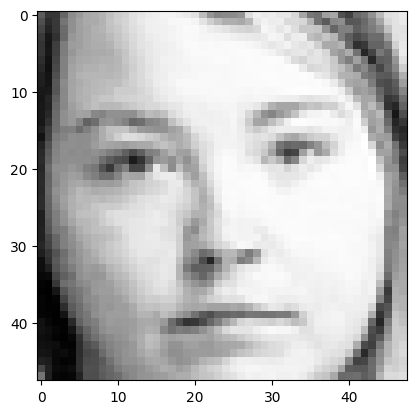

129.0


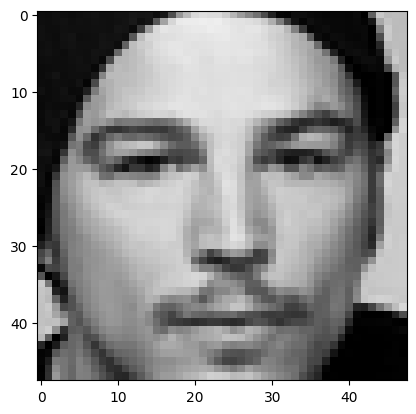

136.0


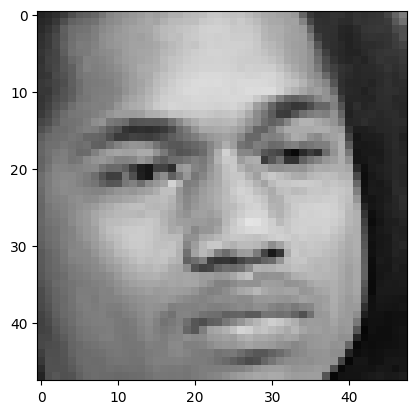

138.0


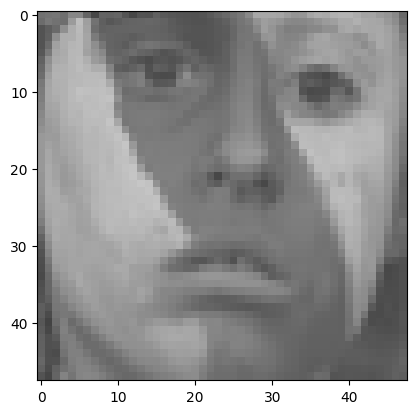

141.0


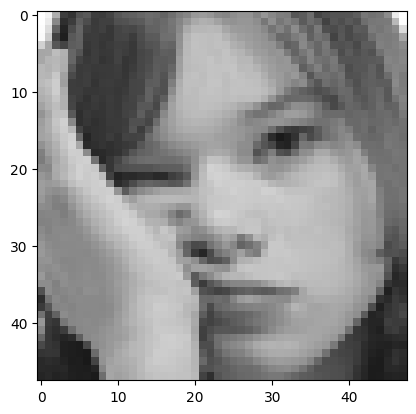

146.0


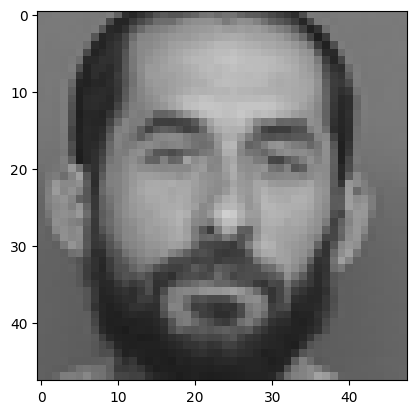

153.0


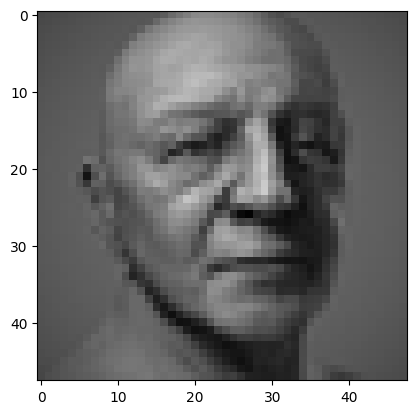

156.0


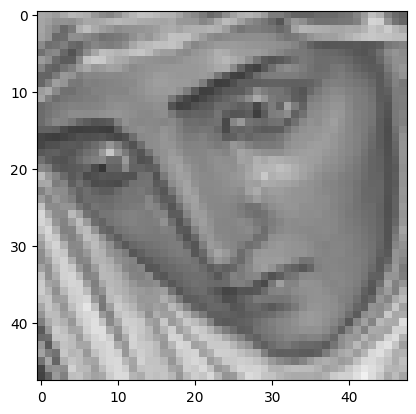

159.0


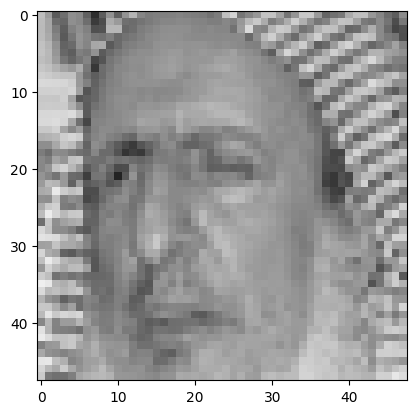

162.0


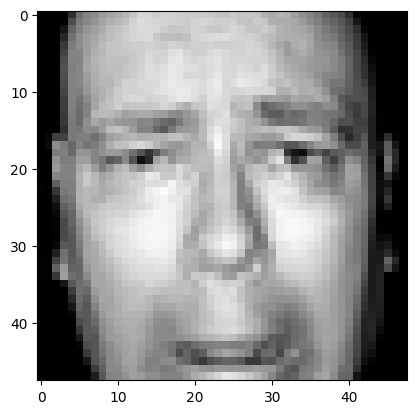

166.0


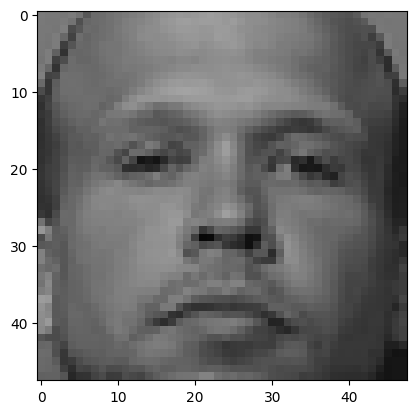

167.0


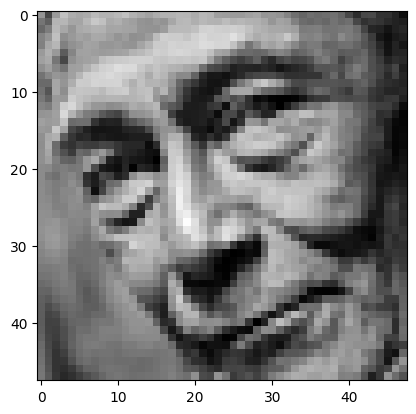

175.0


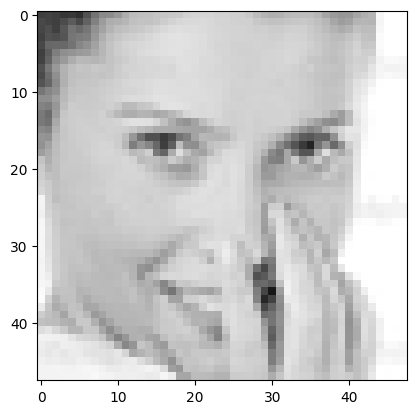

178.0


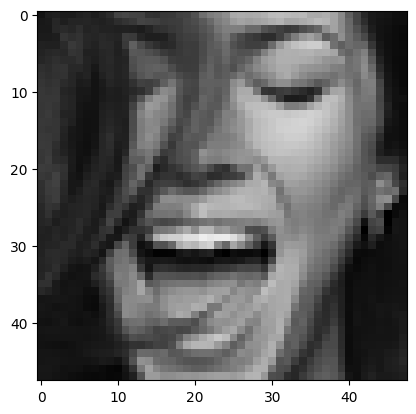

186.0


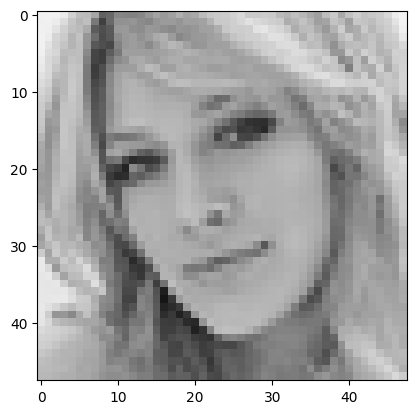

187.0


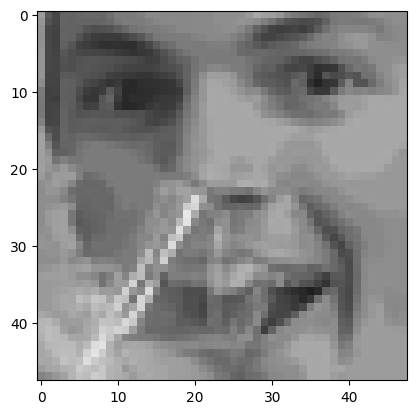

192.0


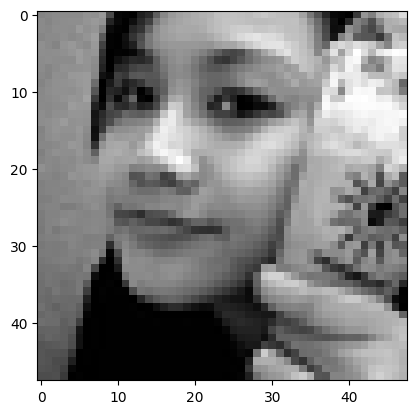

201.0


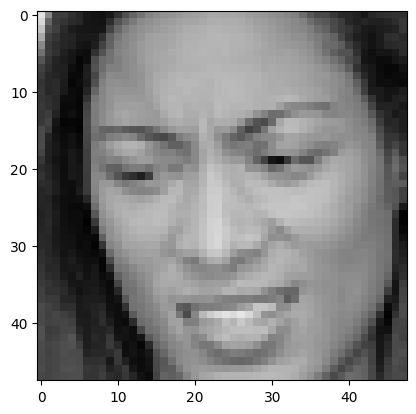

202.0


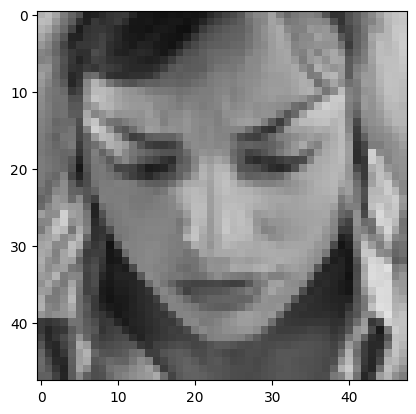

205.0


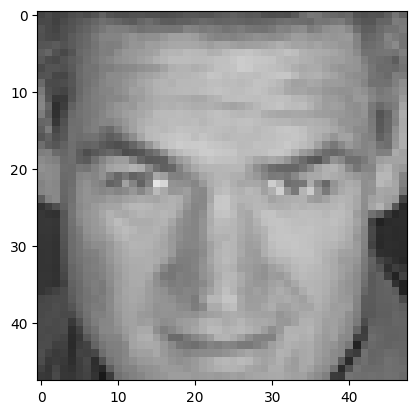

207.0


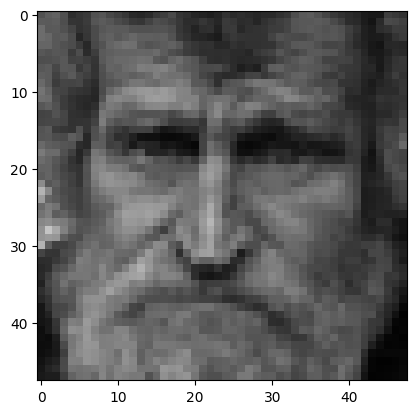

212.0


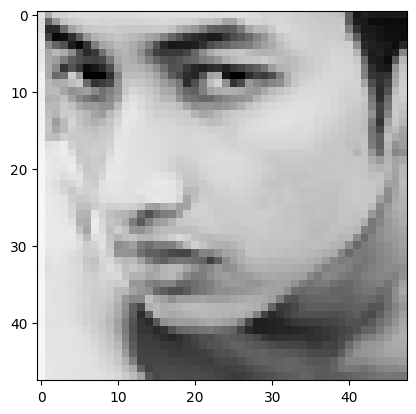

214.0


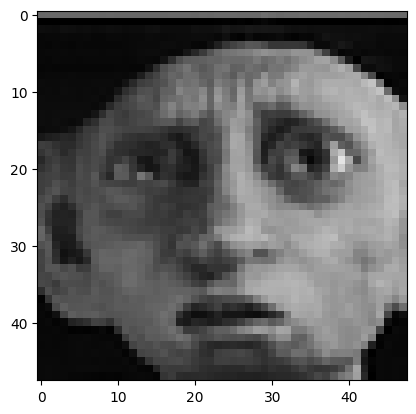

224.0


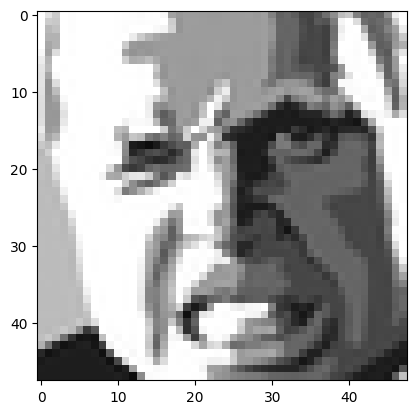

231.0


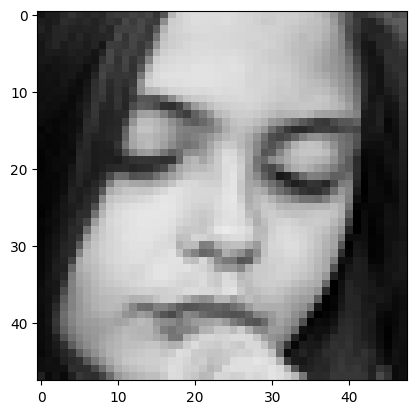

234.0


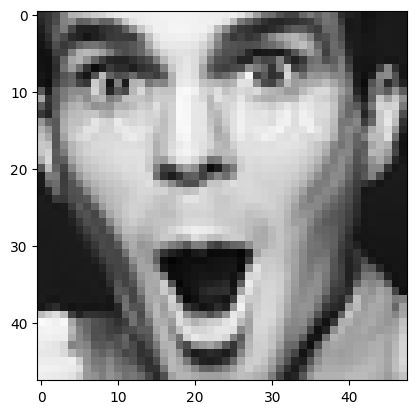

235.0


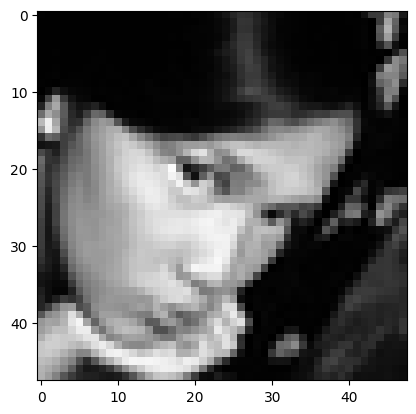

239.0


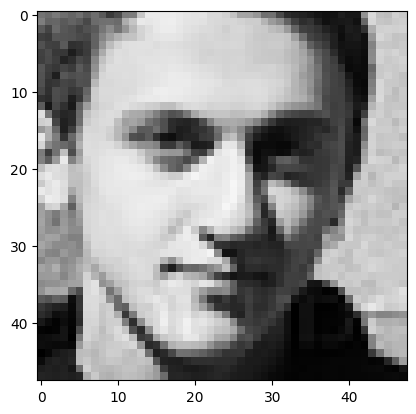

243.0


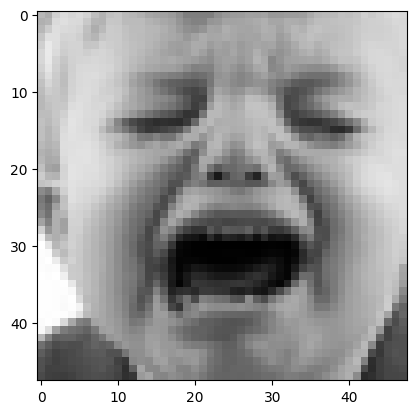

244.0


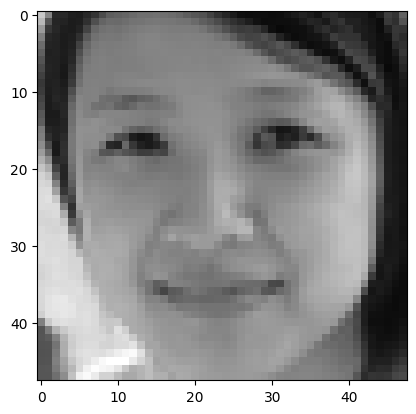

246.0


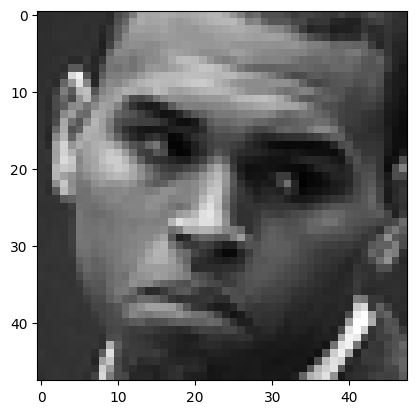

248.0


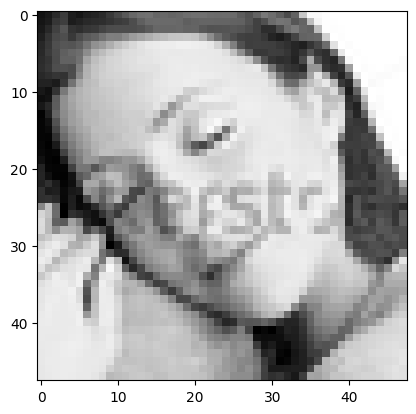

249.0


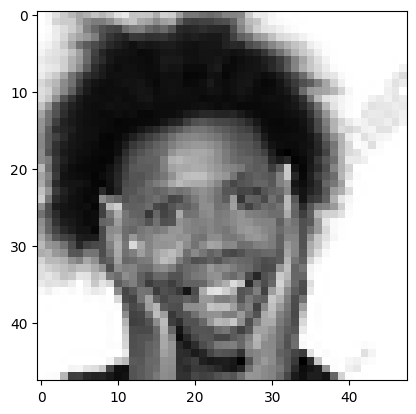

250.0


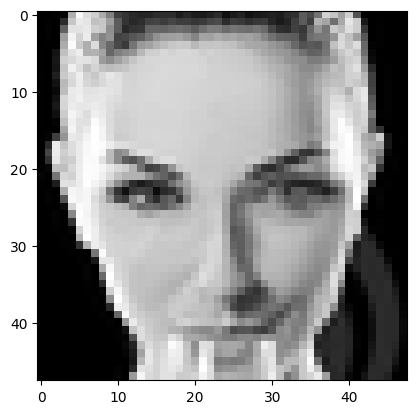

251.0


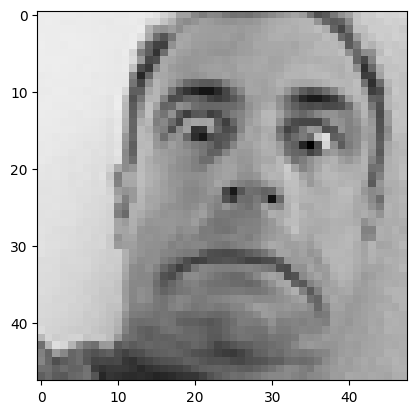

253.0


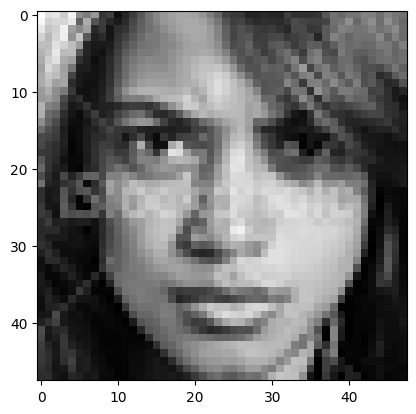

254.0


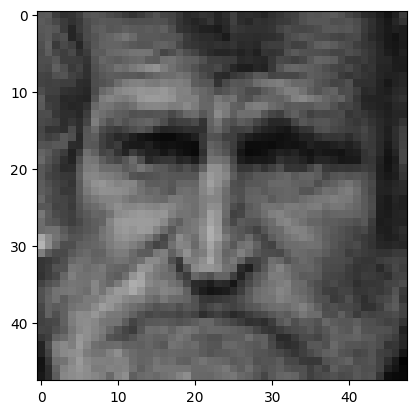

255.0


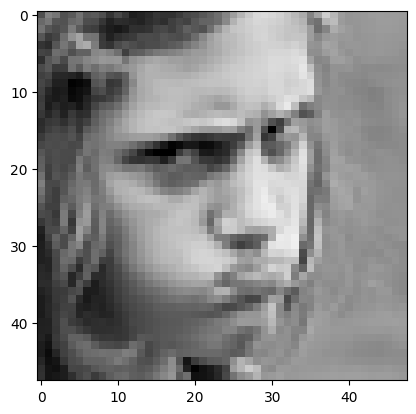

260.0


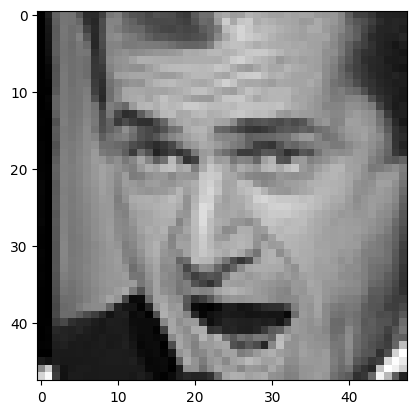

262.0


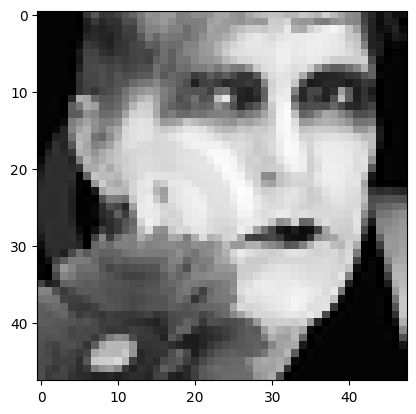

264.0


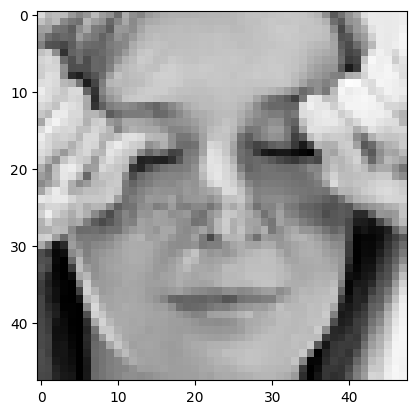

270.0


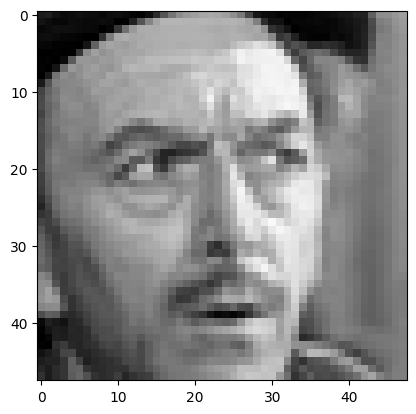

271.0


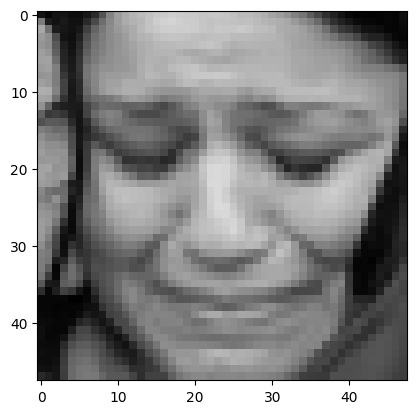

274.0


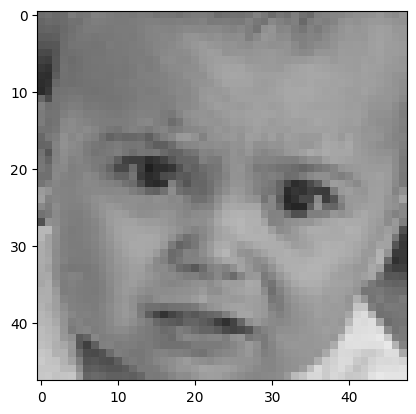

282.0


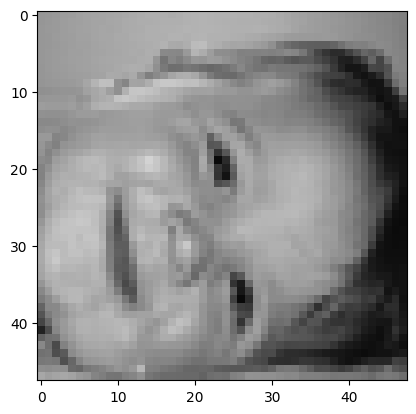

283.0


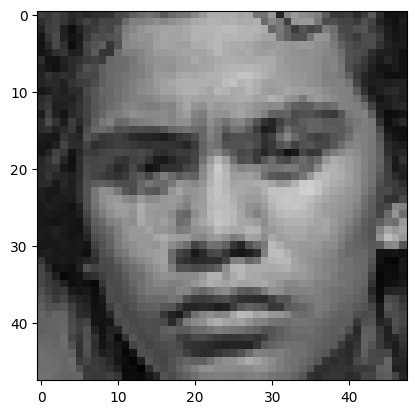

288.0


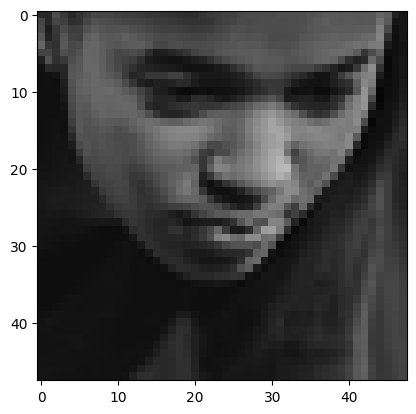

295.0


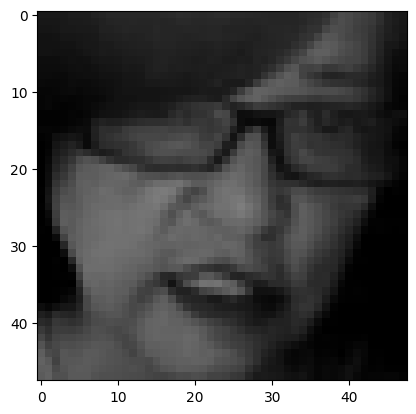

296.0


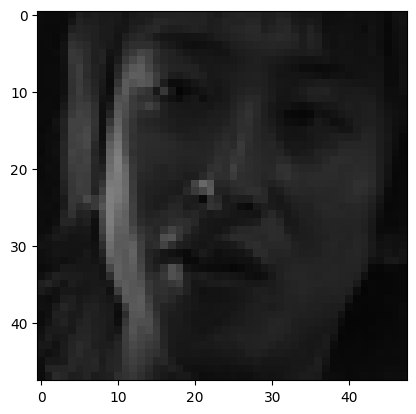

297.0


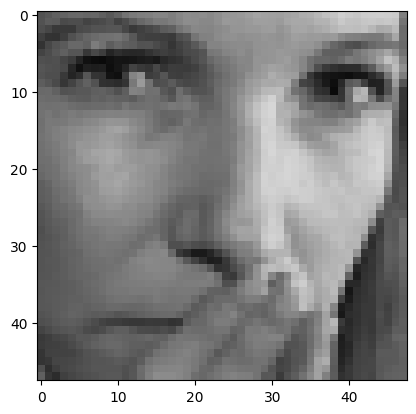

301.0


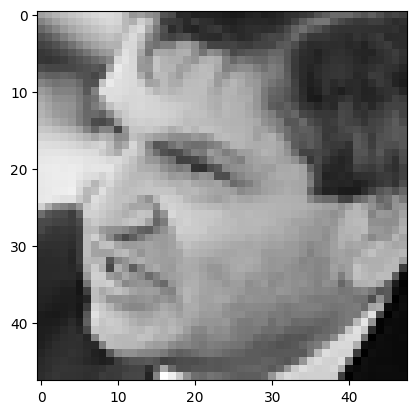

307.0


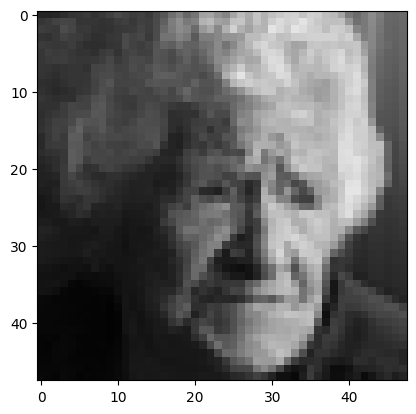

308.0


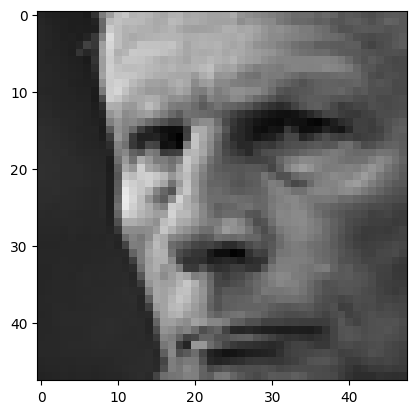

310.0


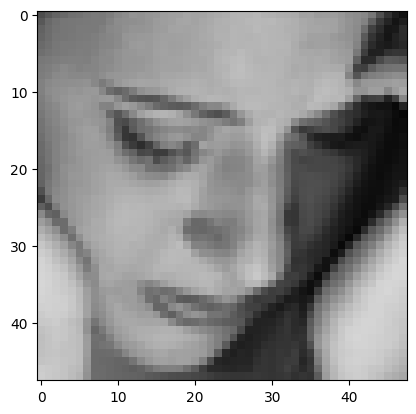

312.0


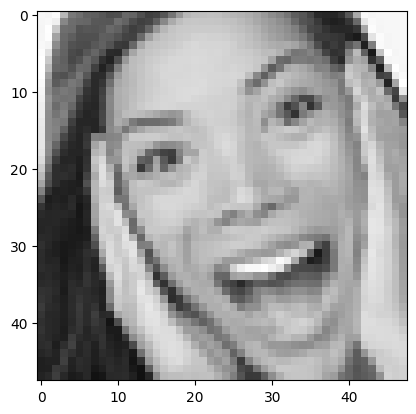

314.0


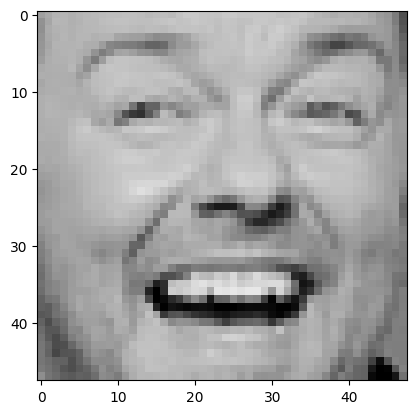

317.0


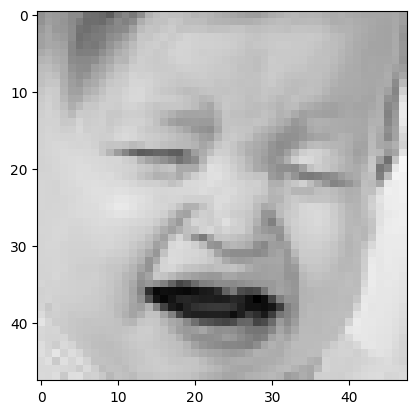

319.0


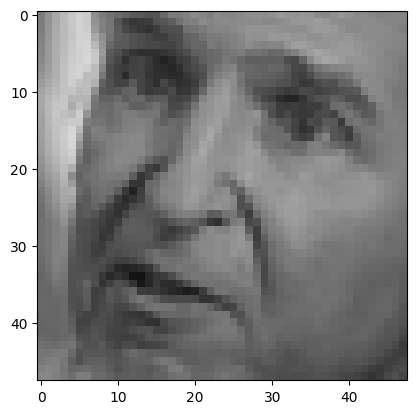

322.0


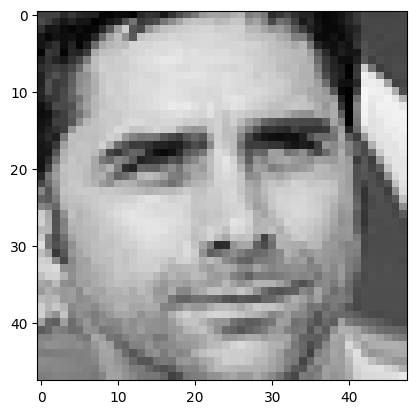

323.0


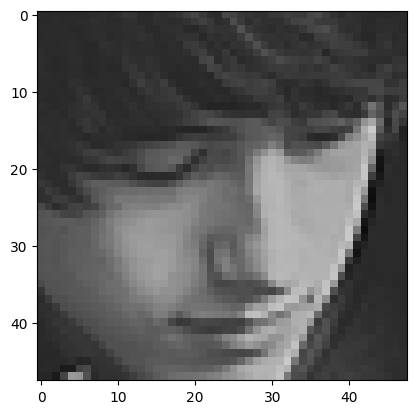

328.0


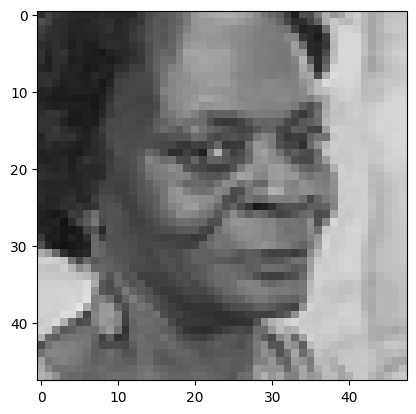

334.0


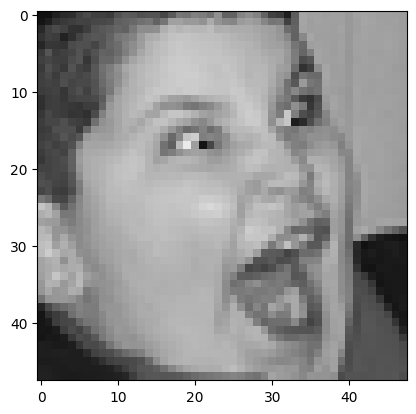

338.0


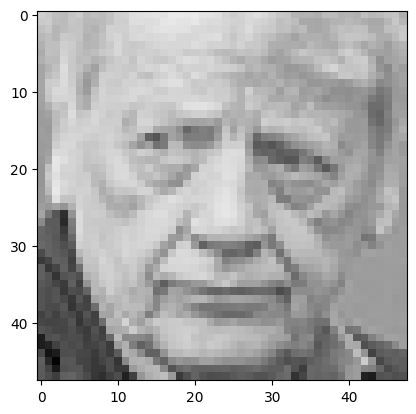

342.0


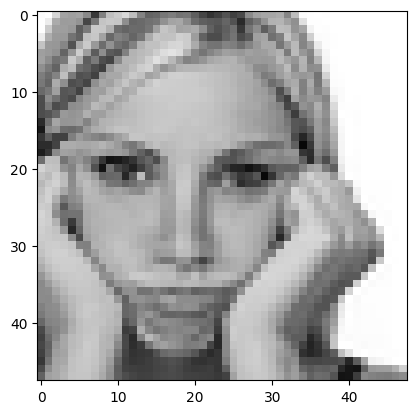

343.0


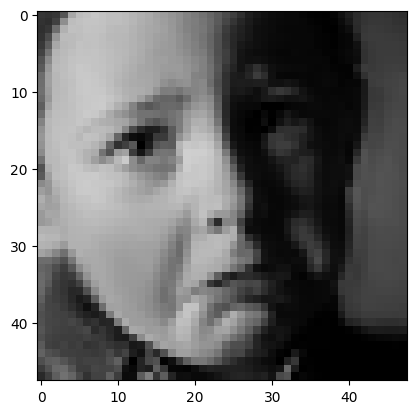

346.0


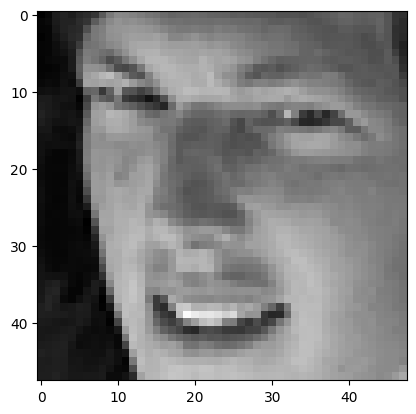

352.0


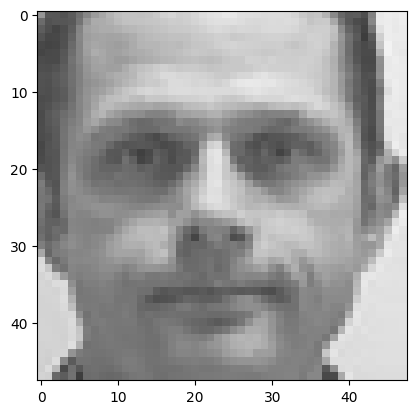

353.0


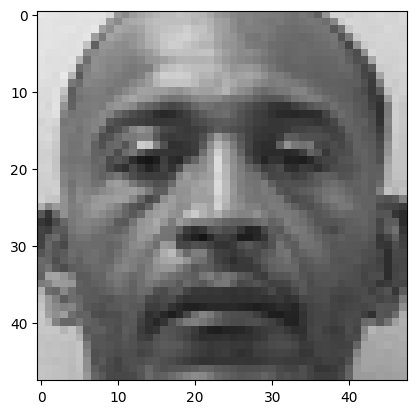

357.0


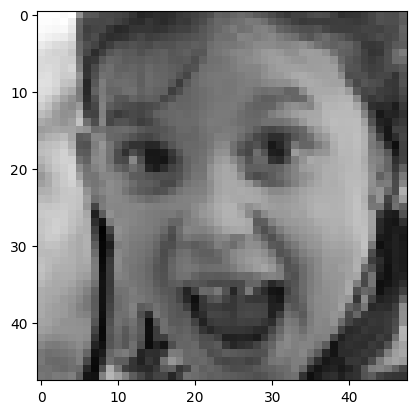

358.0


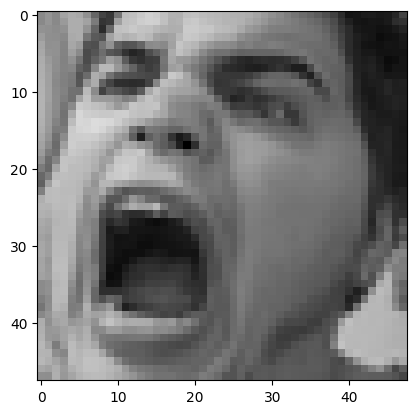

359.0


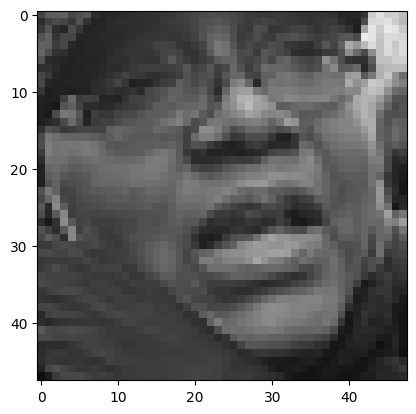

362.0


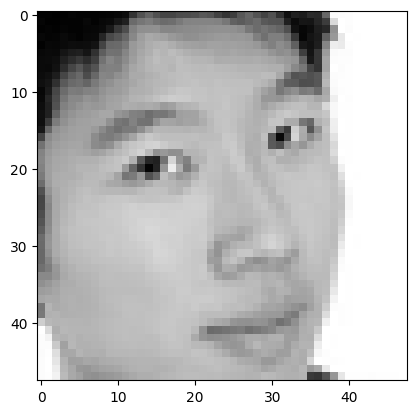

369.0


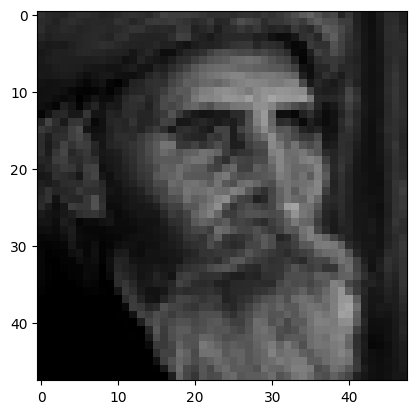

370.0


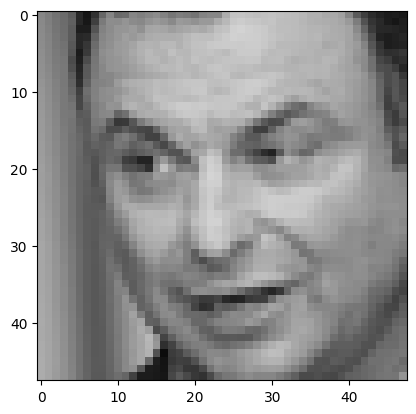

384.0


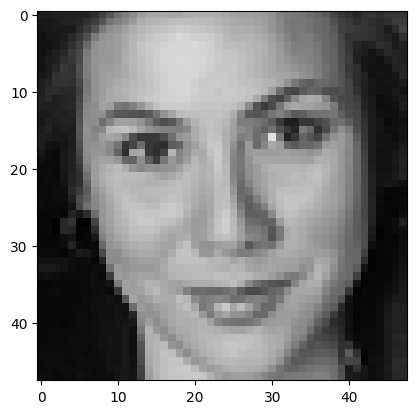

385.0


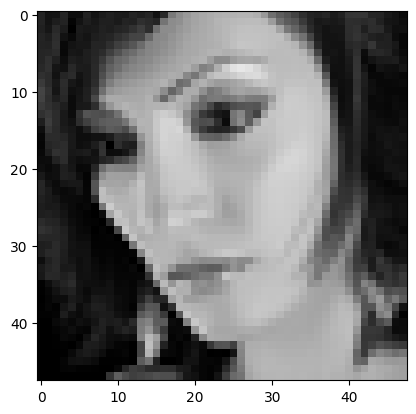

386.0


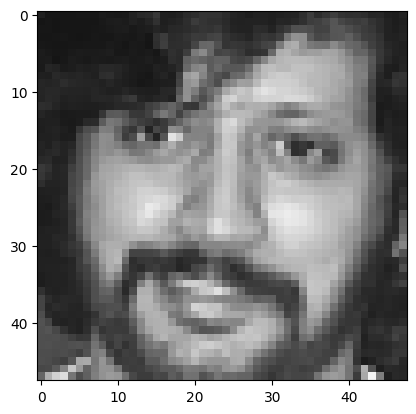

388.0


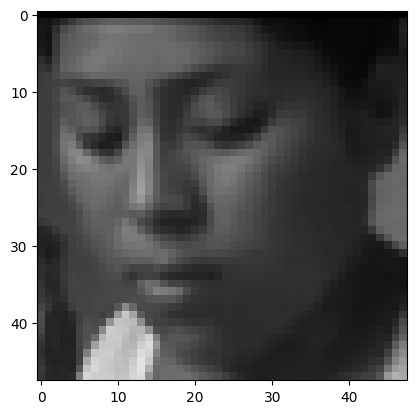

390.0


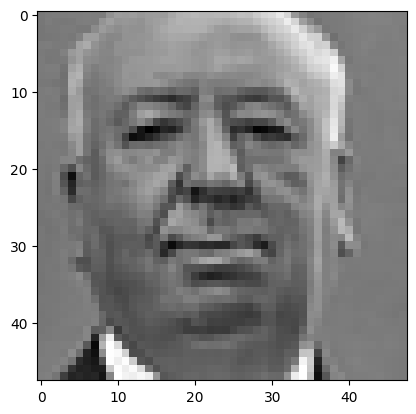

391.0


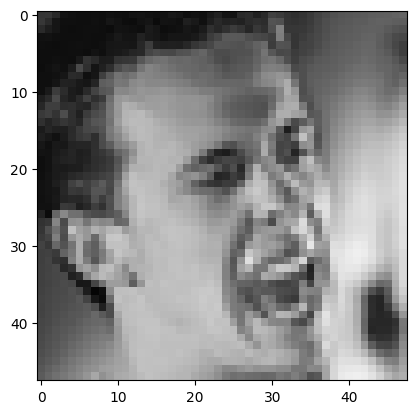

392.0


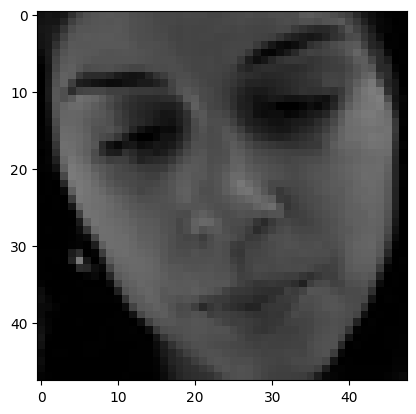

394.0


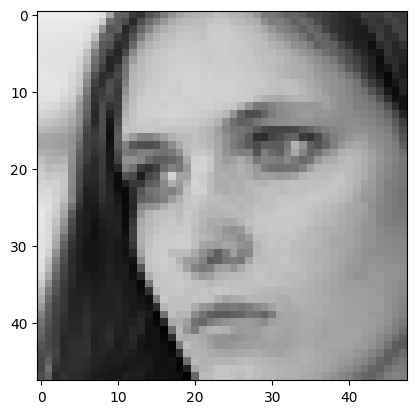

397.0


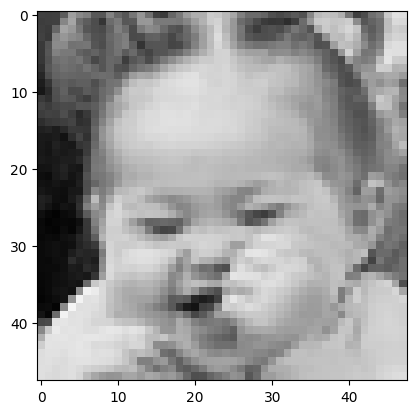

398.0


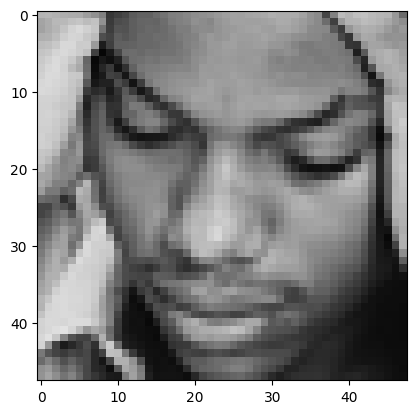

405.0


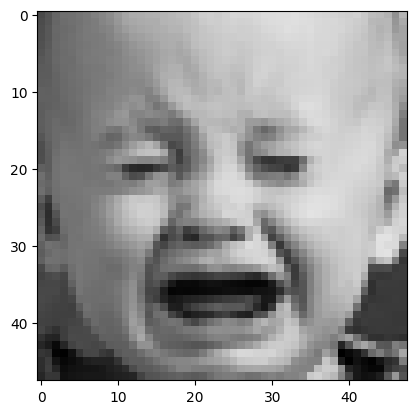

406.0


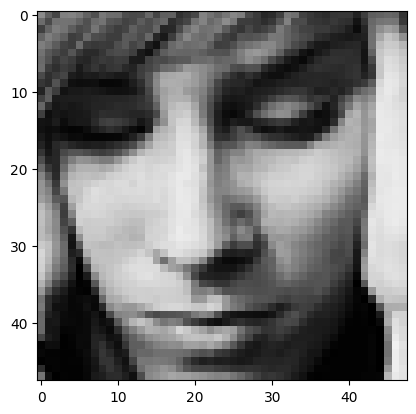

412.0


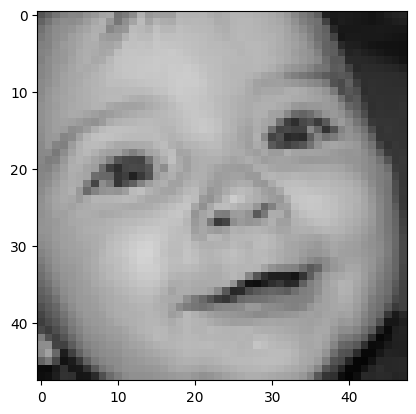

415.0


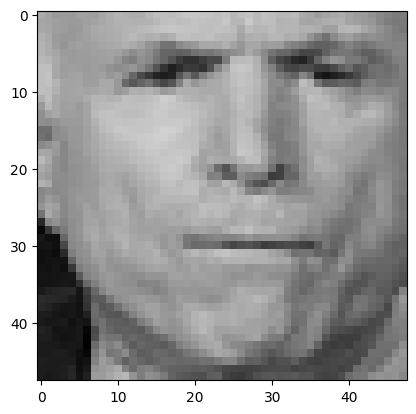

417.0


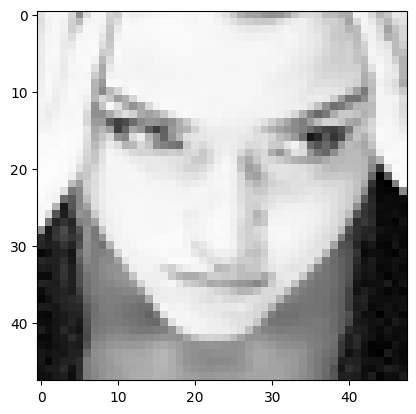

420.0


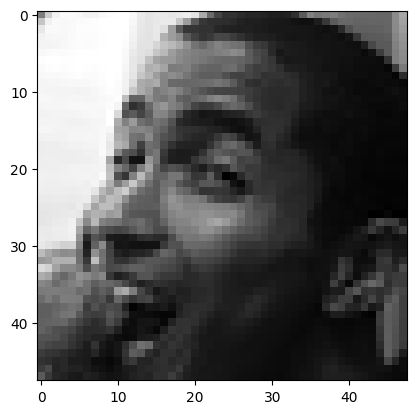

424.0


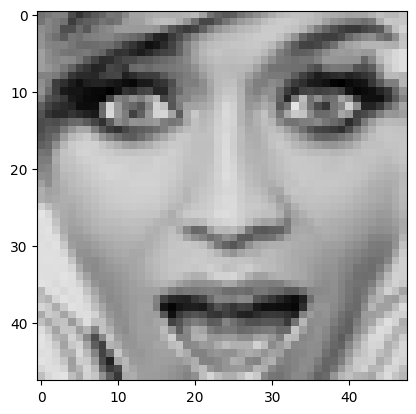

428.0


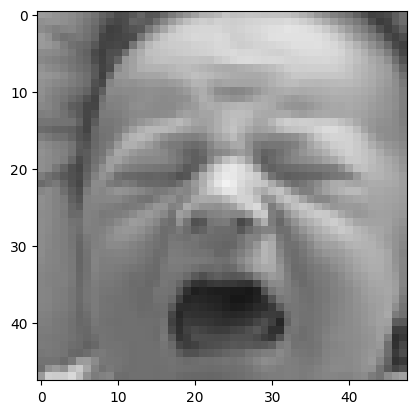

432.0


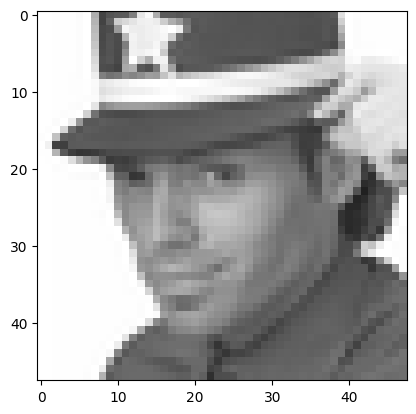

437.0


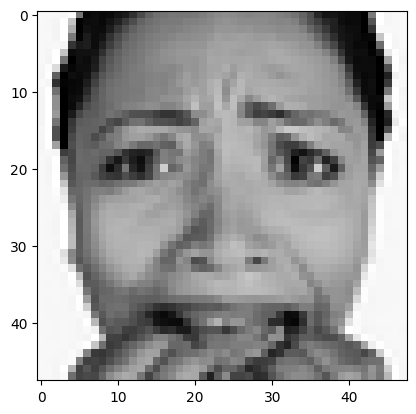

439.0


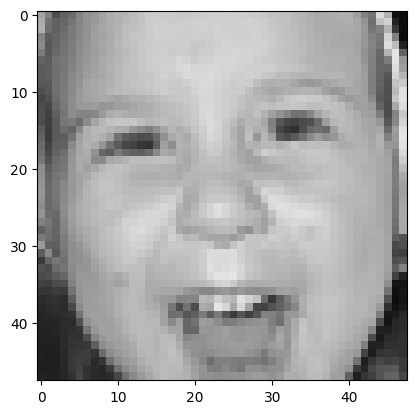

448.0


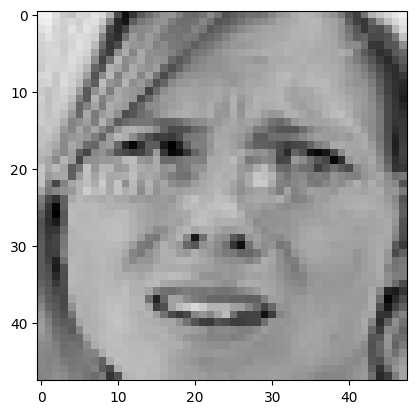

449.0


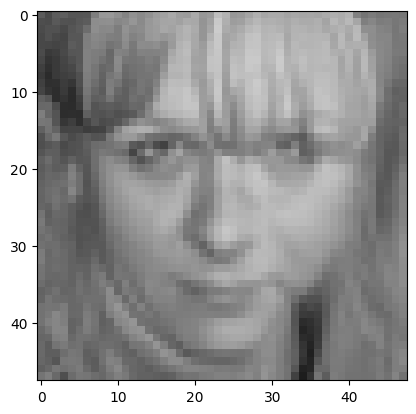

453.0


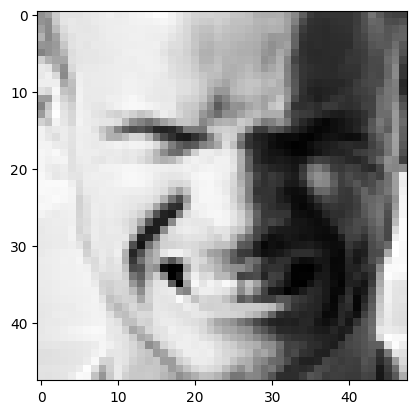

455.0


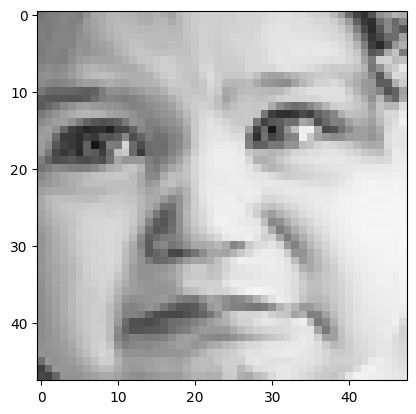

468.0


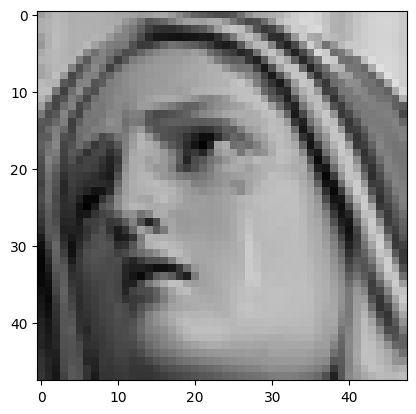

481.0


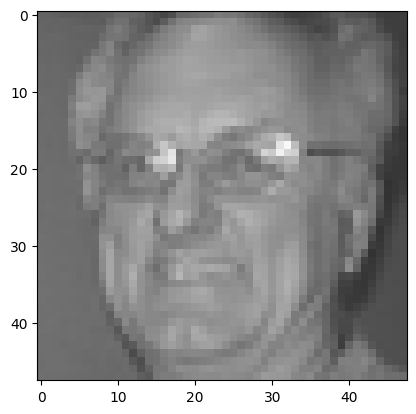

482.0


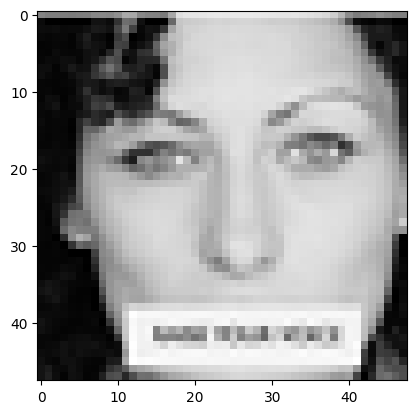

483.0


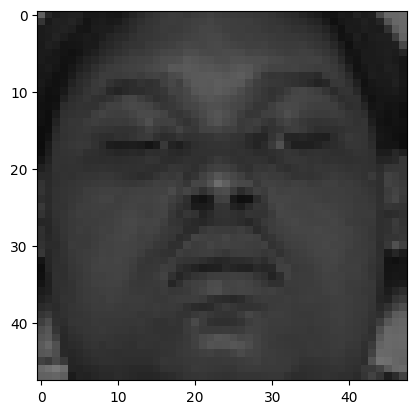

487.0


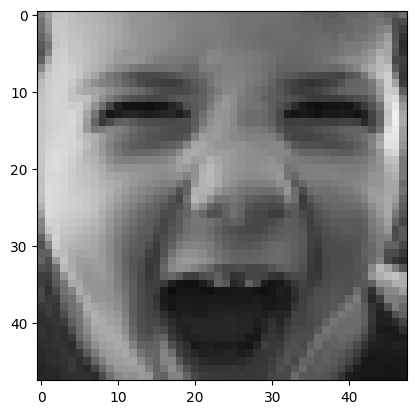

489.0


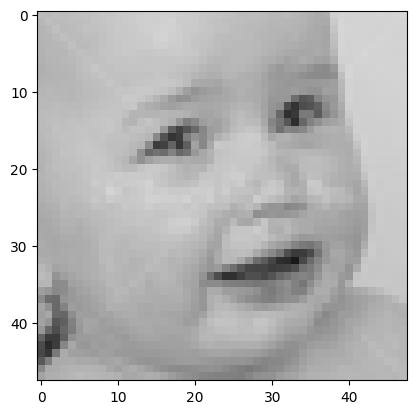

491.0


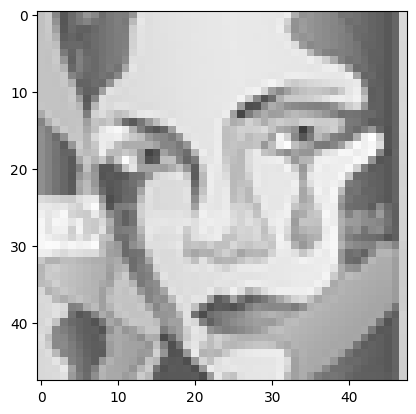

495.0


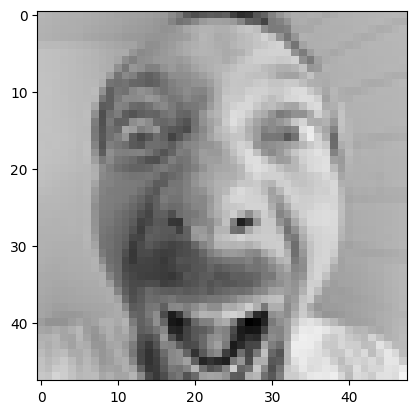

498.0


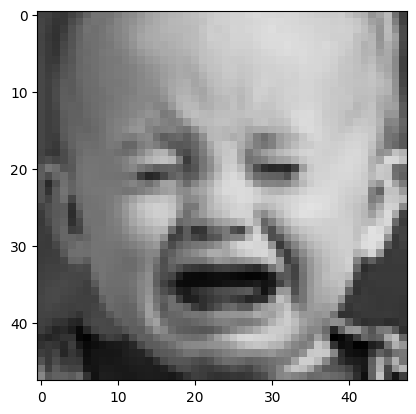

500.0


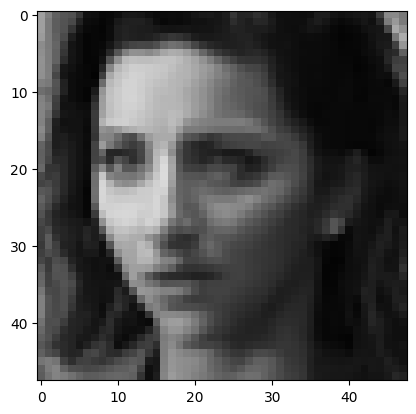

501.0


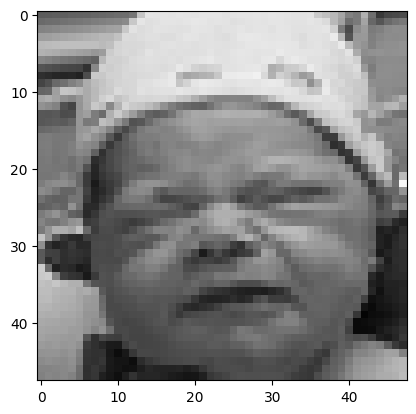

503.0


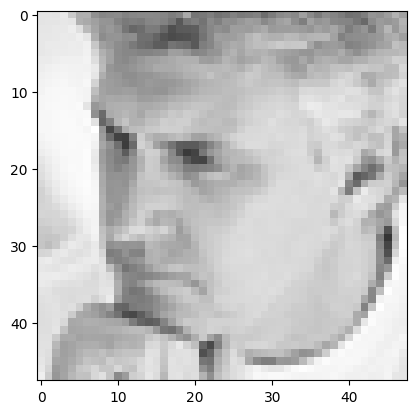

507.0


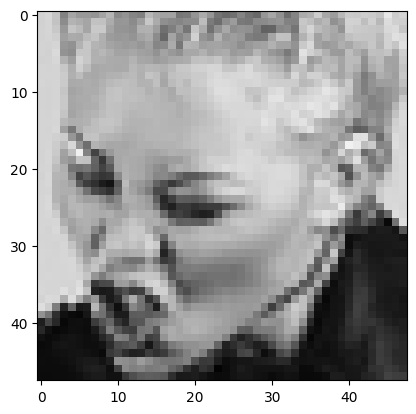

511.0


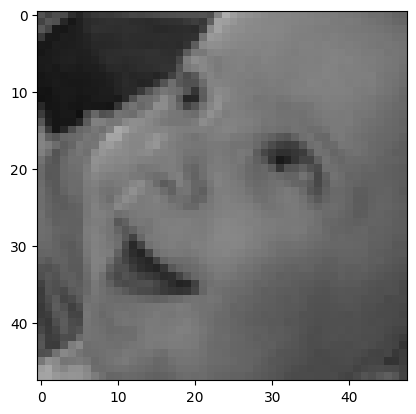

513.0


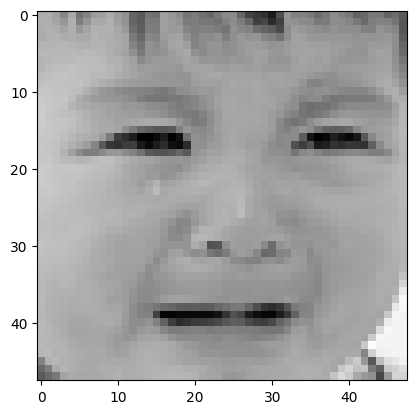

520.0


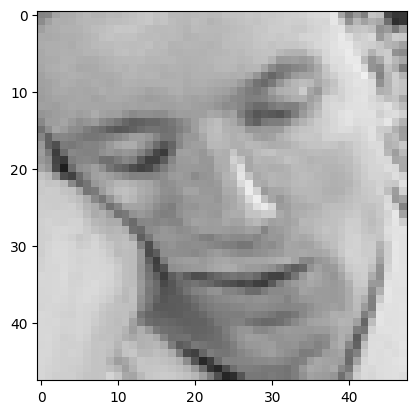

523.0


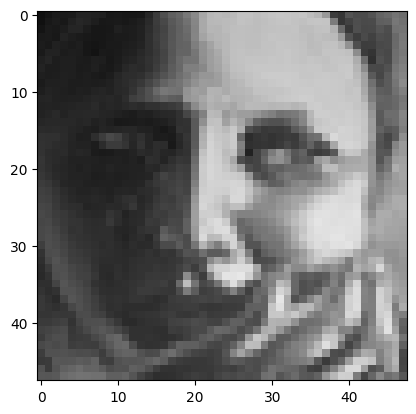

524.0


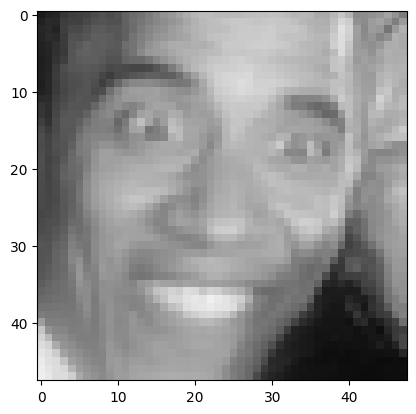

526.0


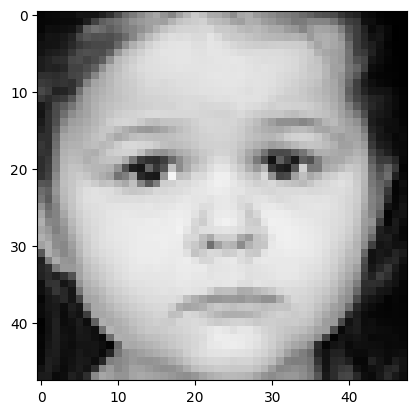

528.0


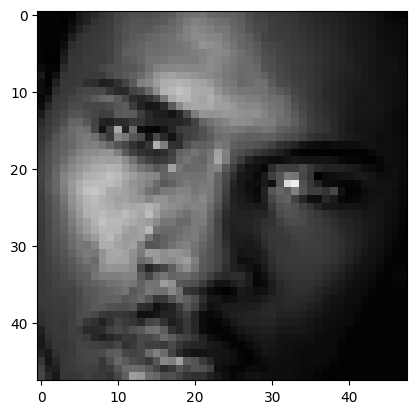

531.0


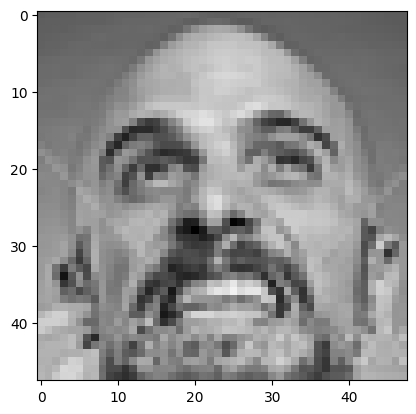

532.0


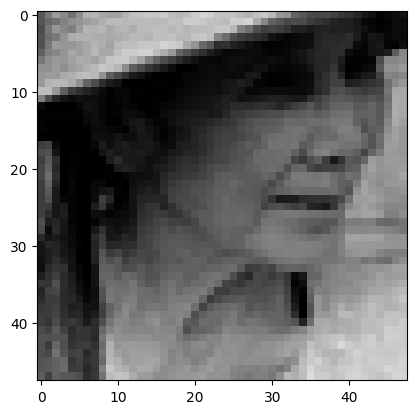

534.0


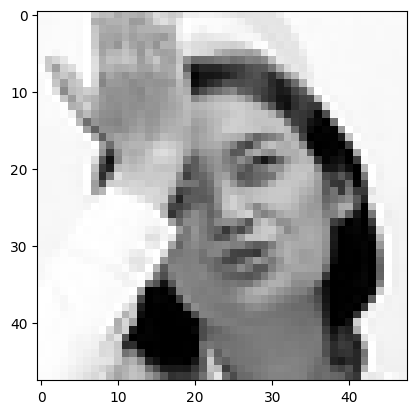

538.0


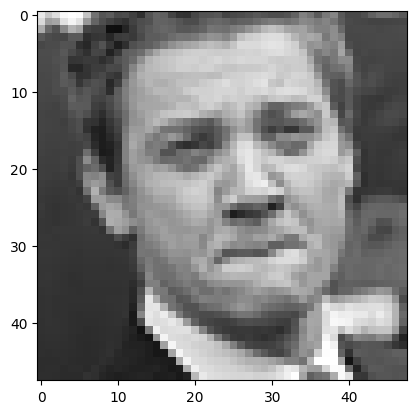

543.0


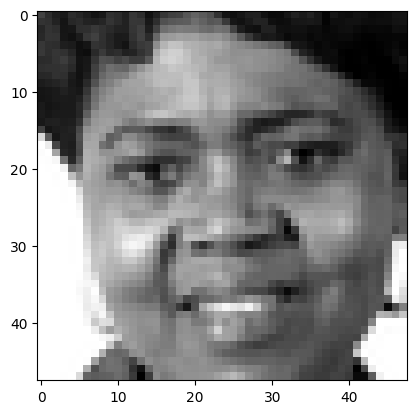

544.0


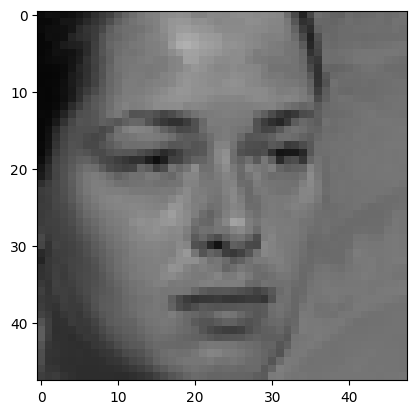

548.0


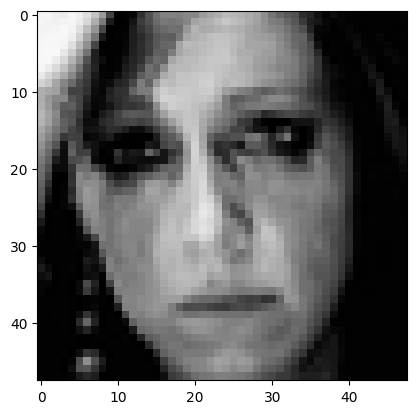

550.0


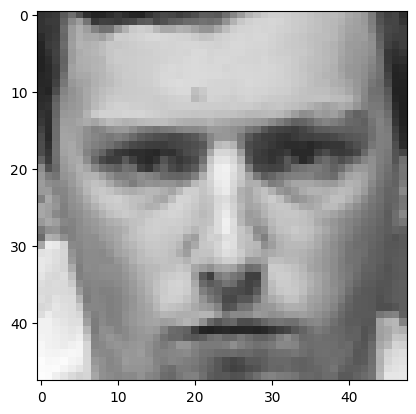

554.0


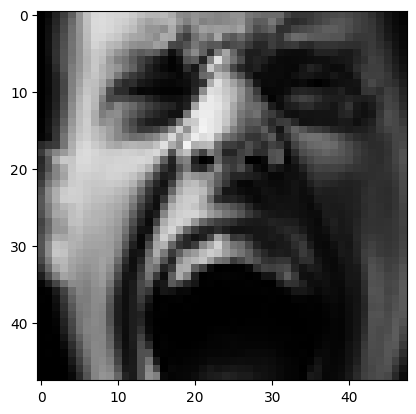

556.0


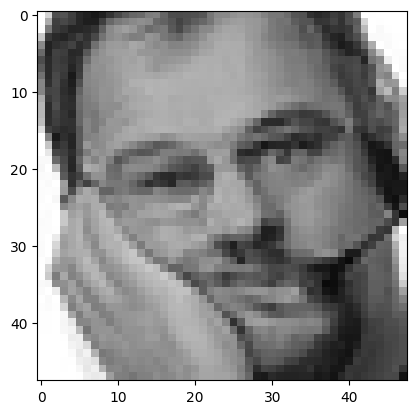

558.0


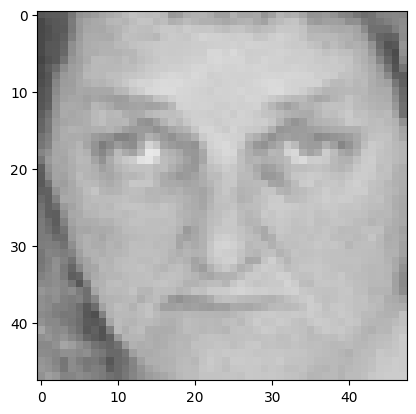

561.0


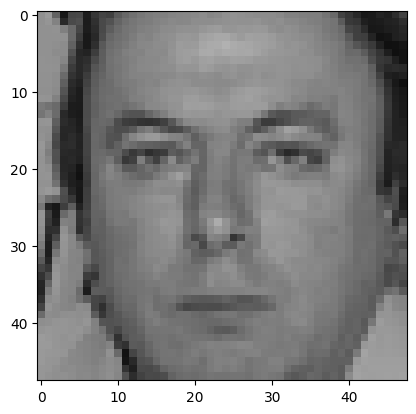

565.0


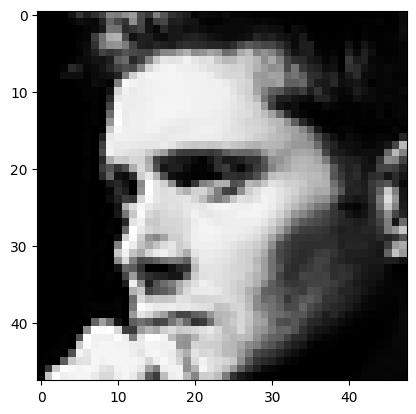

567.0


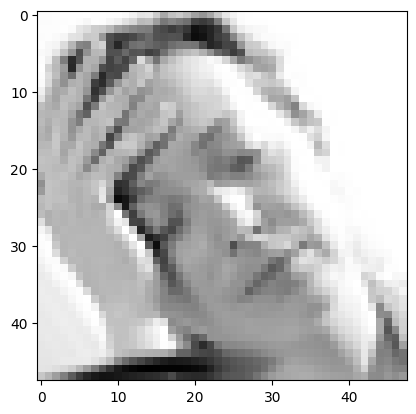

569.0


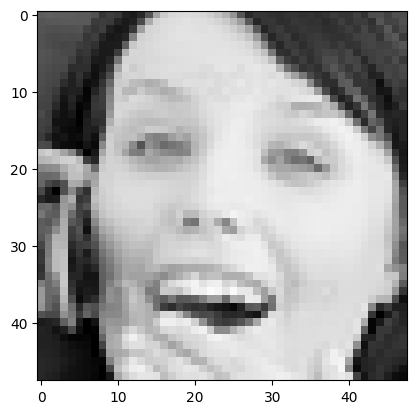

580.0


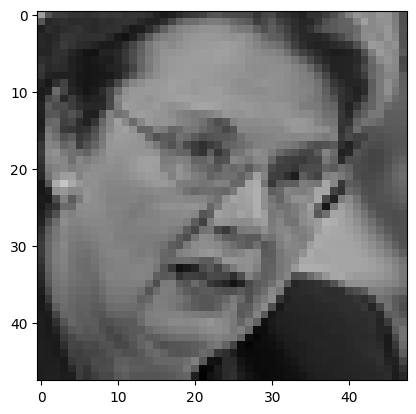

582.0


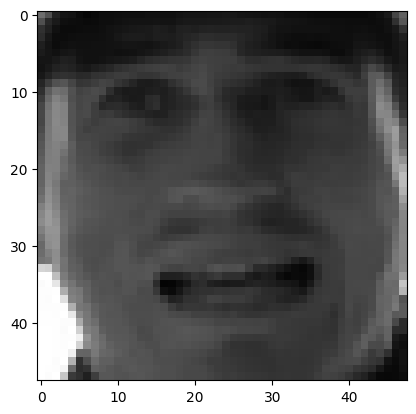

583.0


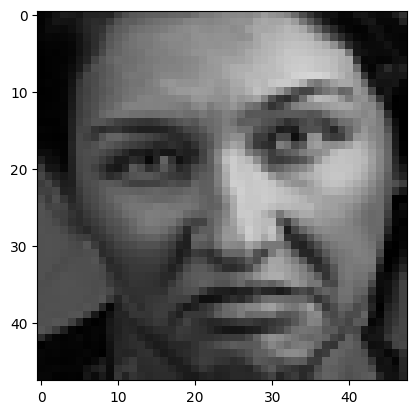

584.0


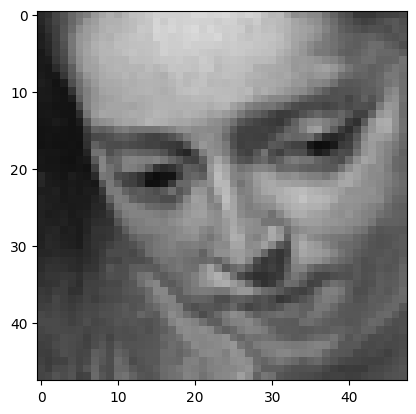

587.0


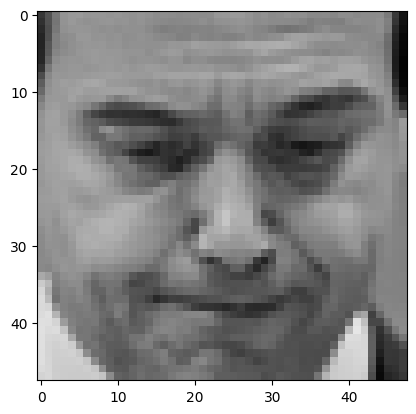

593.0


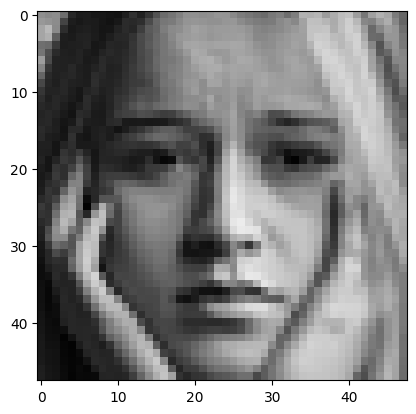

596.0


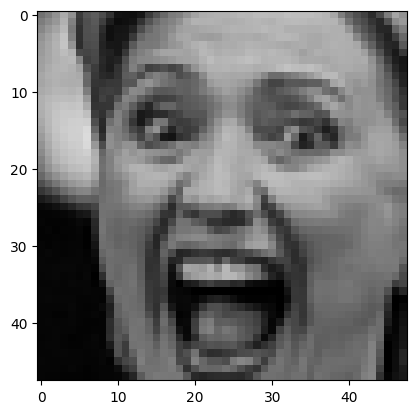

597.0


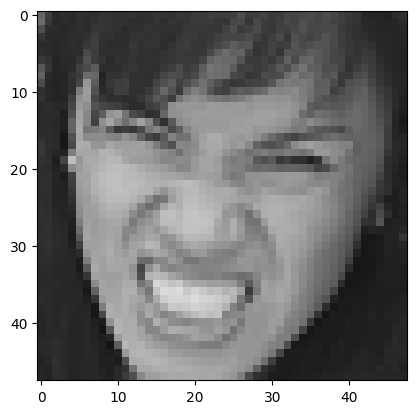

603.0


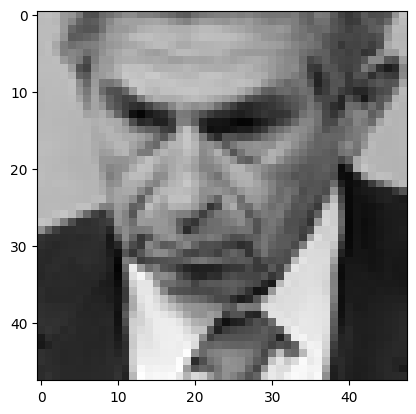

606.0


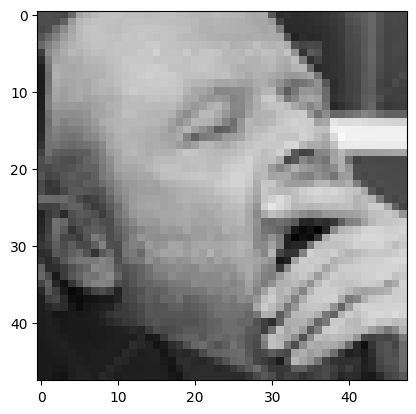

611.0


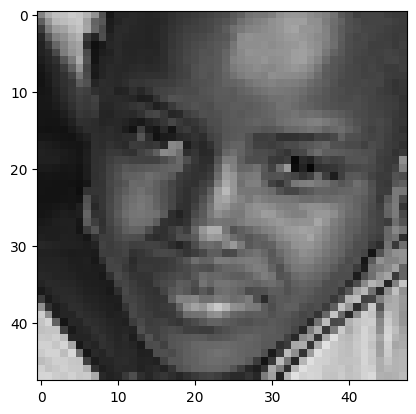

618.0


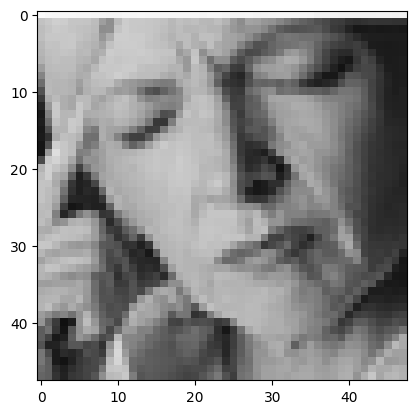

623.0


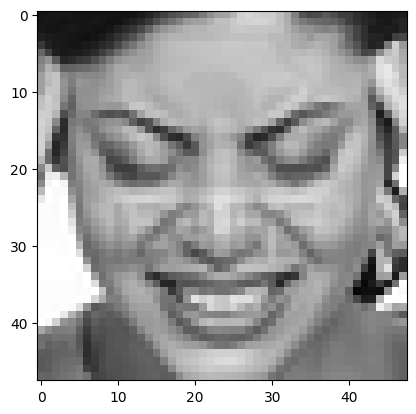

624.0


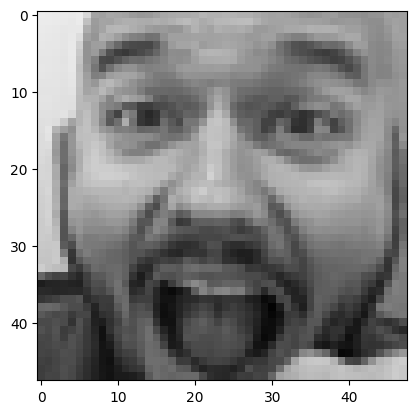

626.0


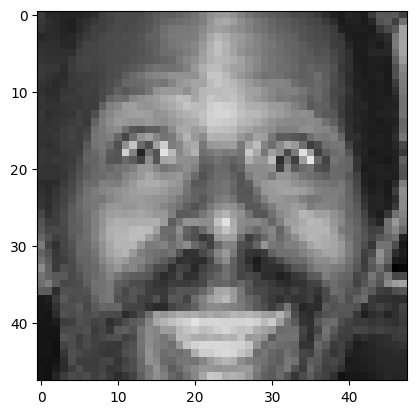

629.0


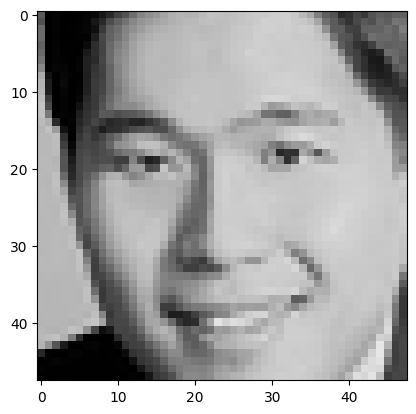

632.0


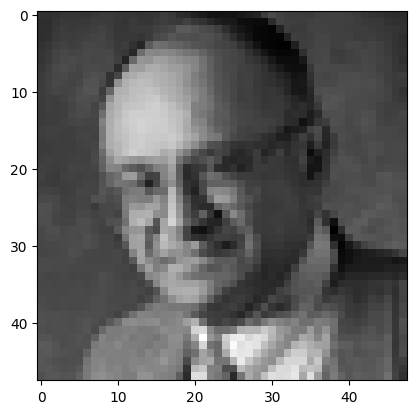

635.0


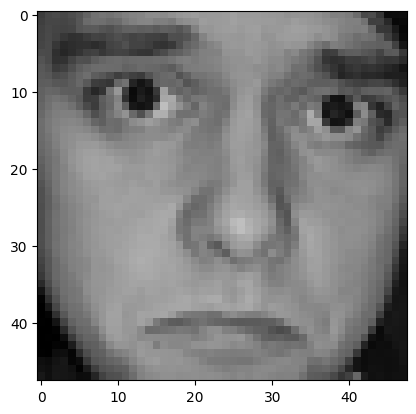

636.0


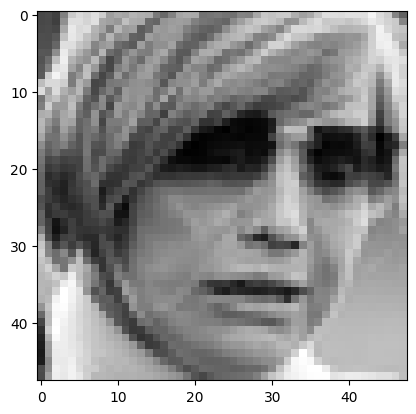

638.0


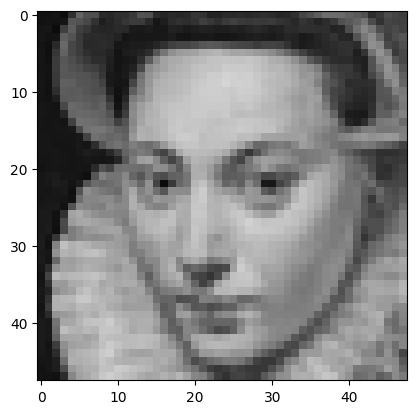

639.0


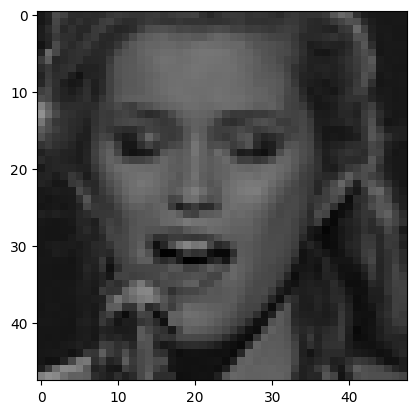

642.0


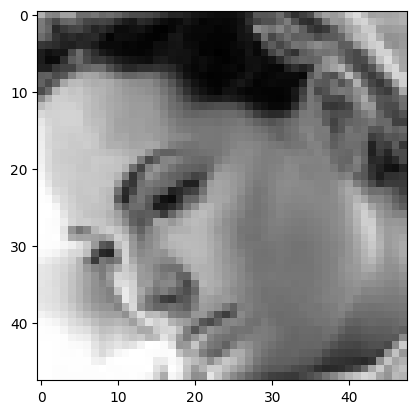

653.0


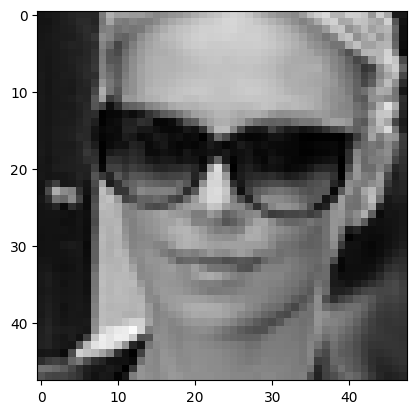

659.0


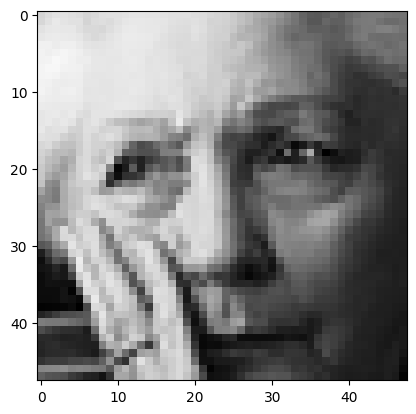

662.0


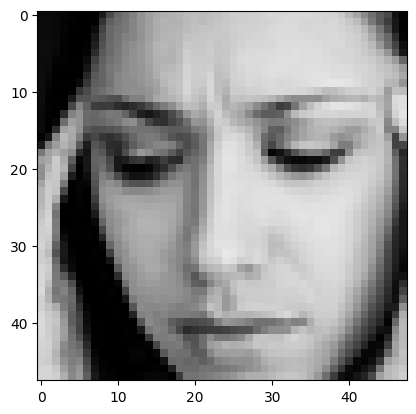

664.0


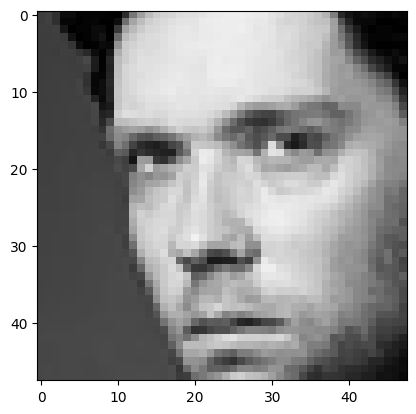

671.0


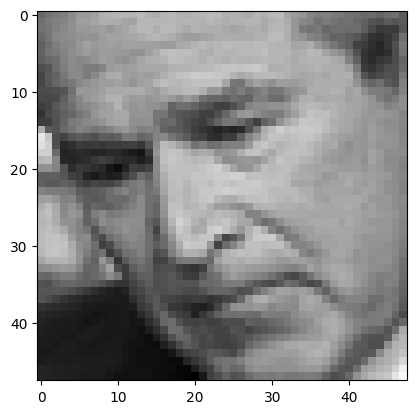

672.0


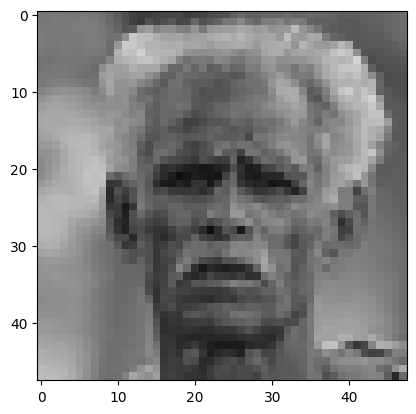

681.0


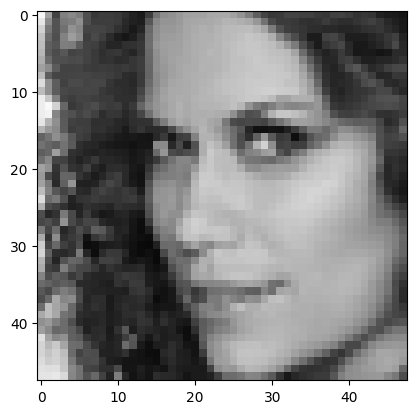

686.0


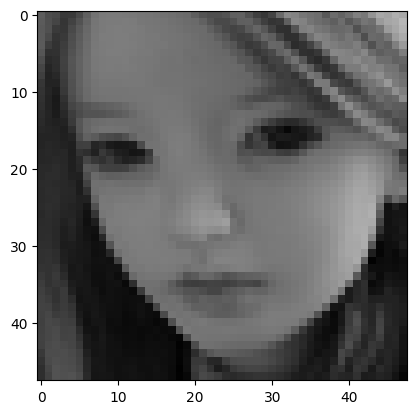

689.0


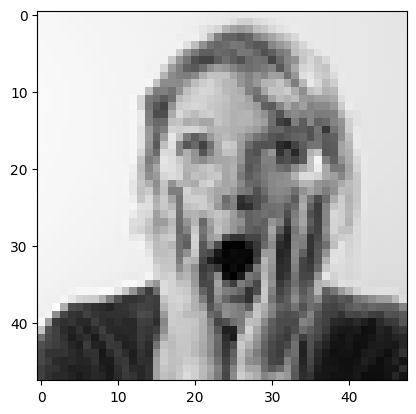

696.0


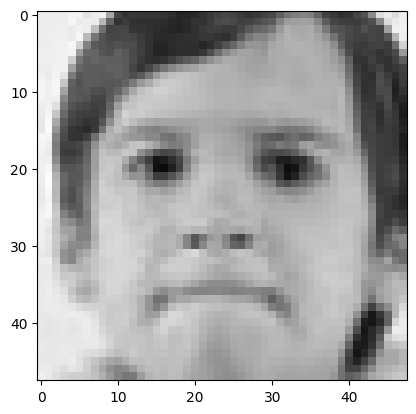

697.0


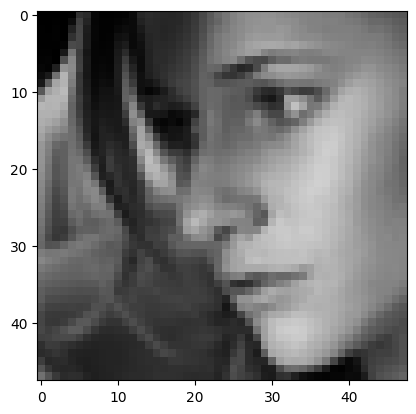

714.0


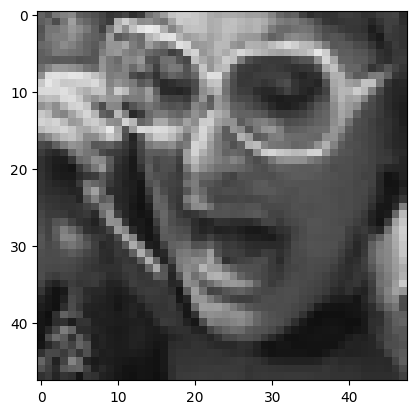

715.0


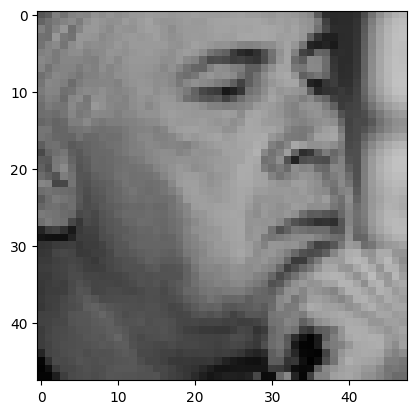

718.0


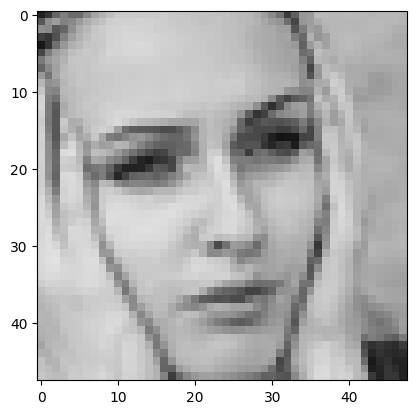

719.0


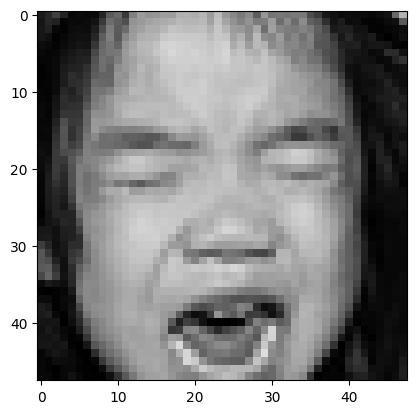

723.0


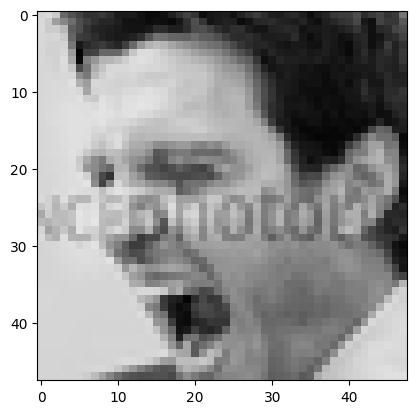

727.0


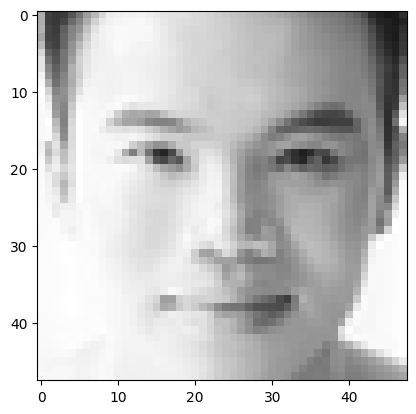

733.0


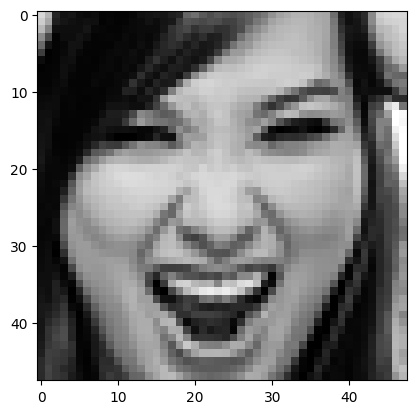

734.0


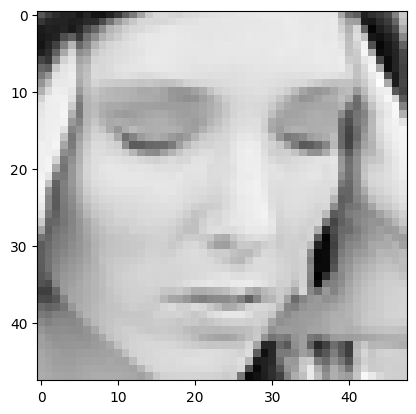

736.0


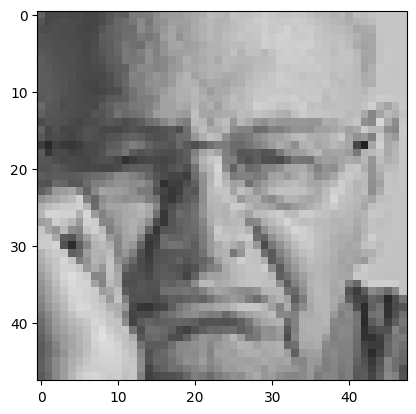

737.0


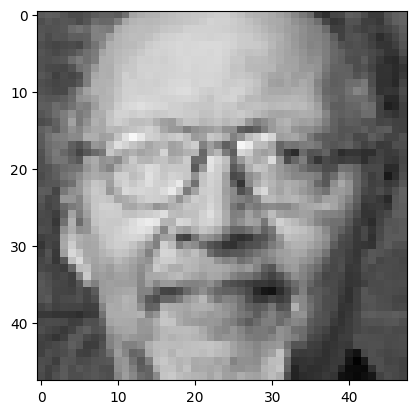

740.0


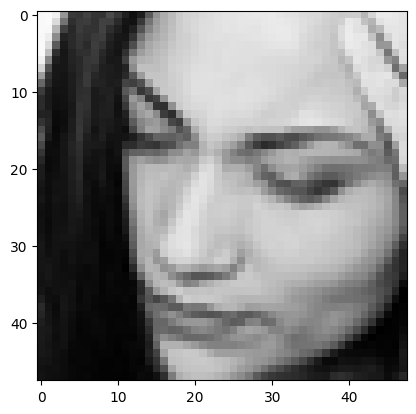

745.0


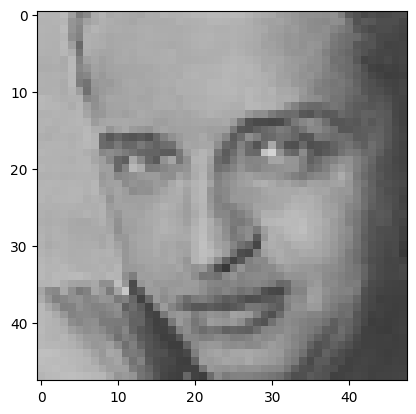

748.0


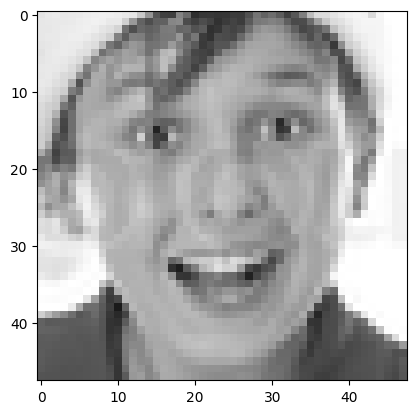

749.0


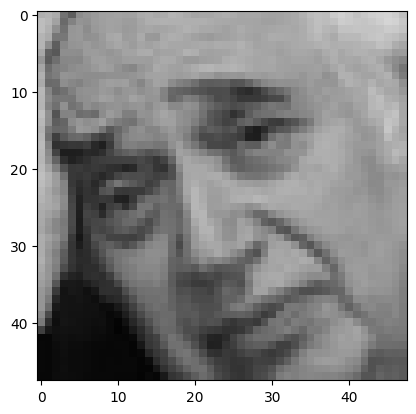

752.0


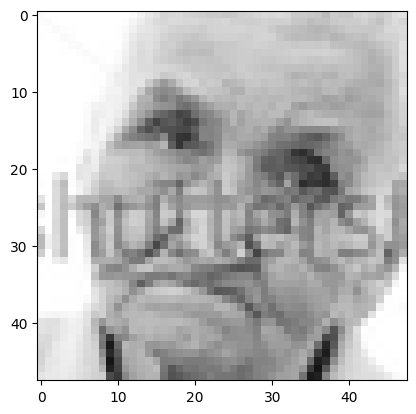

753.0


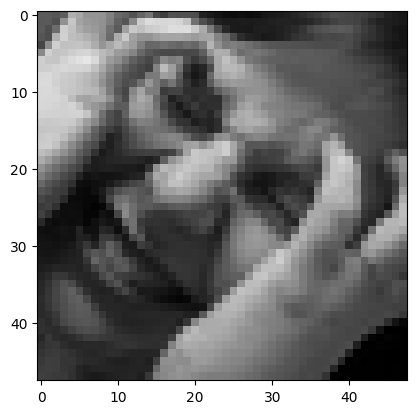

759.0


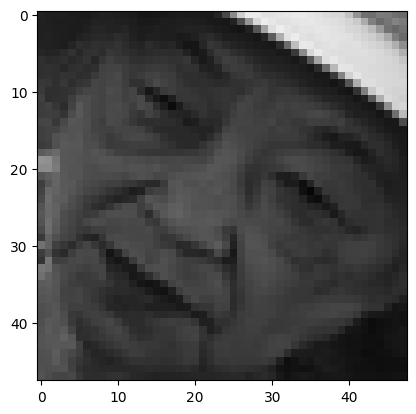

762.0


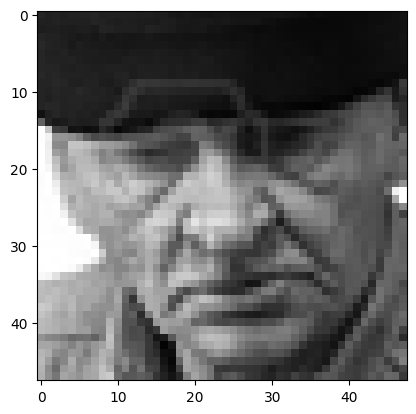

768.0


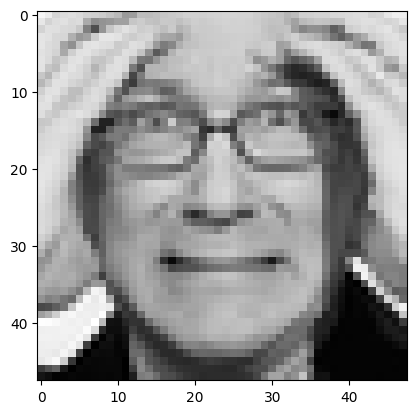

780.0


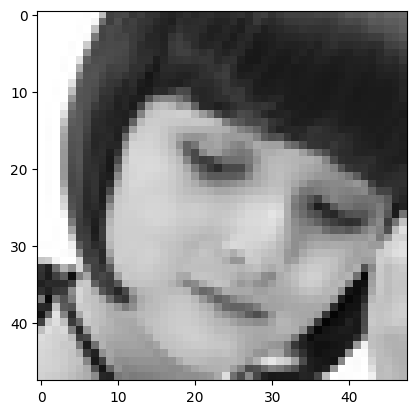

781.0


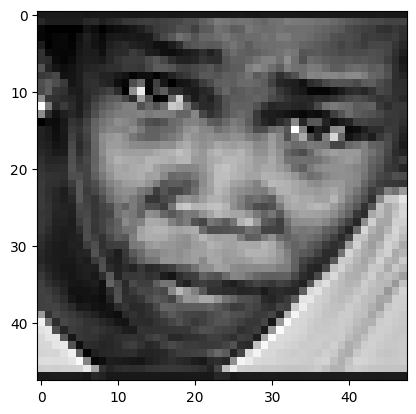

783.0


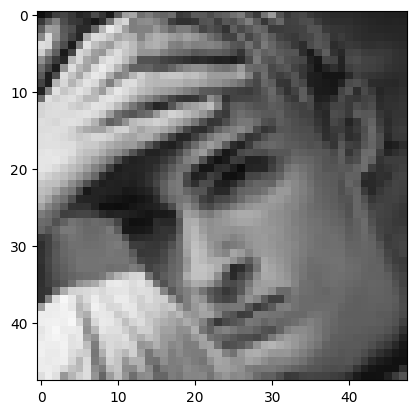

784.0


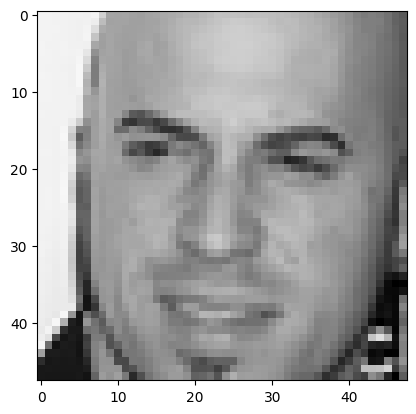

792.0


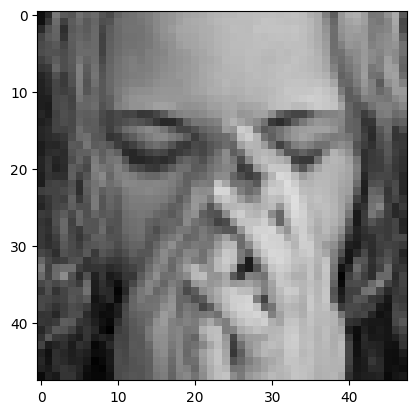

794.0


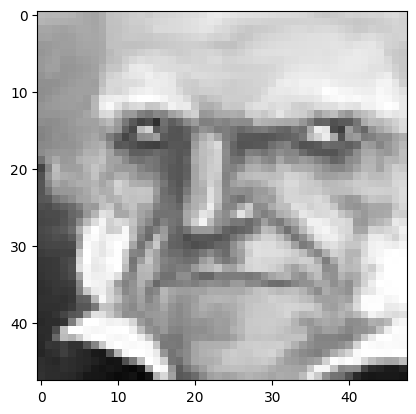

798.0


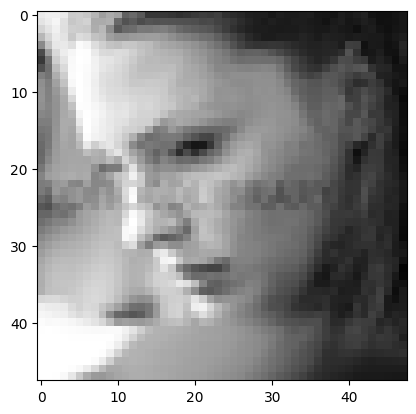

801.0


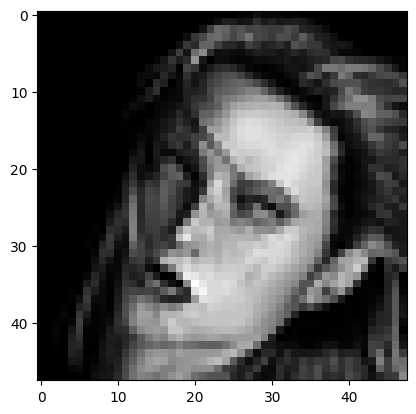

802.0


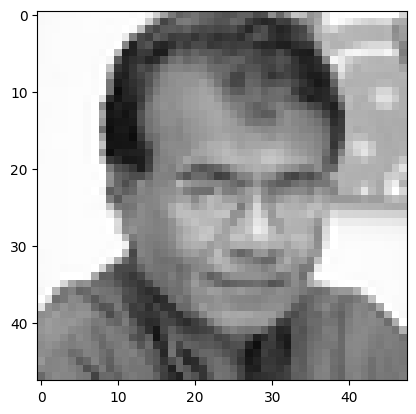

803.0


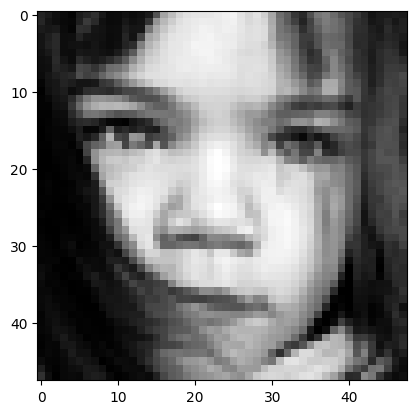

814.0


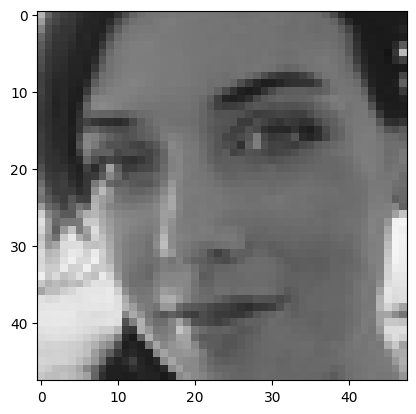

823.0


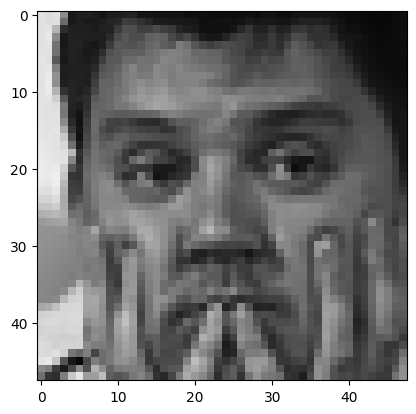

830.0


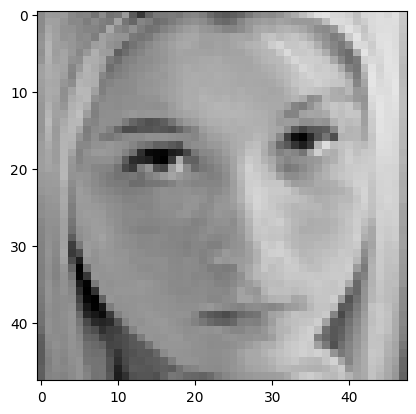

832.0


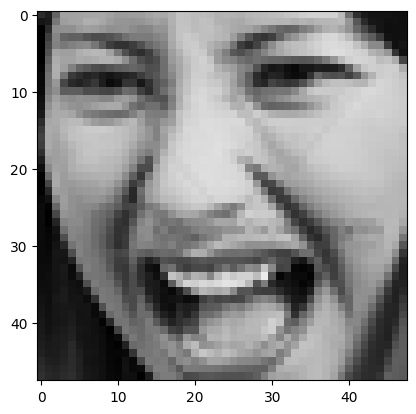

839.0


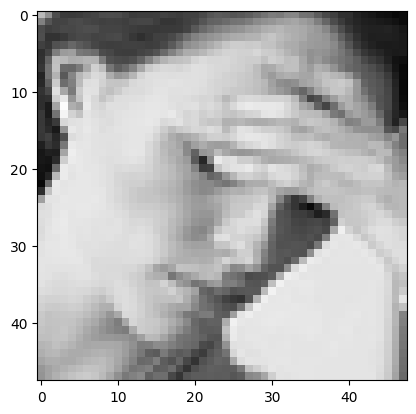

842.0


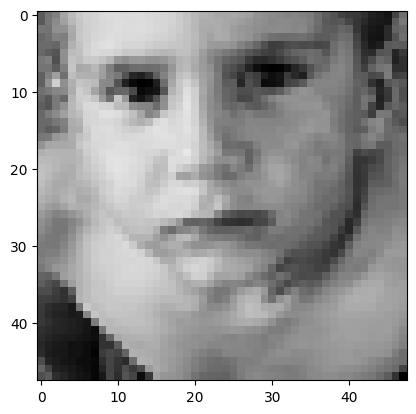

844.0


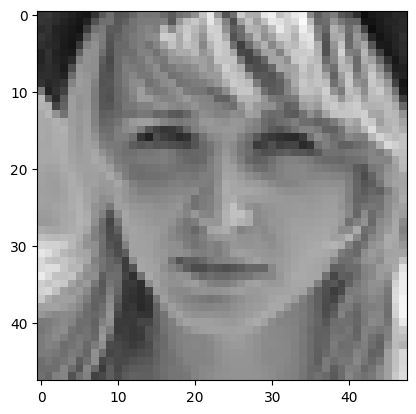

845.0


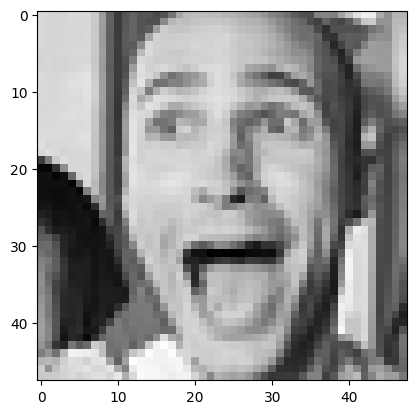

851.0


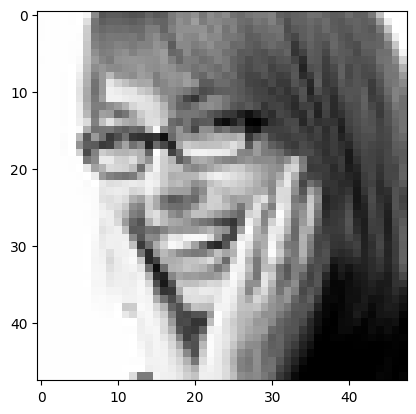

852.0


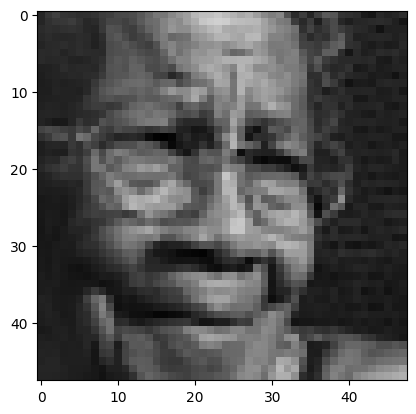

855.0


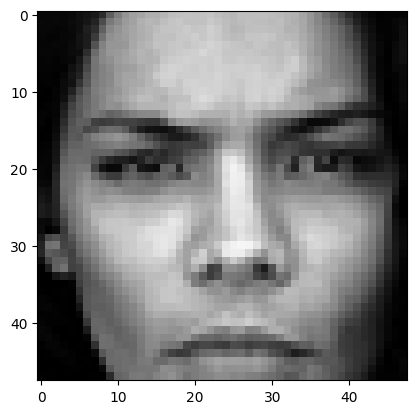

866.0


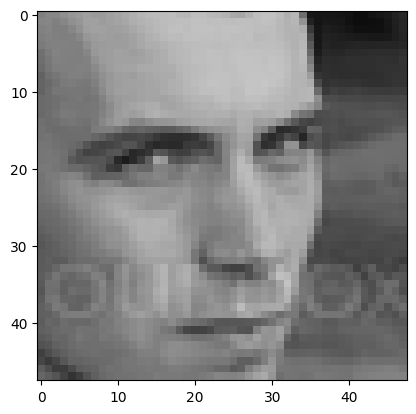

869.0


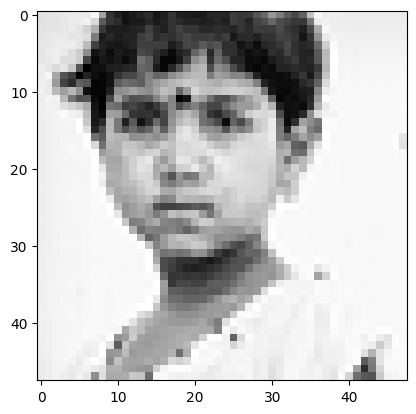

872.0


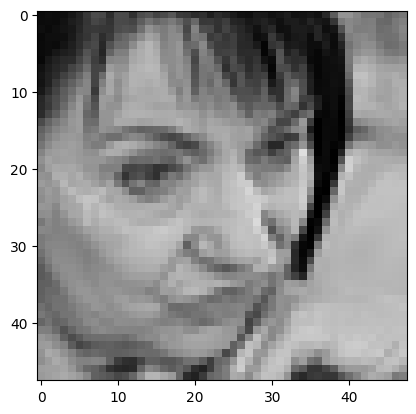

874.0


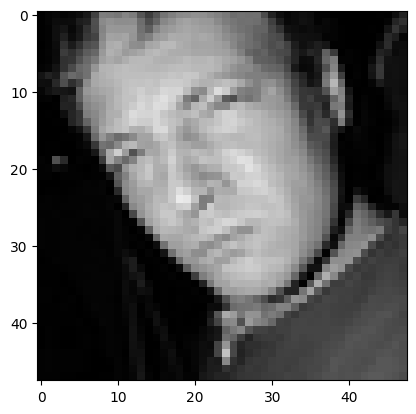

875.0


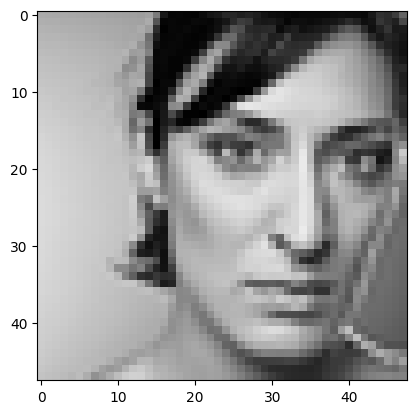

877.0


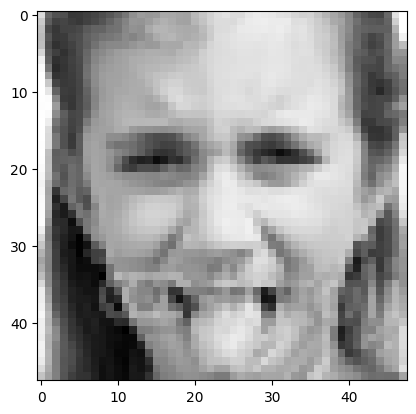

887.0


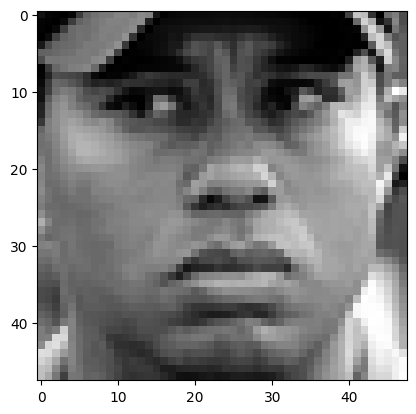

888.0


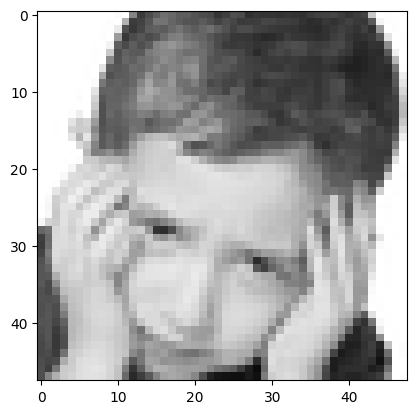

889.0


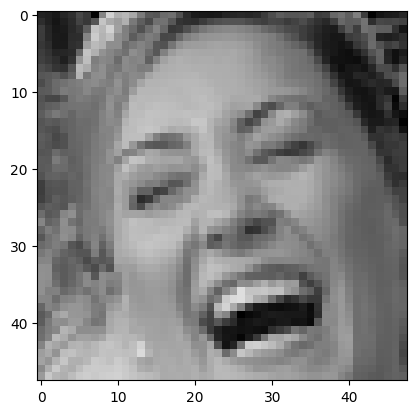

895.0


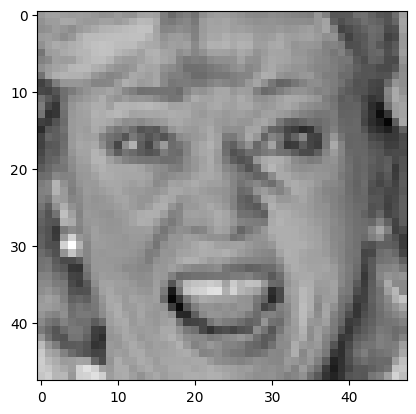

898.0


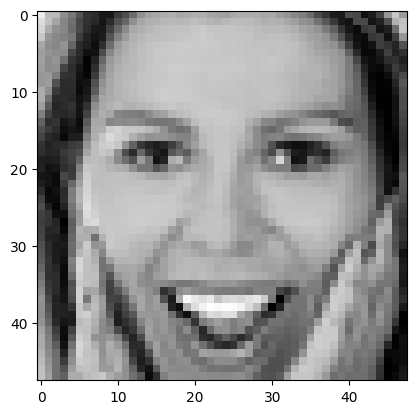

902.0


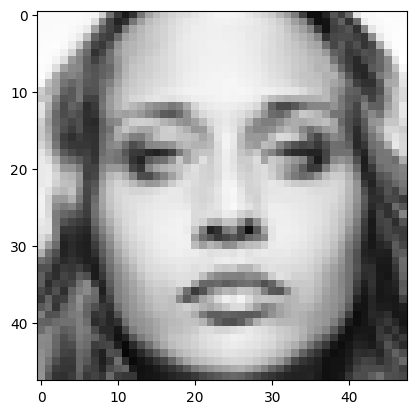

910.0


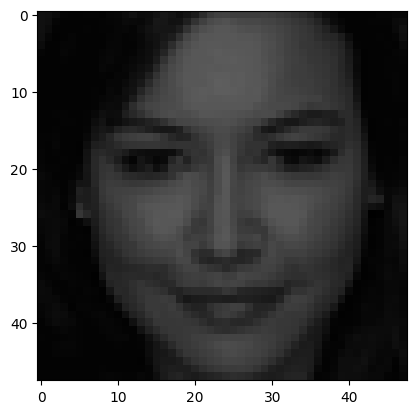

915.0


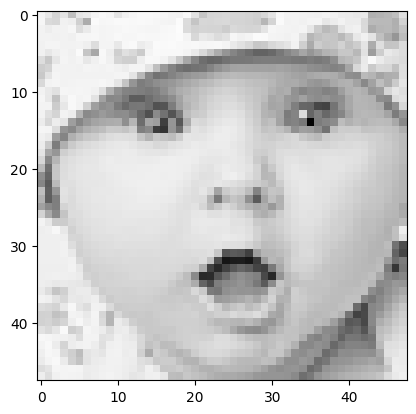

920.0


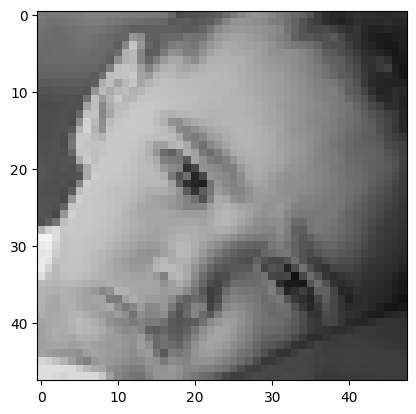

924.0


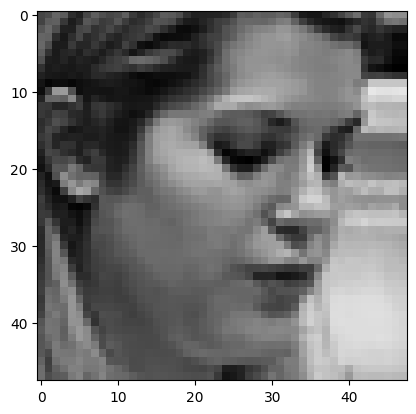

937.0


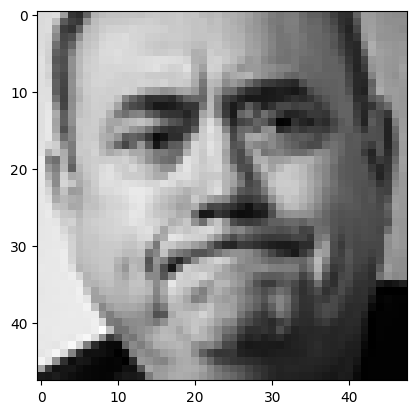

940.0


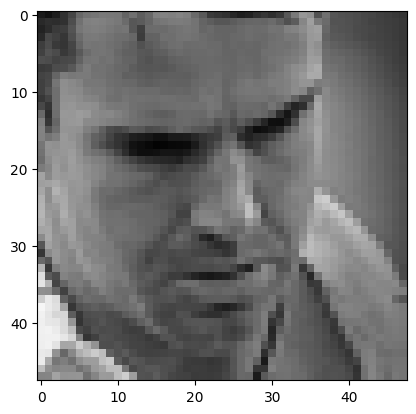

941.0


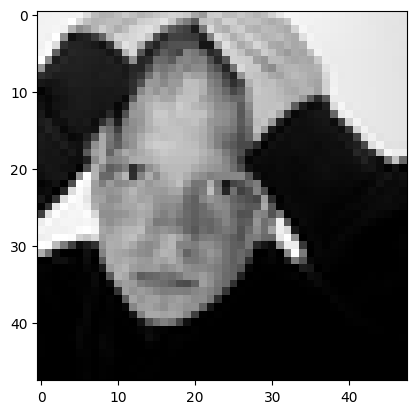

944.0


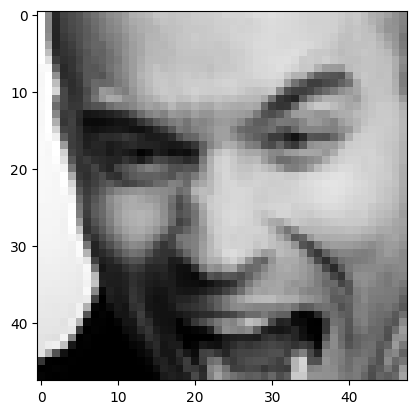

947.0


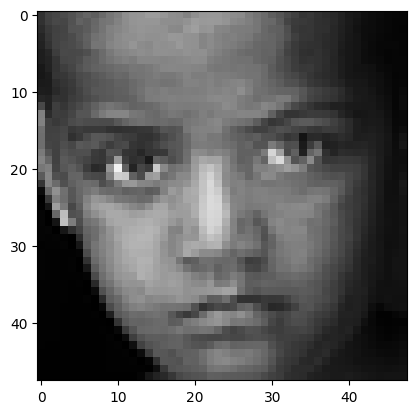

954.0


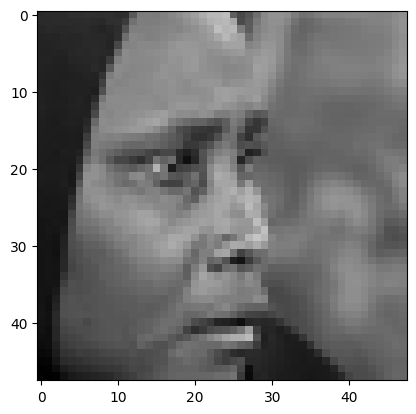

956.0


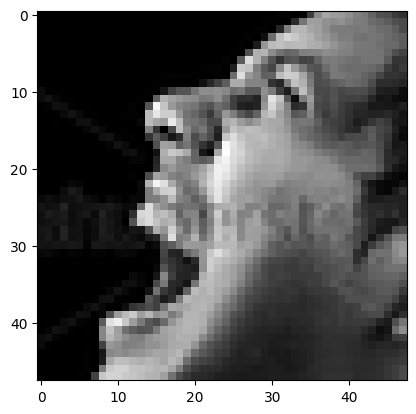

957.0


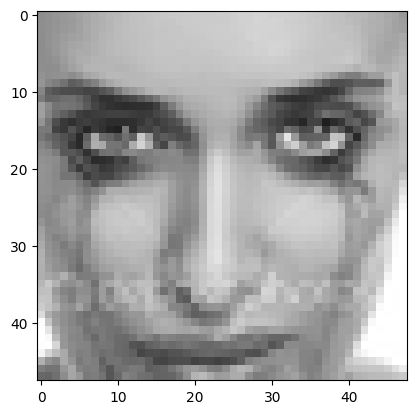

963.0


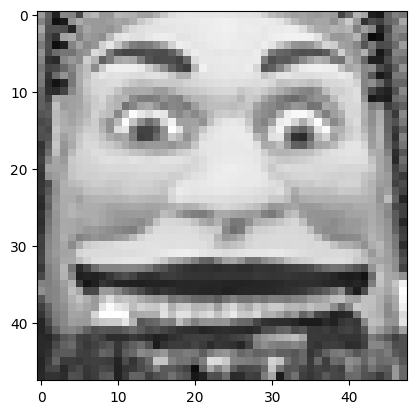

971.0


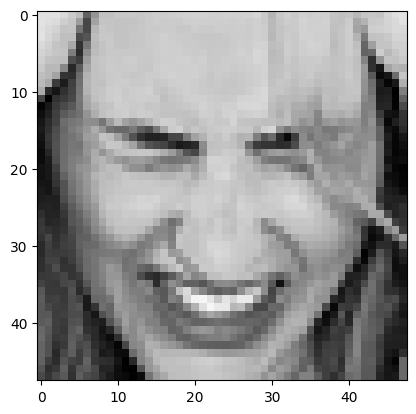

979.0


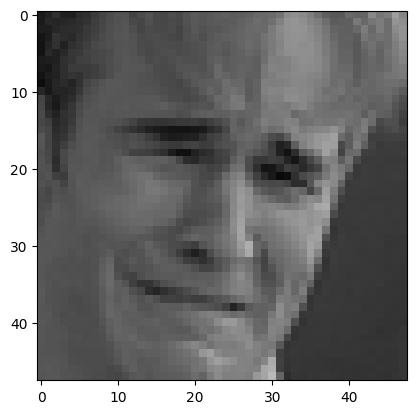

980.0


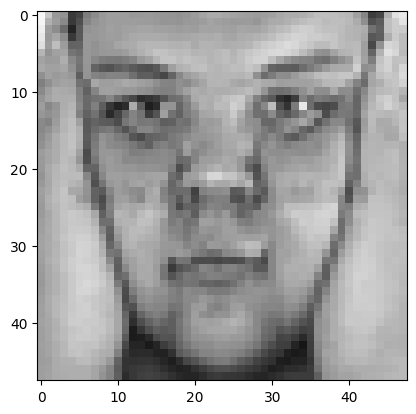

985.0


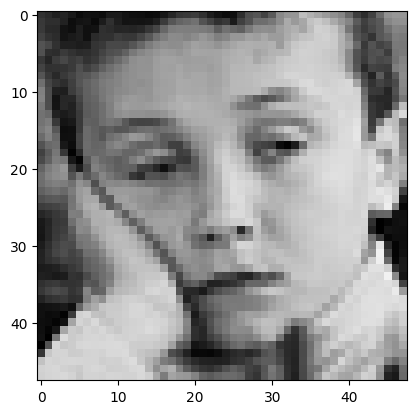

988.0


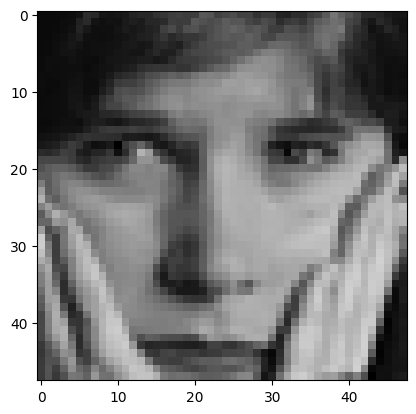

991.0


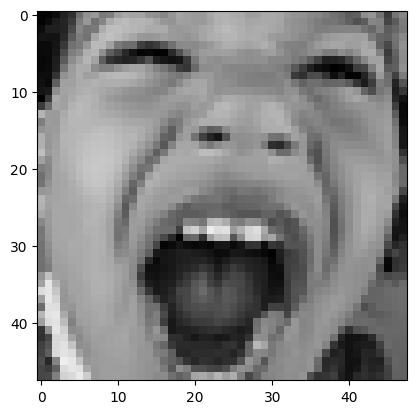

993.0


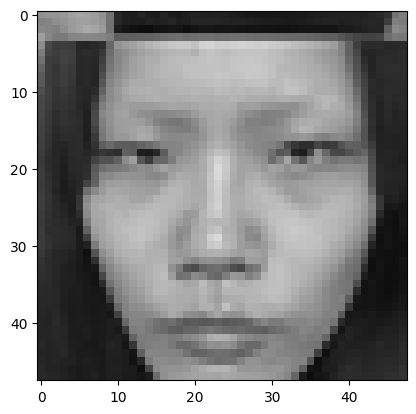

998.0


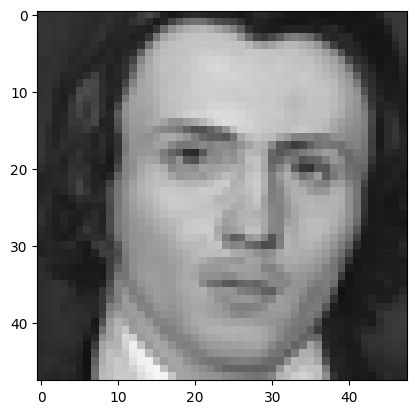

1000.0


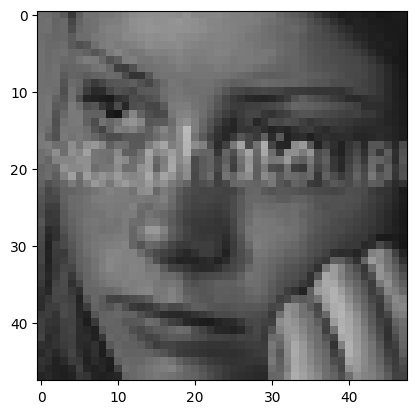

1001.0


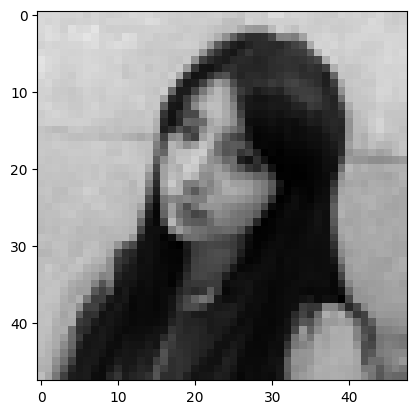

1003.0


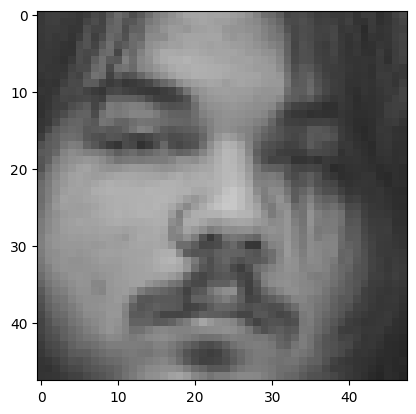

1007.0


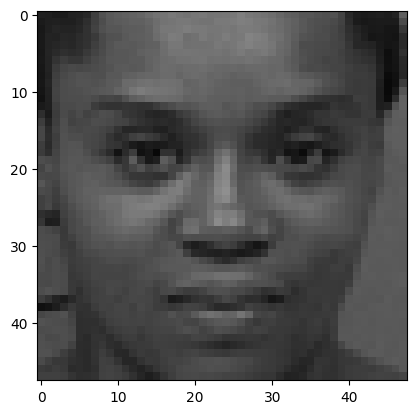

1013.0


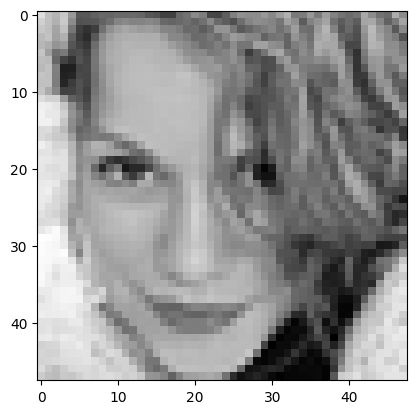

1015.0


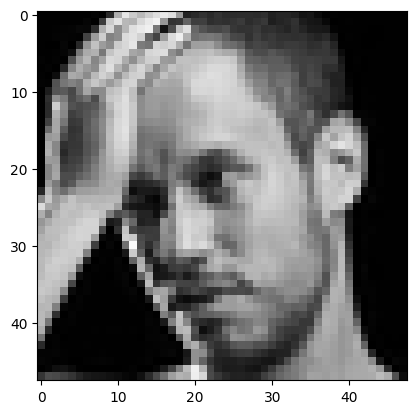

1020.0


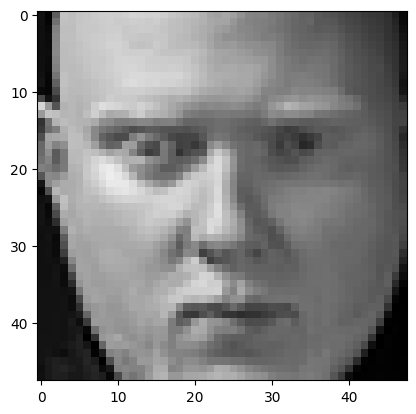

1021.0


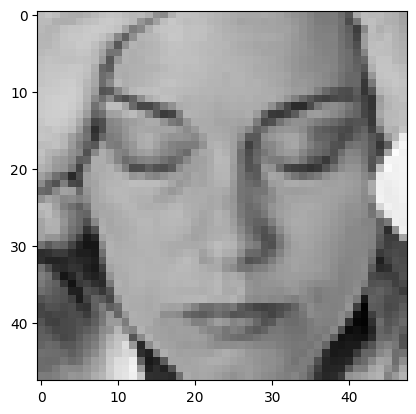

1022.0


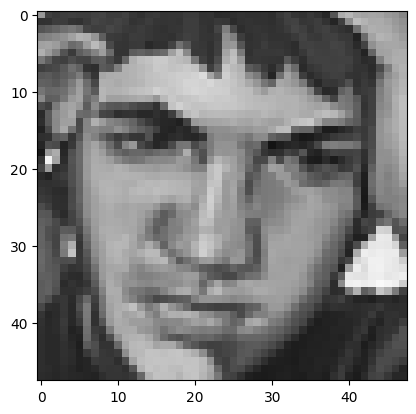

1024.0


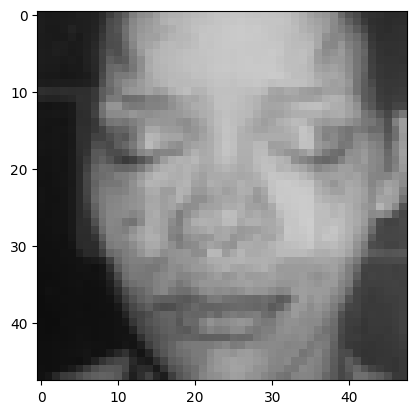

1026.0


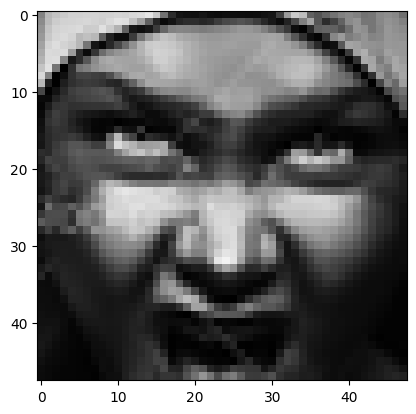

1032.0


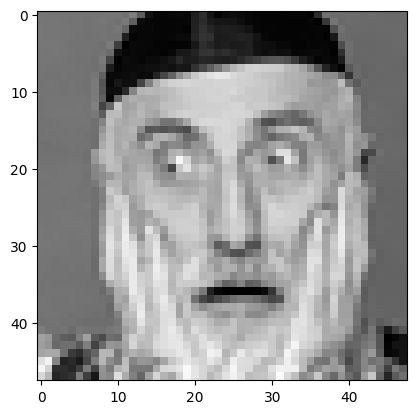

1033.0


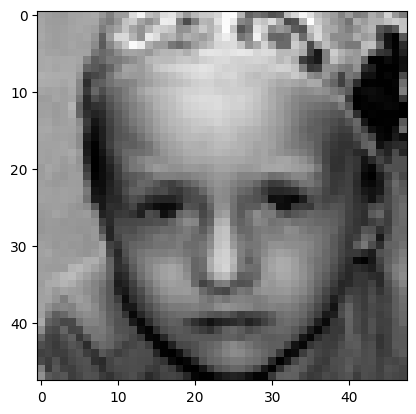

1050.0


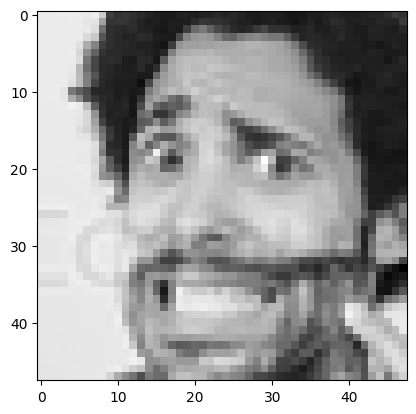

1053.0


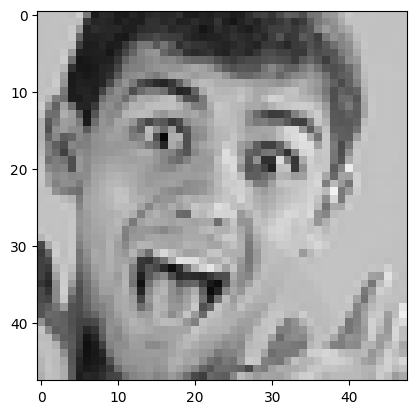

1054.0


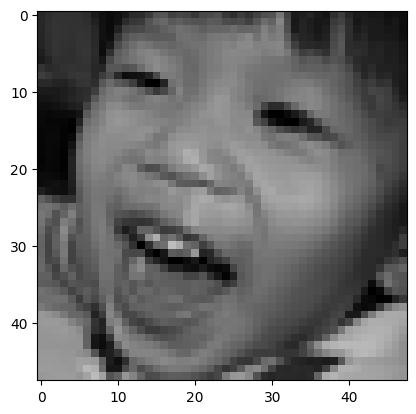

1056.0


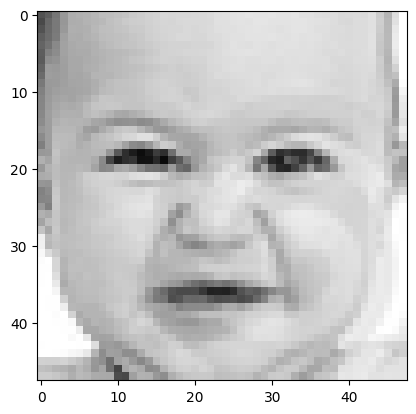

1057.0


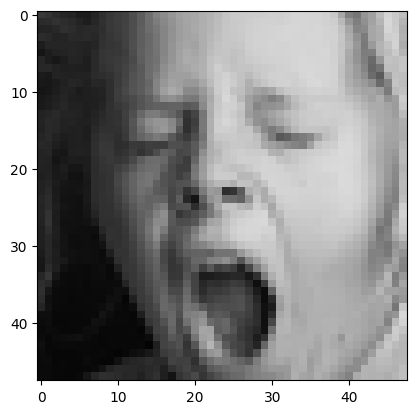

1066.0


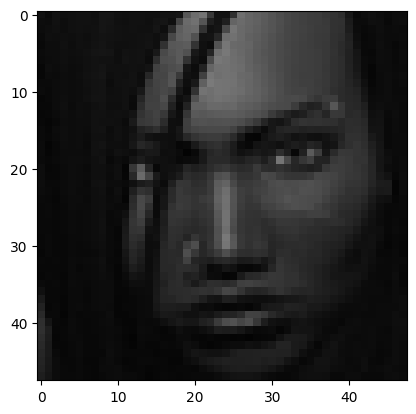

1068.0


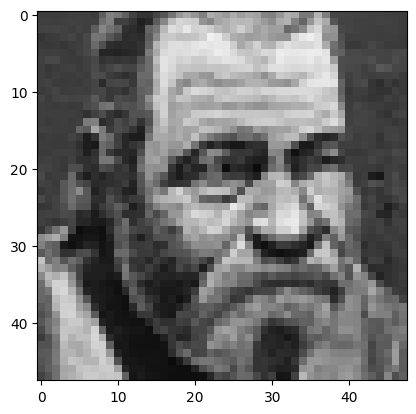

1070.0


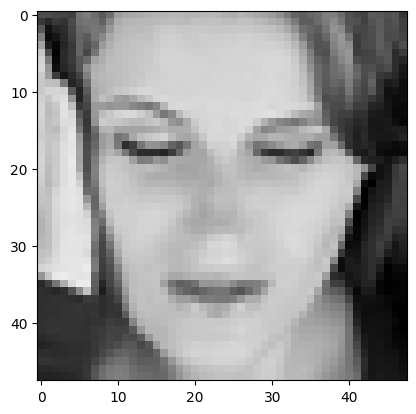

1074.0


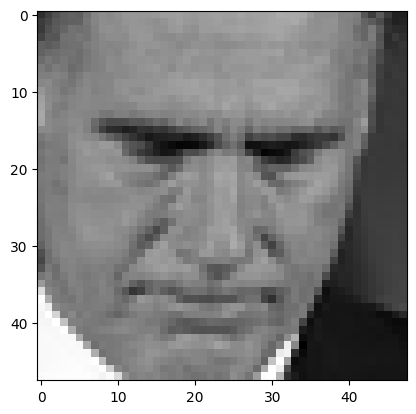

1081.0


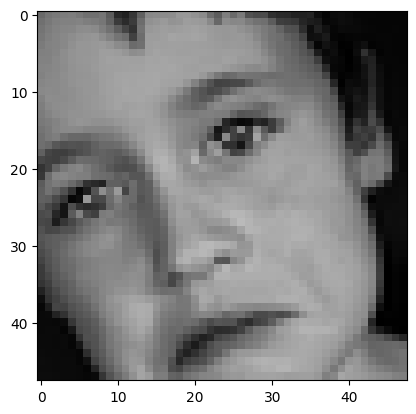

1082.0


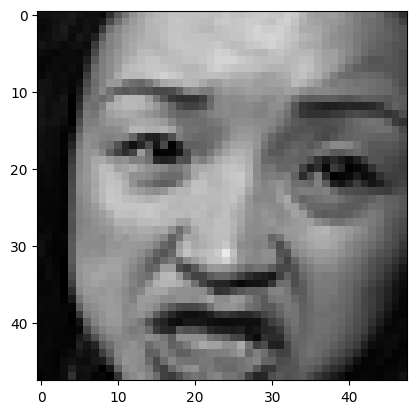

1084.0


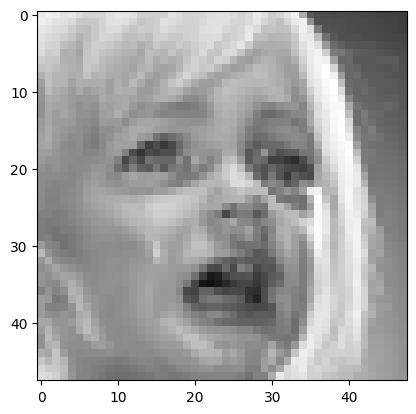

1087.0


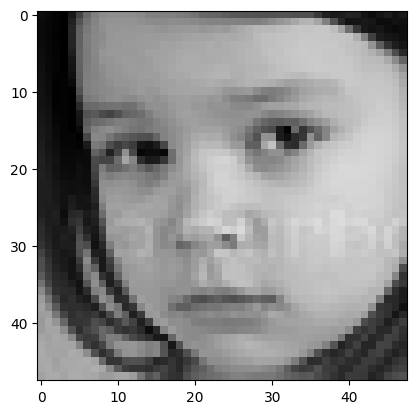

1089.0


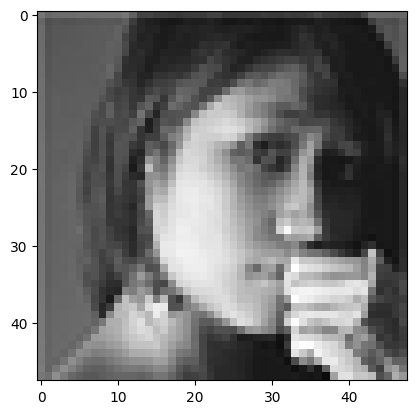

1092.0


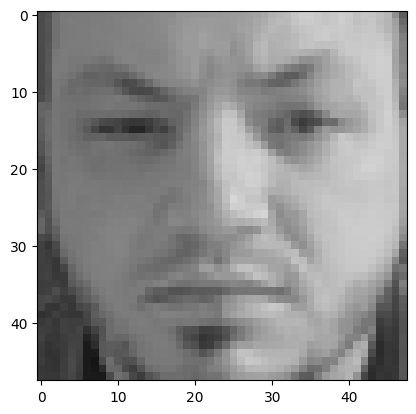

1094.0


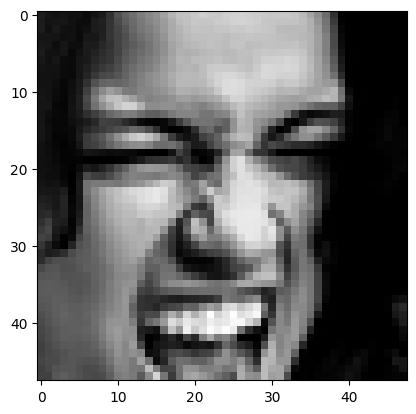

1095.0


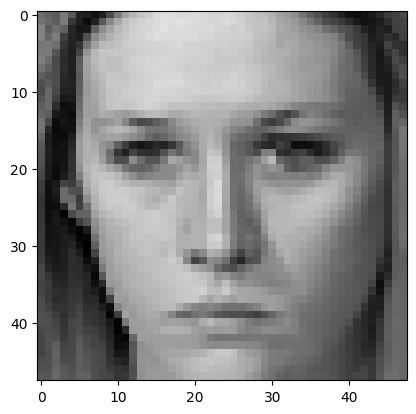

1097.0


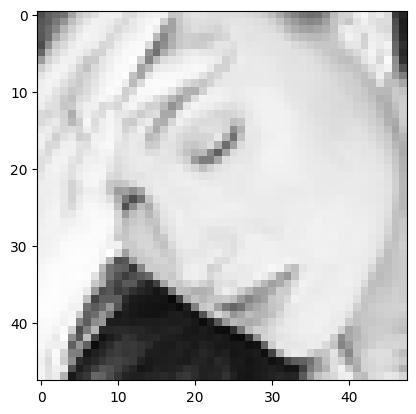

1098.0


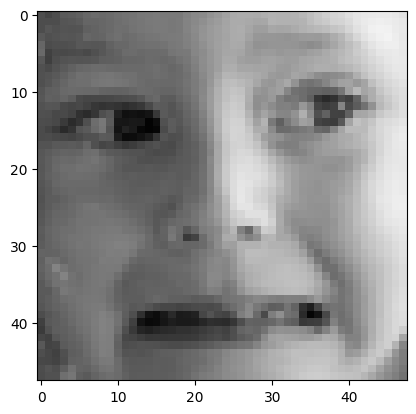

1099.0


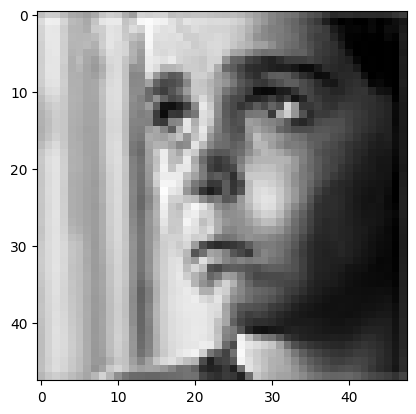

1101.0


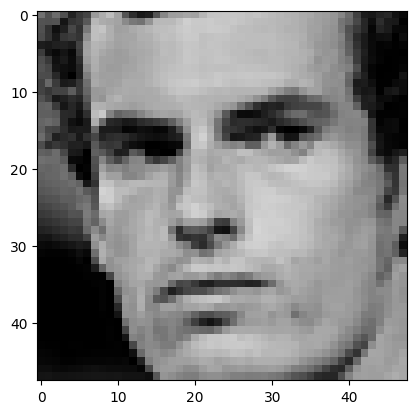

1102.0


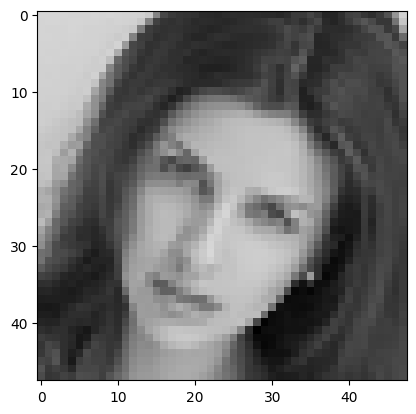

1103.0


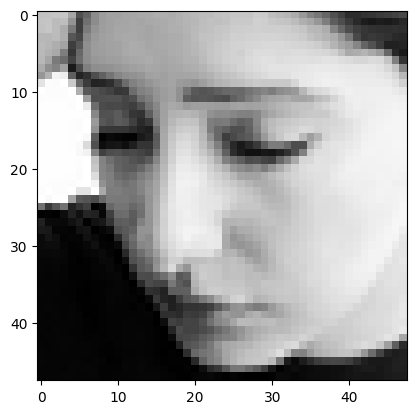

1105.0


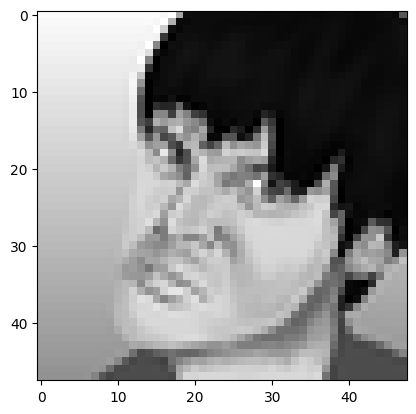

1112.0


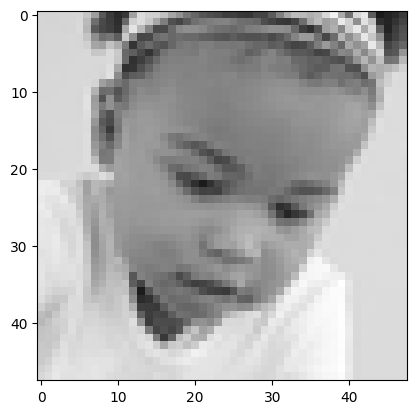

1115.0


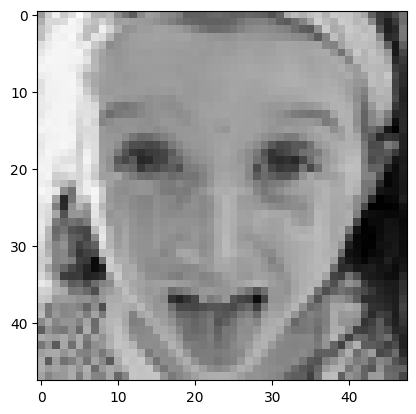

1119.0


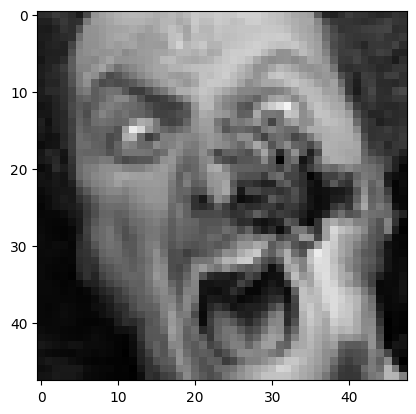

1121.0


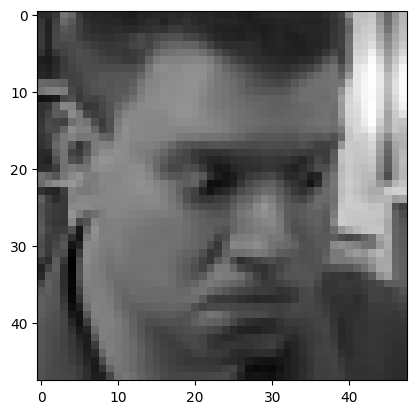

1124.0


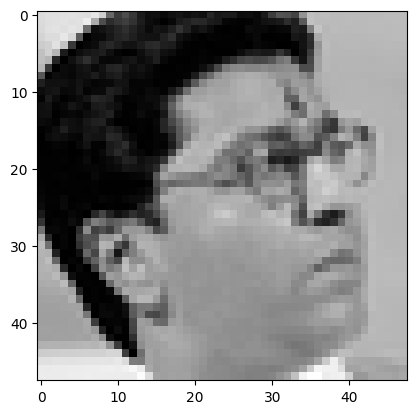

1125.0


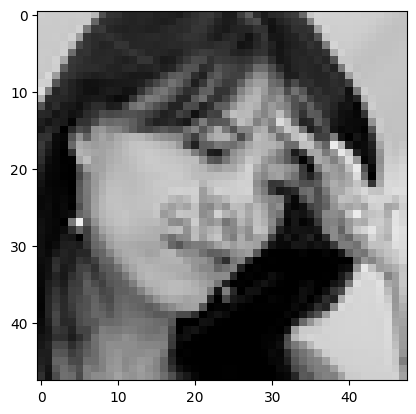

1126.0


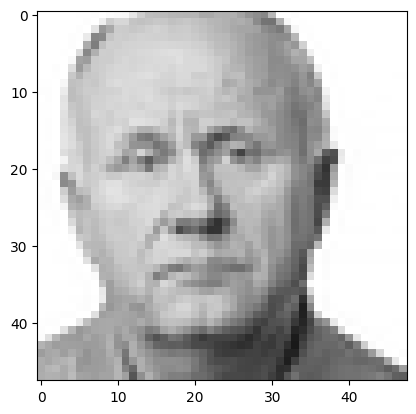

1128.0


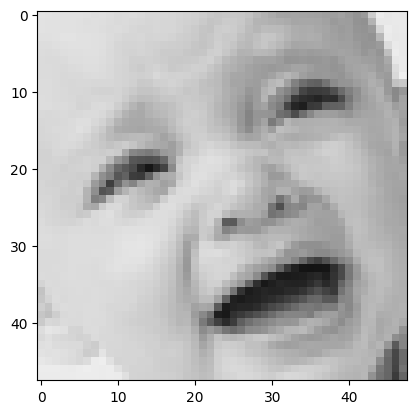

1136.0


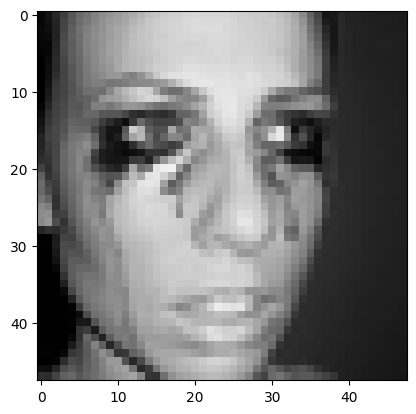

1138.0


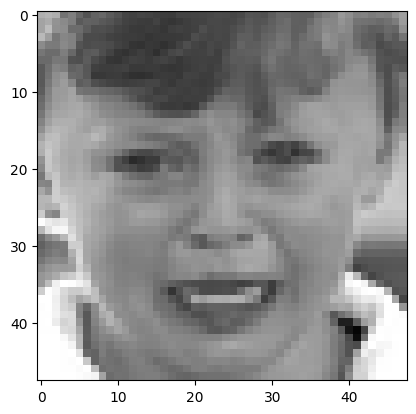

1141.0


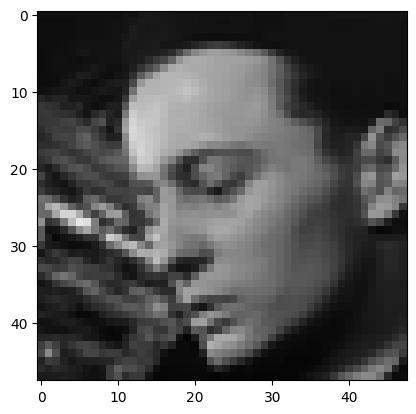

1144.0


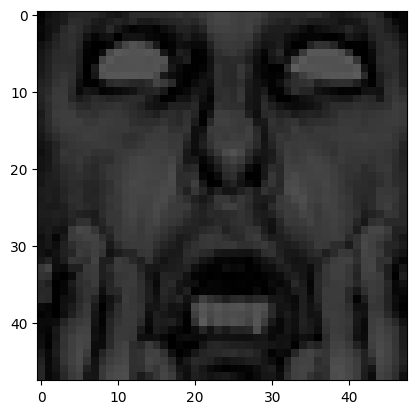

1145.0


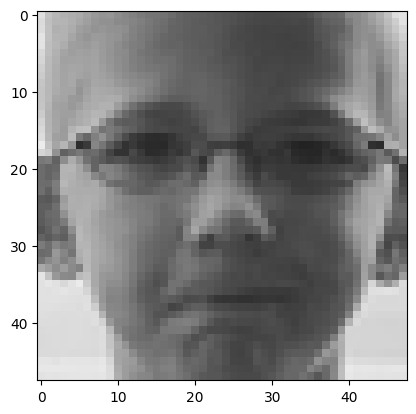

1147.0


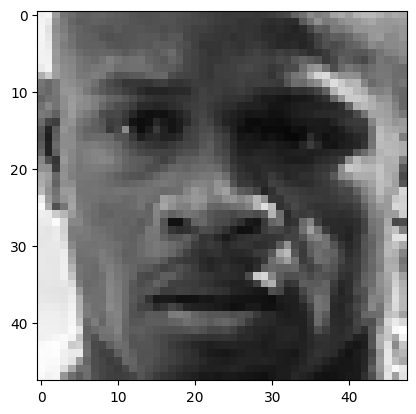

1149.0


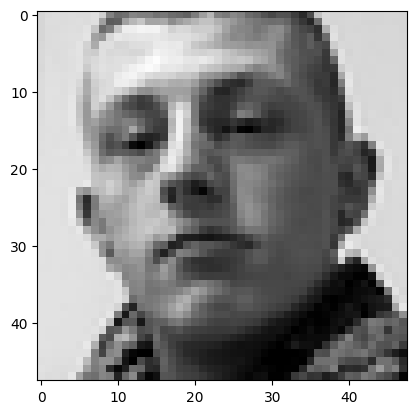

1150.0


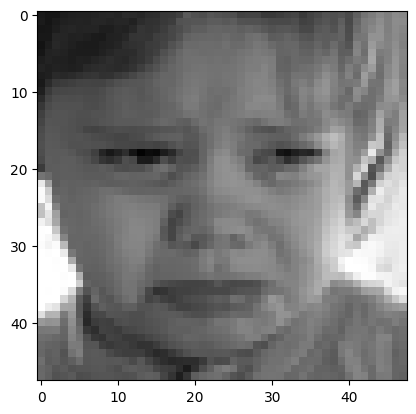

1152.0


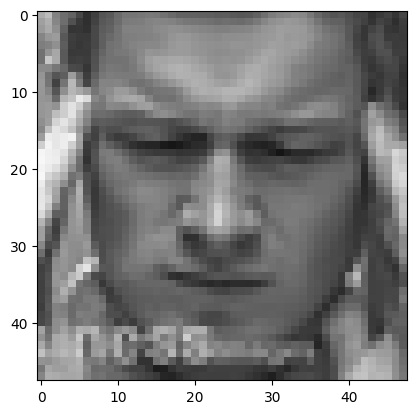

1154.0


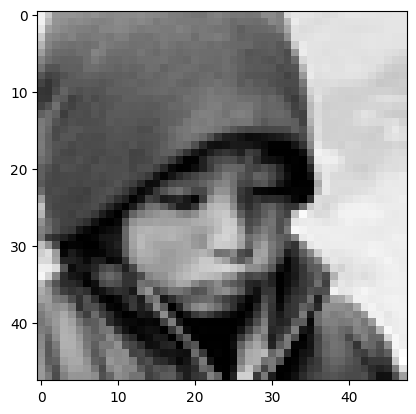

1155.0


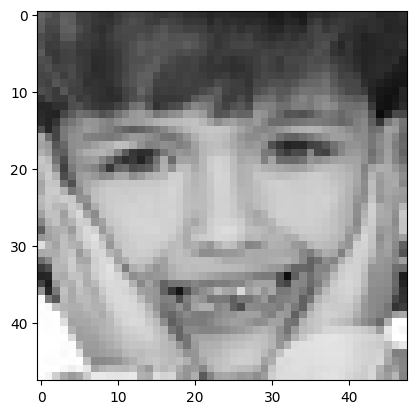

1159.0


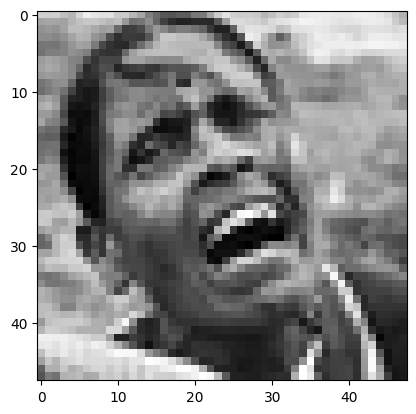

1162.0


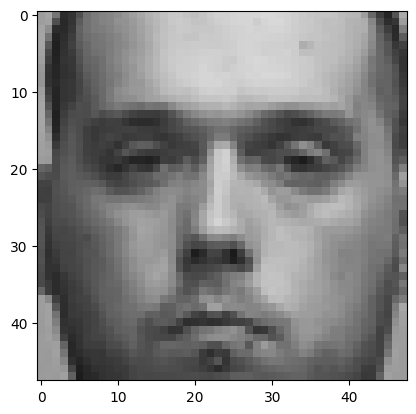

1163.0


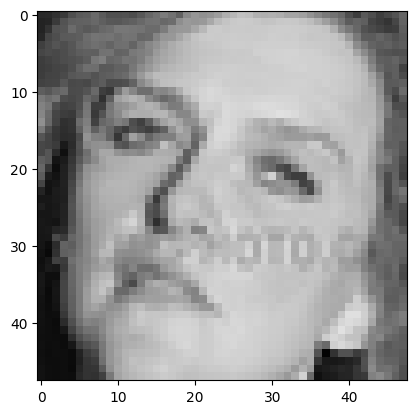

1171.0


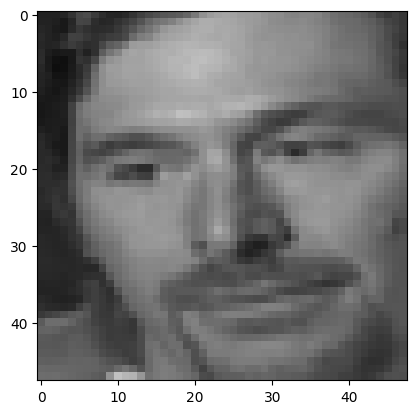

1172.0


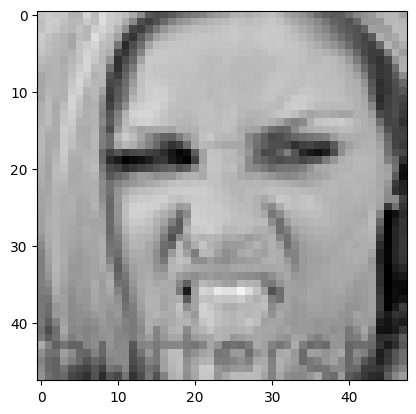

1174.0


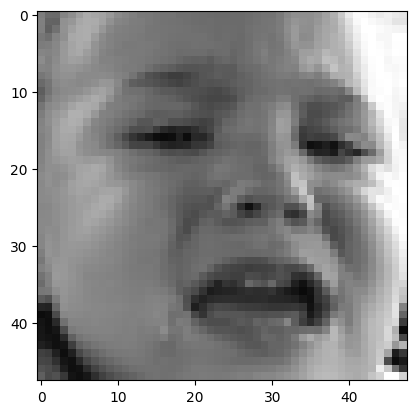

1185.0


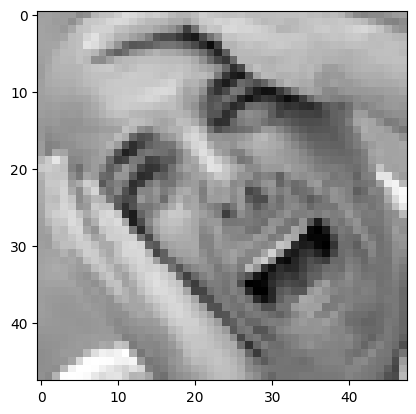

1186.0


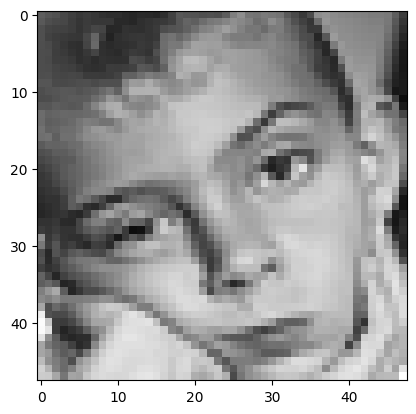

1189.0


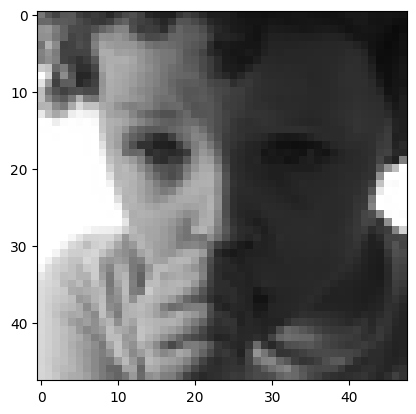

1196.0


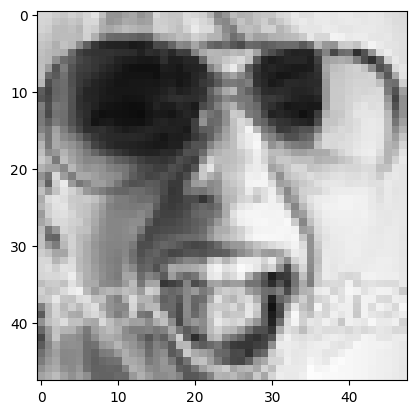

1209.0


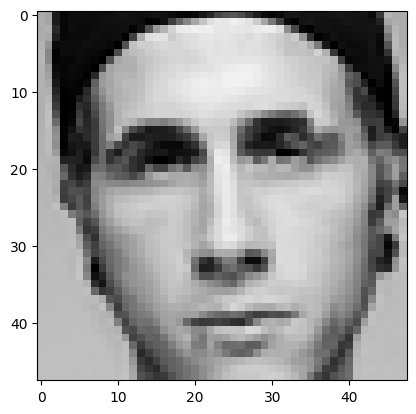

1212.0


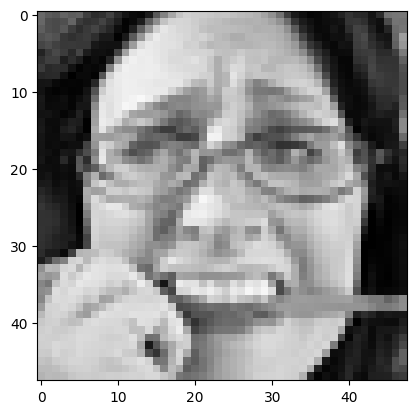

1213.0


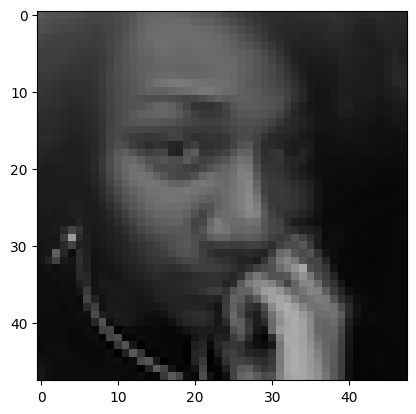

1215.0


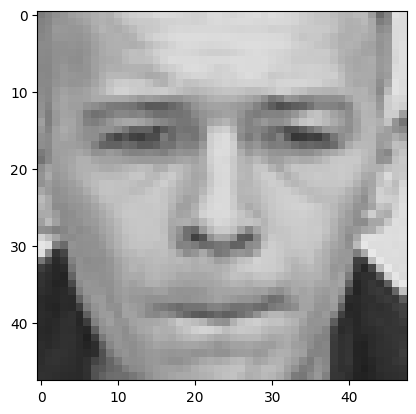

1217.0


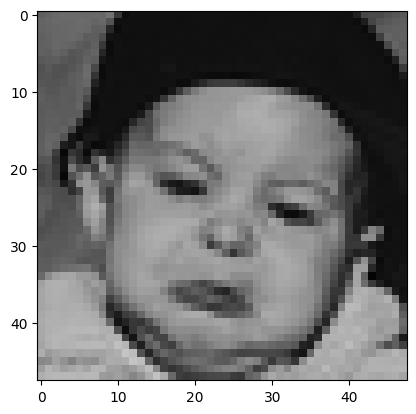

1222.0


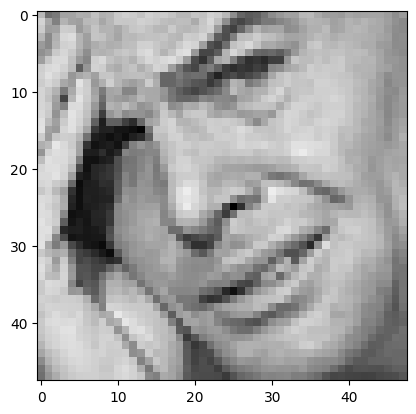

1224.0


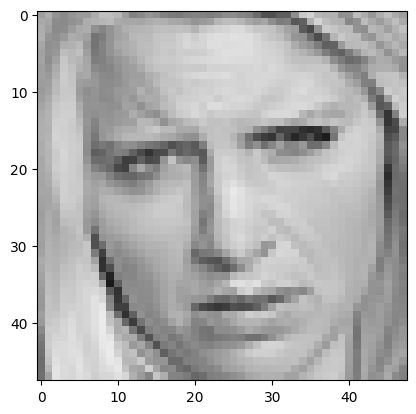

1225.0


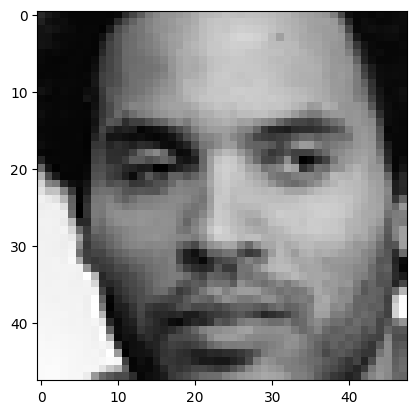

1226.0


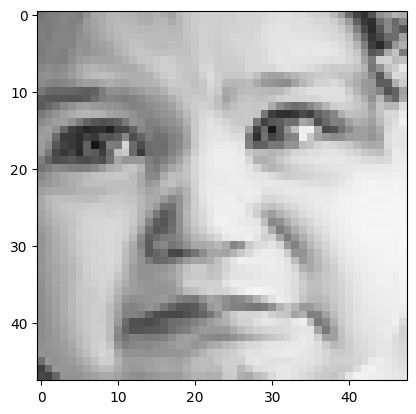

1231.0


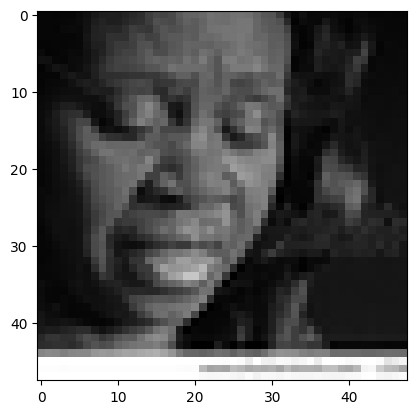

1232.0


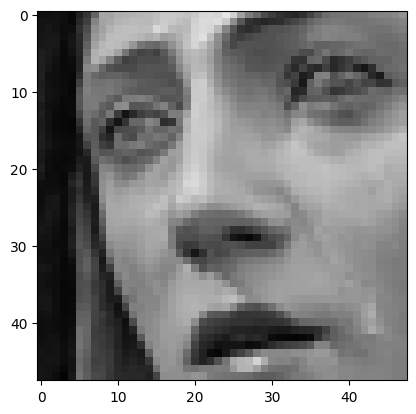

1235.0


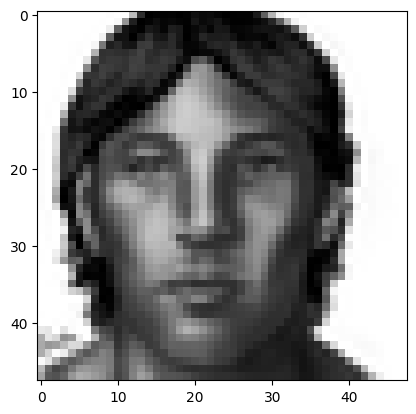

1236.0


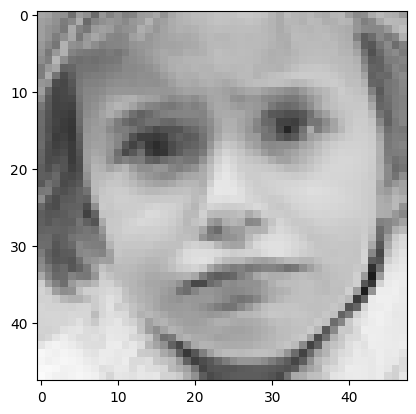

1240.0


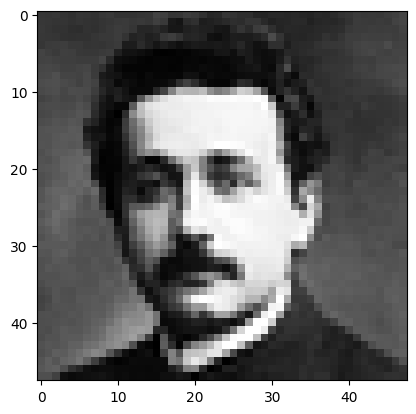

1243.0


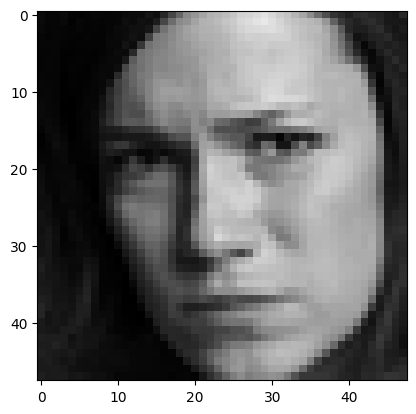

1248.0


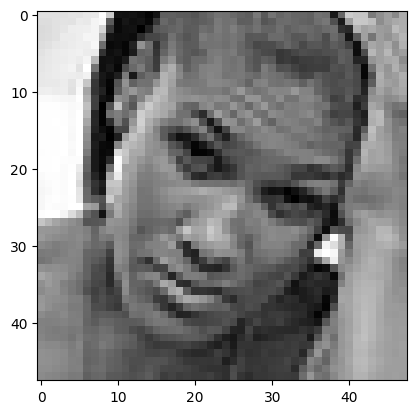

1250.0


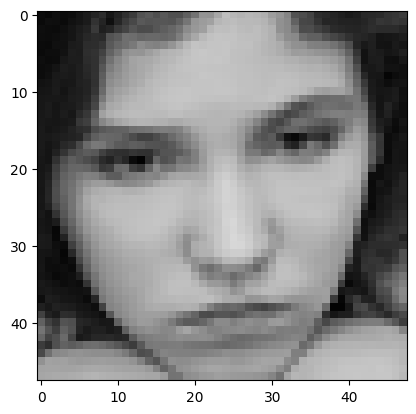

1254.0


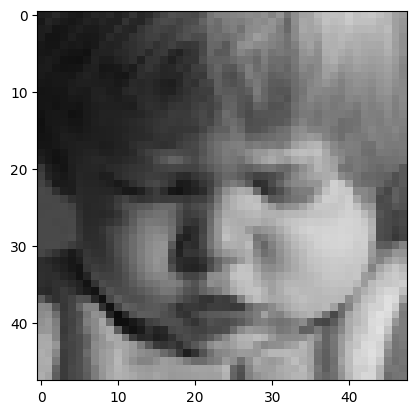

1256.0


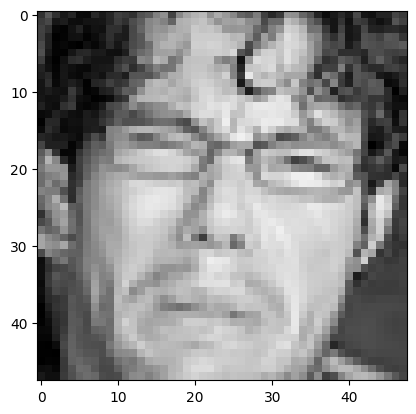

1258.0


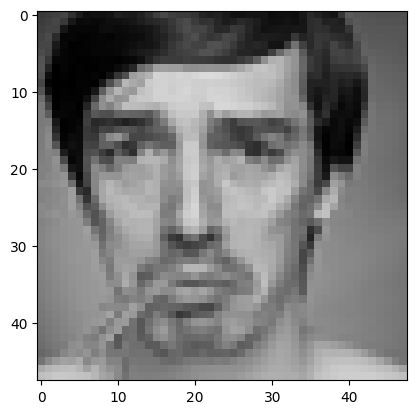

1260.0


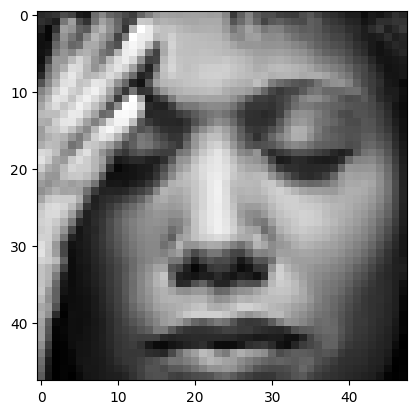

1266.0


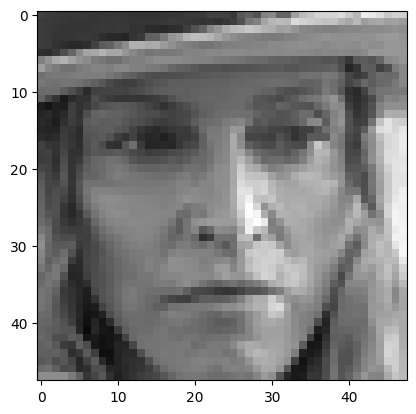

1267.0


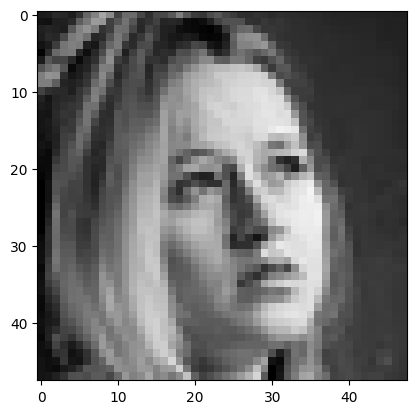

1269.0


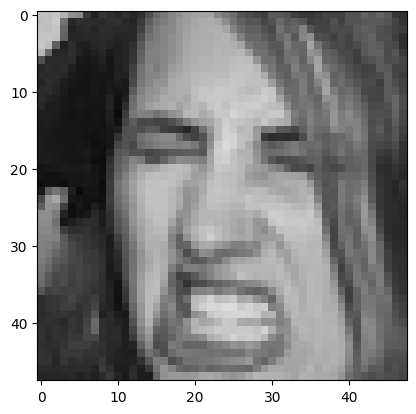

1272.0


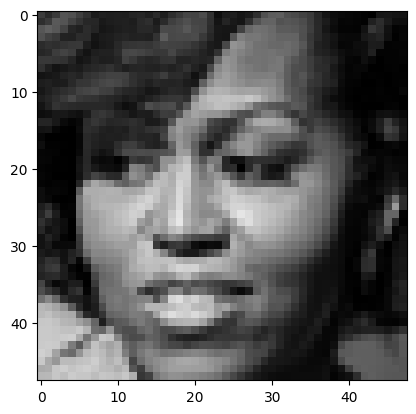

1278.0


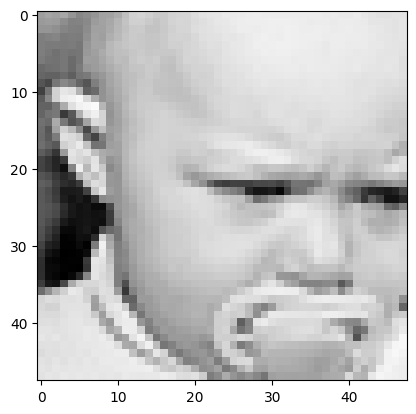

1280.0


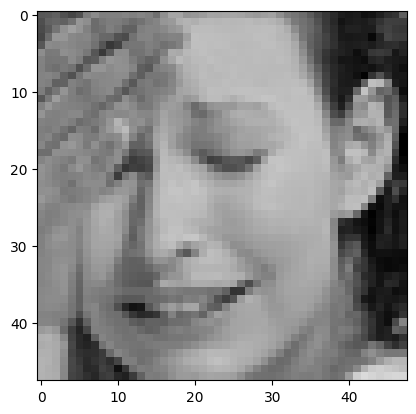

1284.0


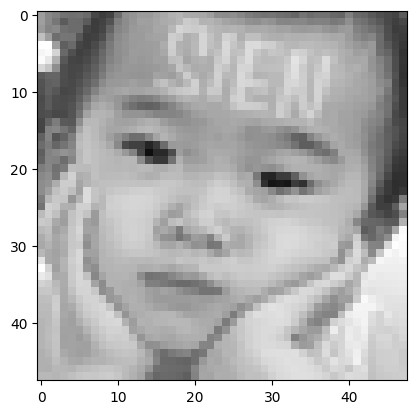

1287.0


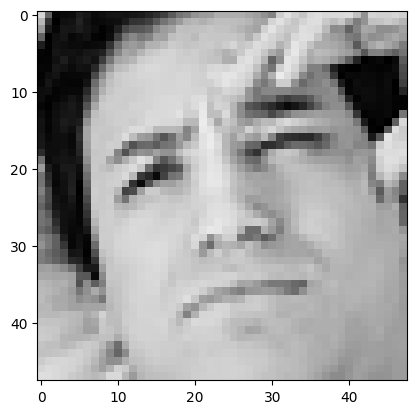

1289.0


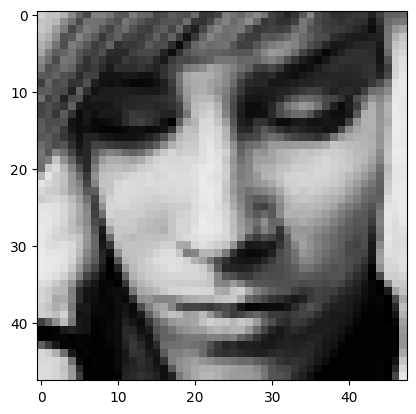

1290.0


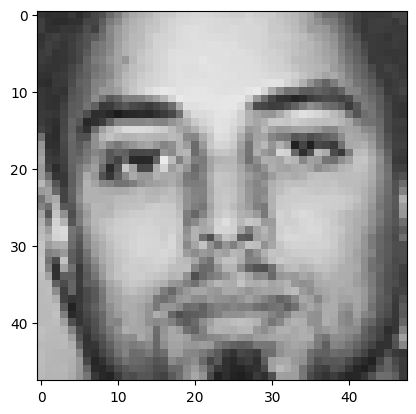

1293.0


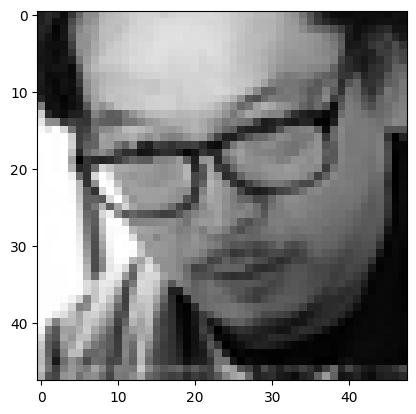

1298.0


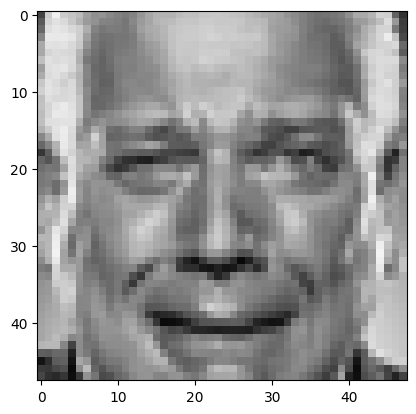

1302.0


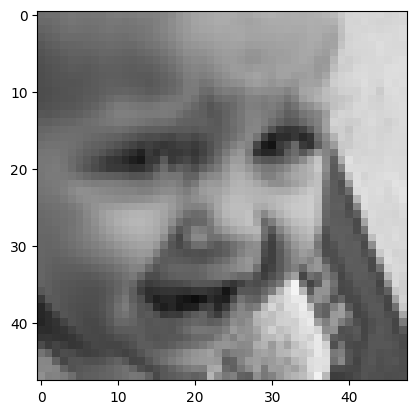

1307.0


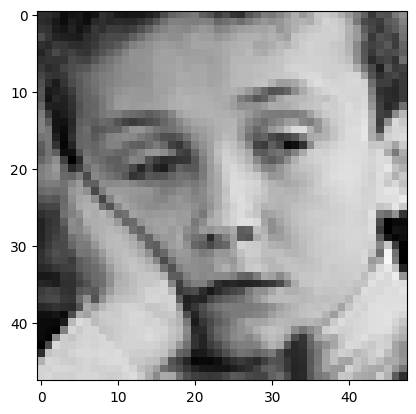

1314.0


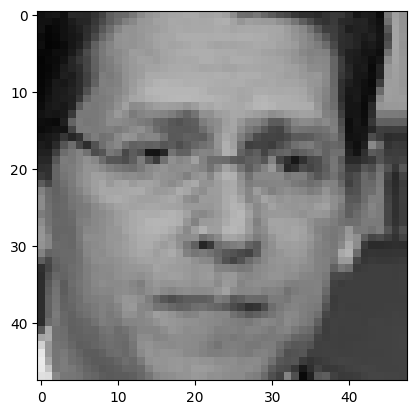

1317.0


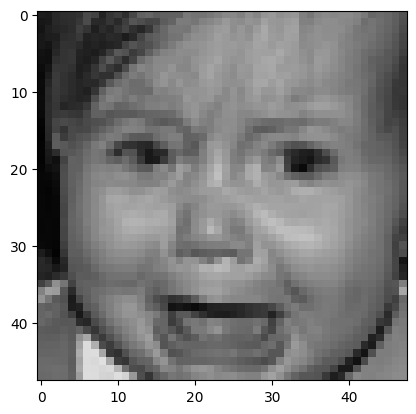

1328.0


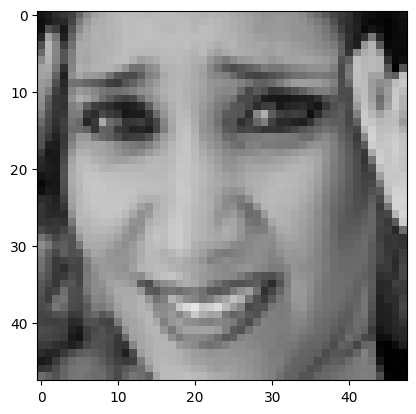

1329.0


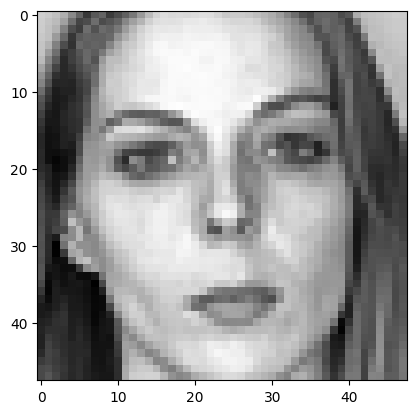

1330.0


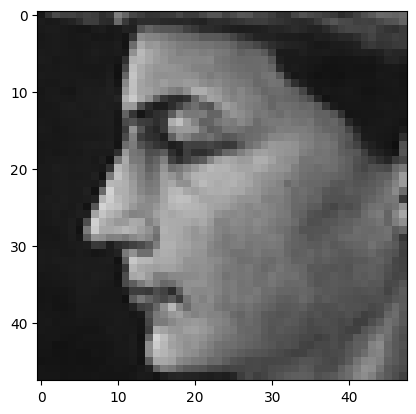

1331.0


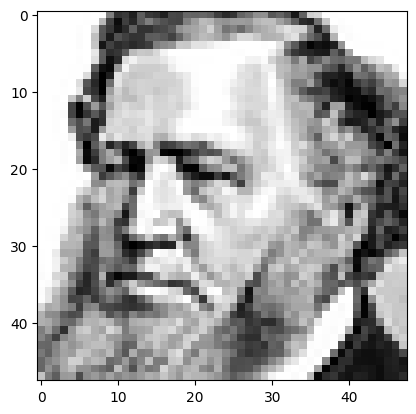

1334.0


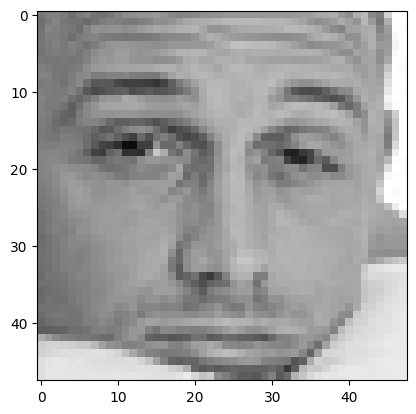

1336.0


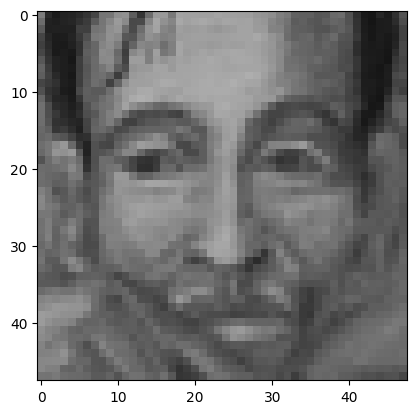

1338.0


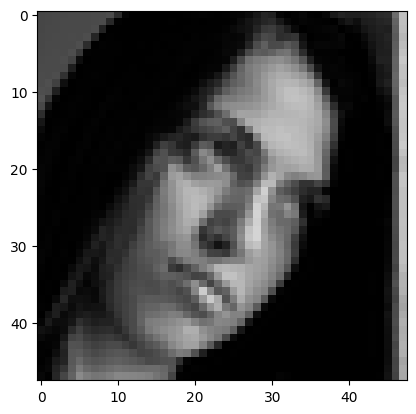

1342.0


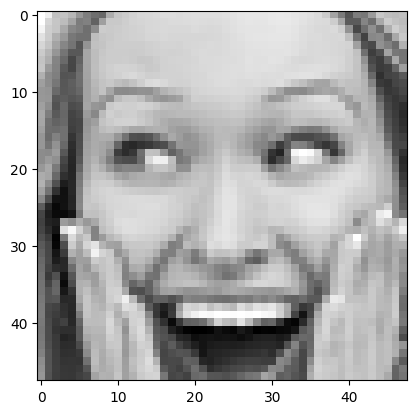

1346.0


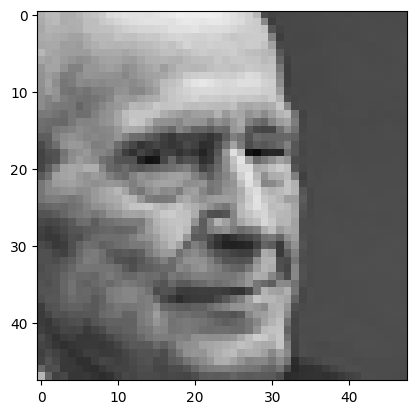

1347.0


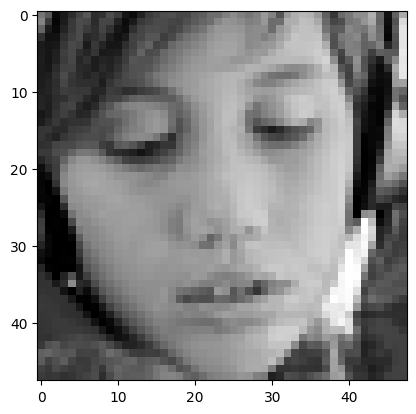

1349.0


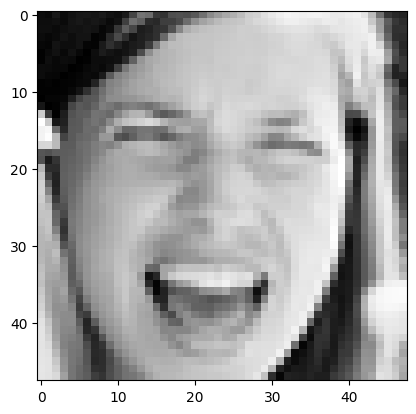

1352.0


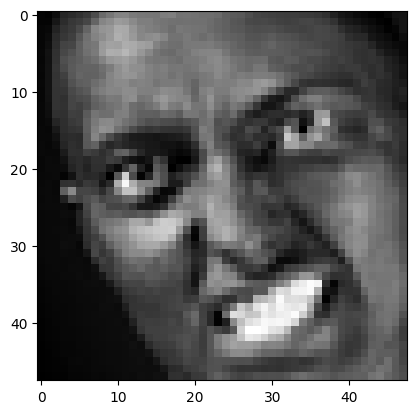

1354.0


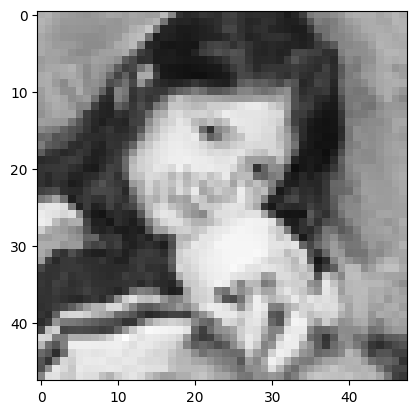

1355.0


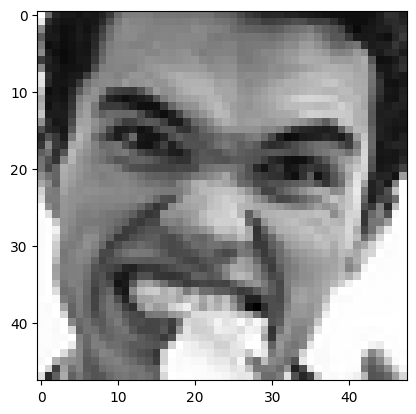

1359.0


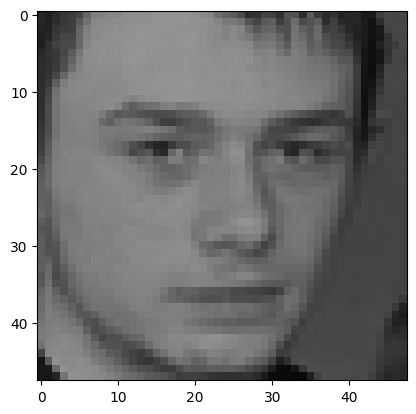

1360.0


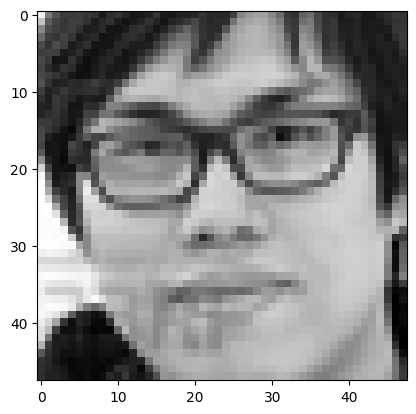

1361.0


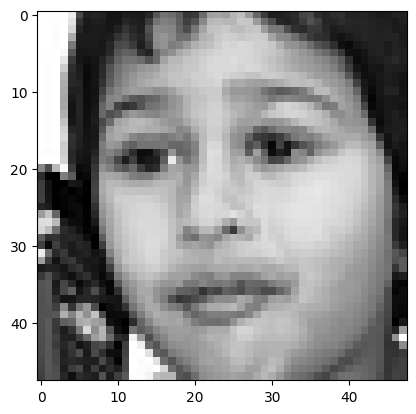

1364.0


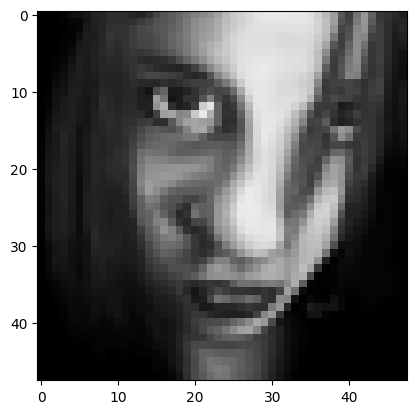

1365.0


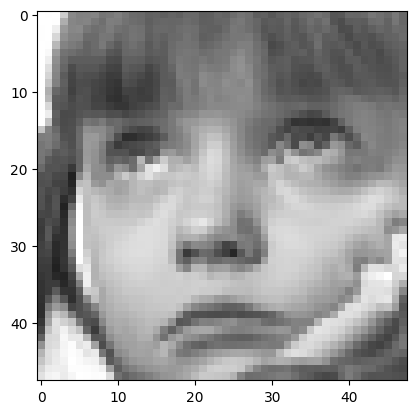

1368.0


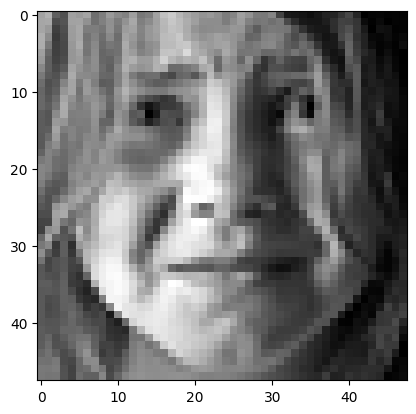

1369.0


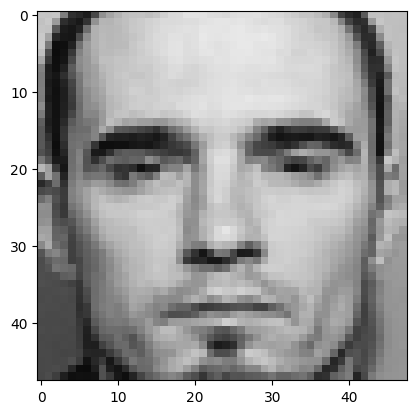

1370.0


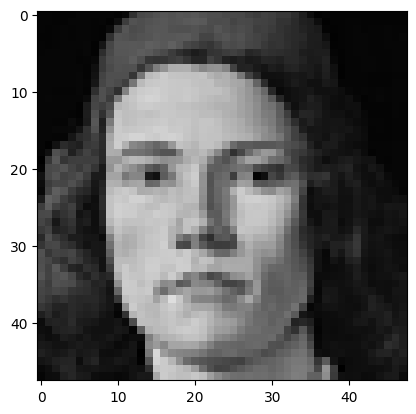

1374.0


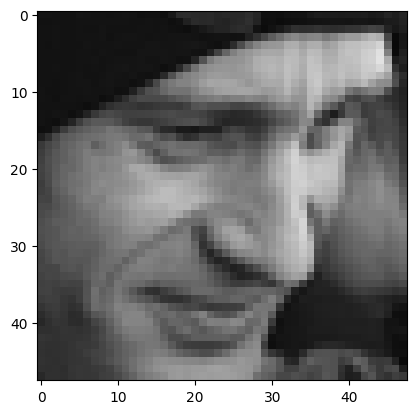

1379.0


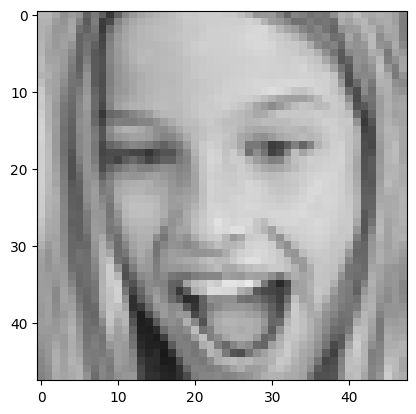

1380.0


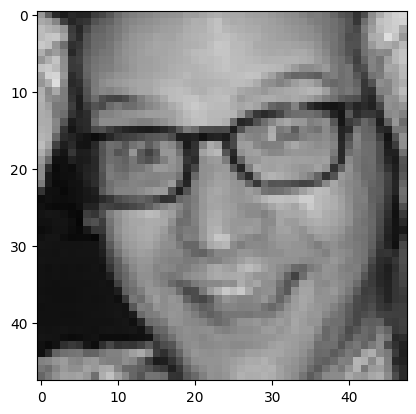

1381.0


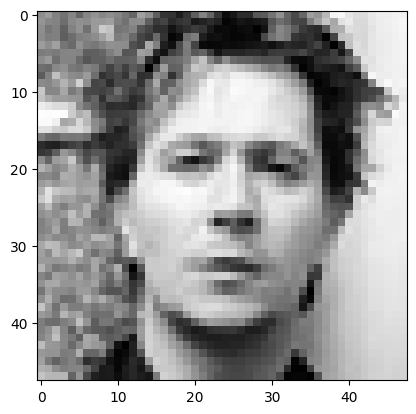

1385.0


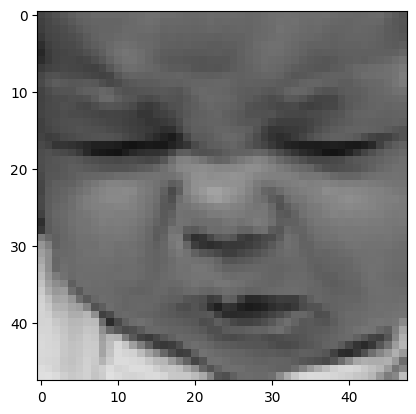

1386.0


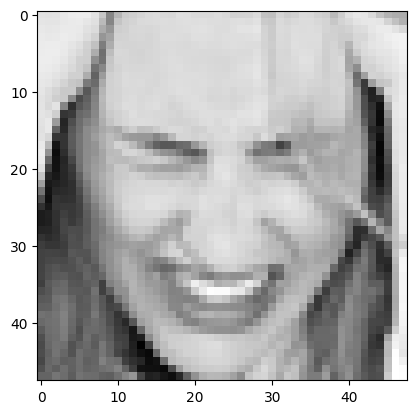

1388.0


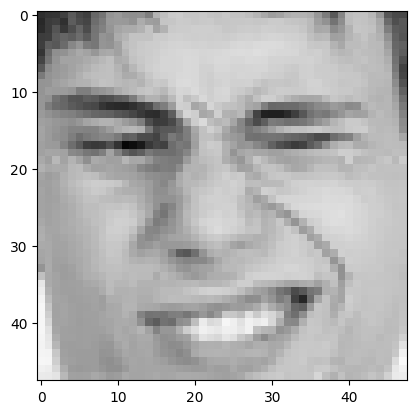

1389.0


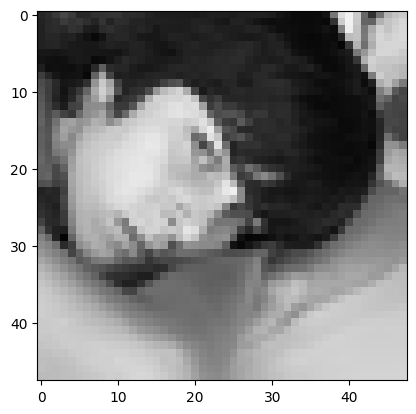

1390.0


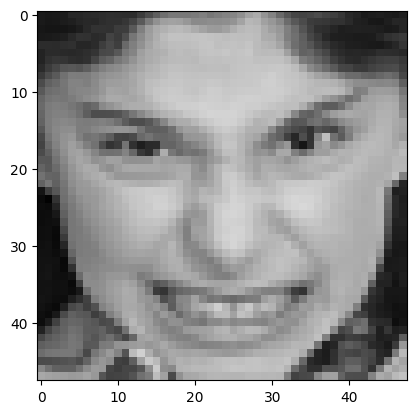

1391.0


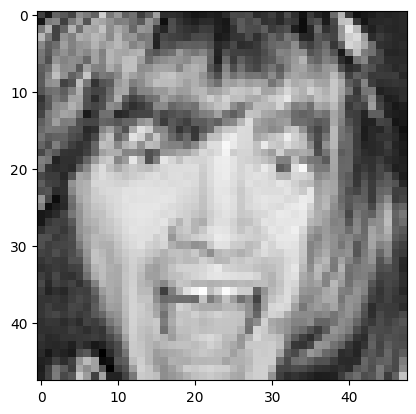

1392.0


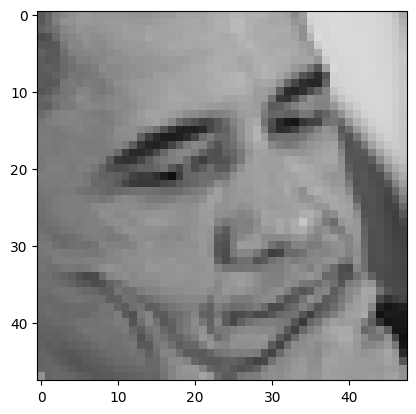

1394.0


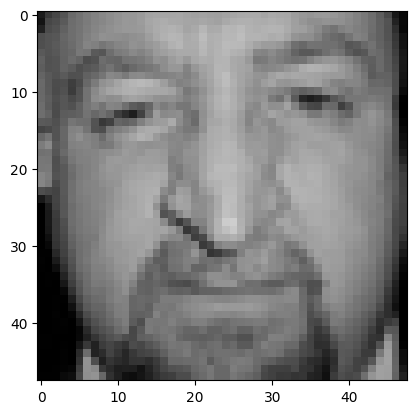

1399.0


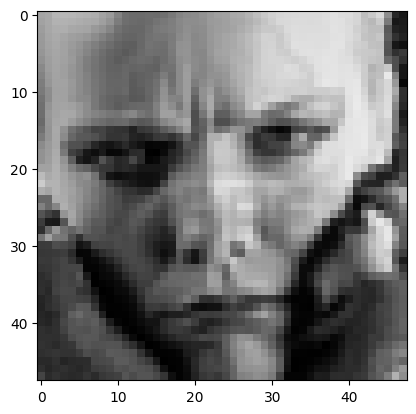

1411.0


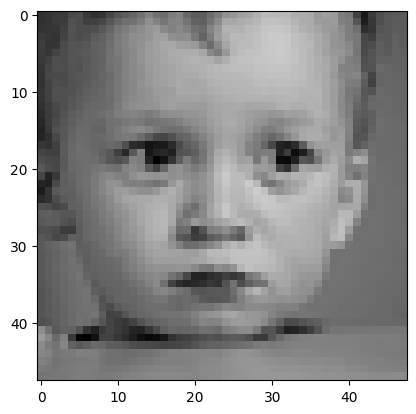

1413.0


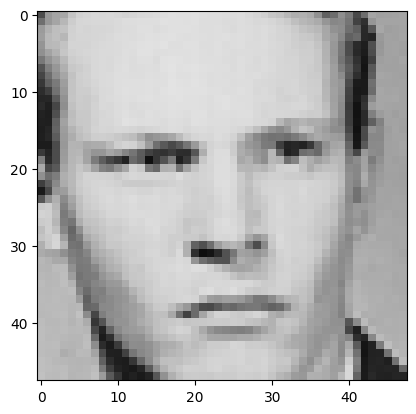

1416.0


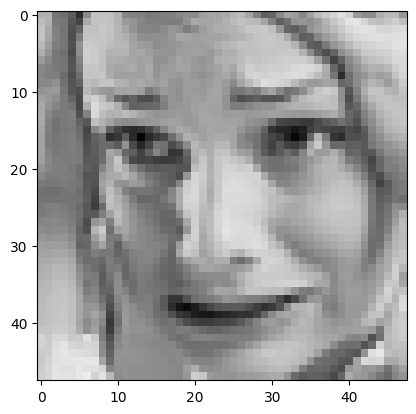

1417.0


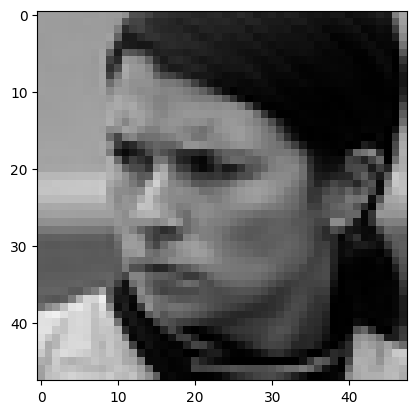

1425.0


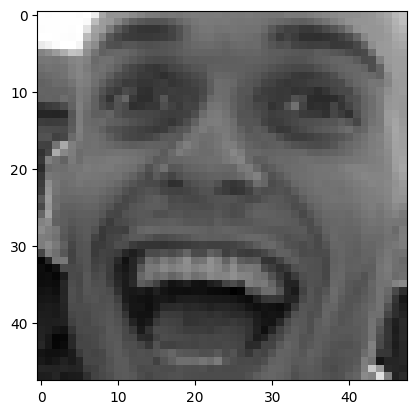

1427.0


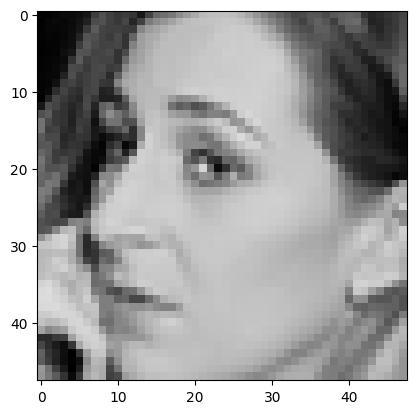

1430.0


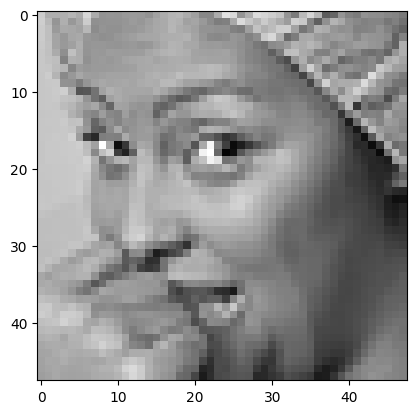

1435.0


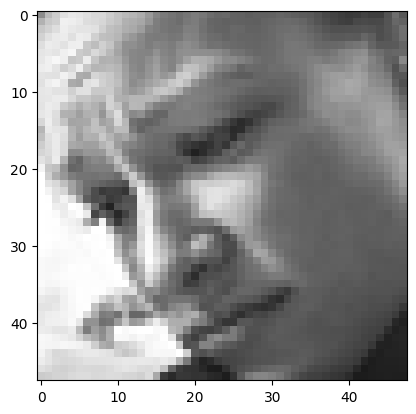

1436.0


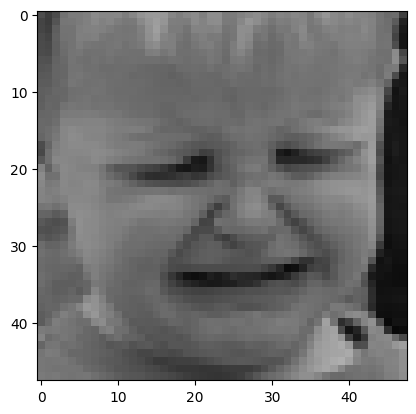

1439.0


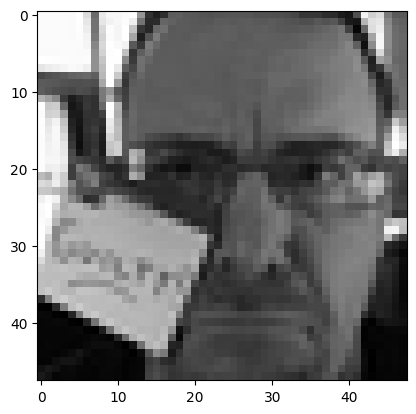

1440.0


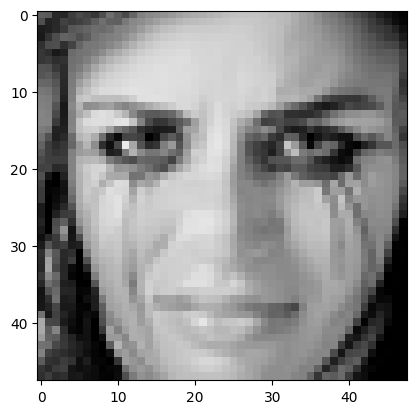

1443.0


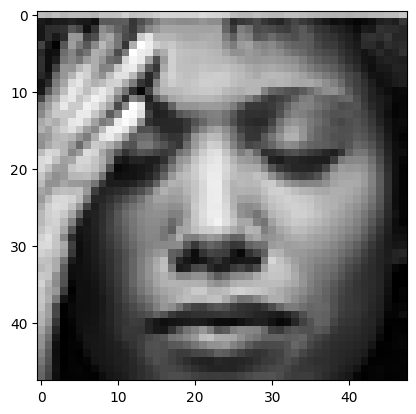

1449.0


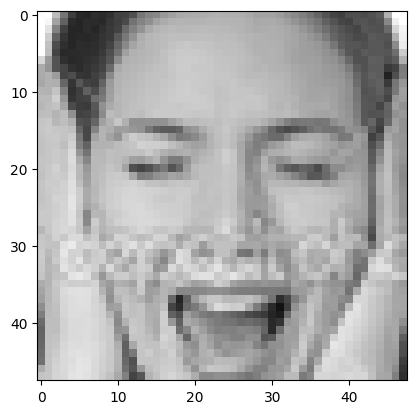

1452.0


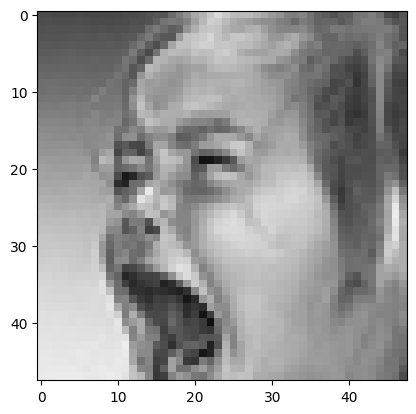

1455.0


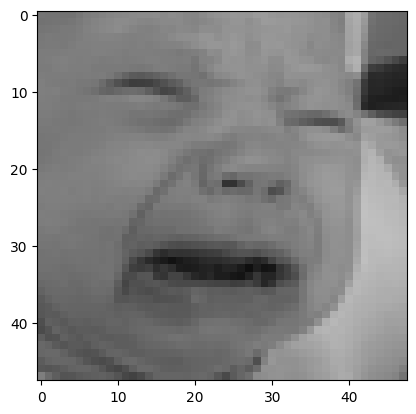

1456.0


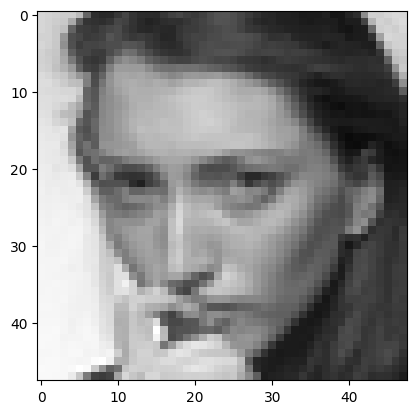

1458.0


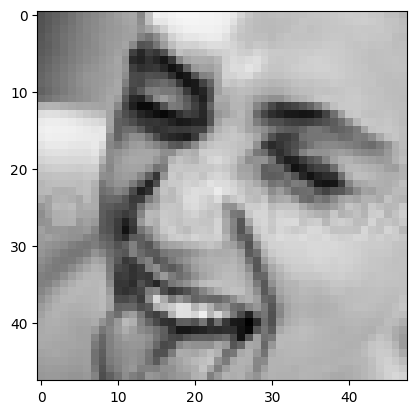

1477.0


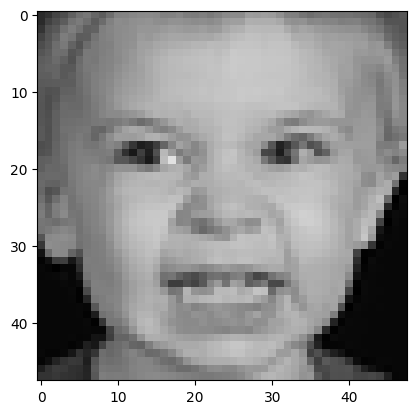

1481.0


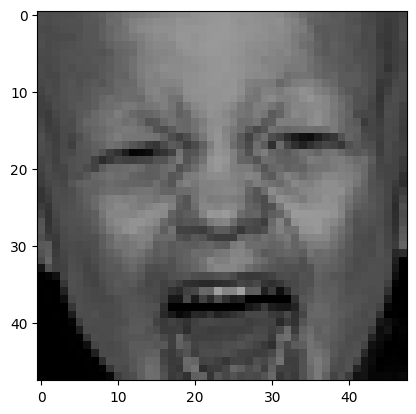

1482.0


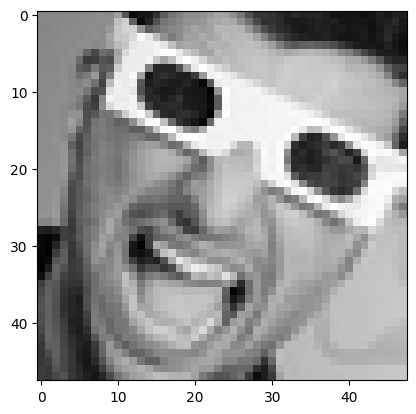

1490.0


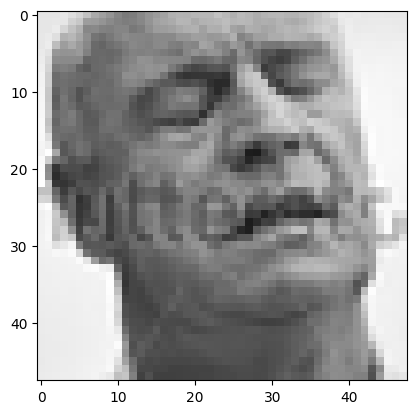

1501.0


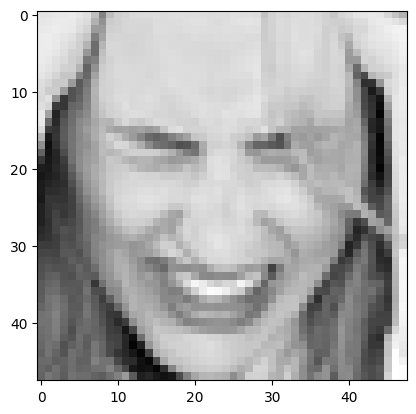

1503.0


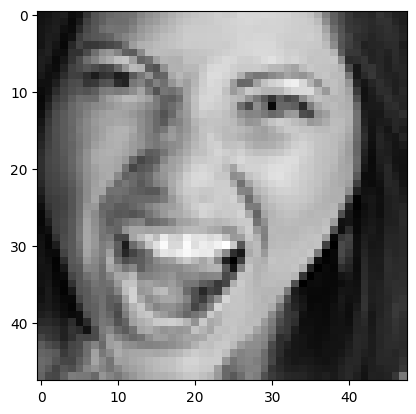

1505.0


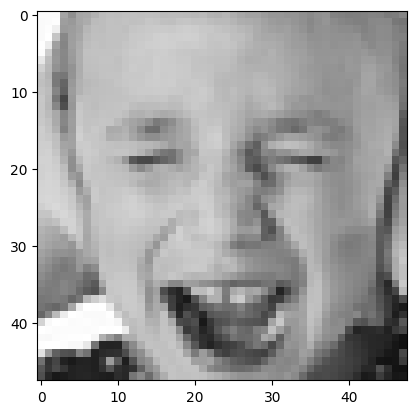

1506.0


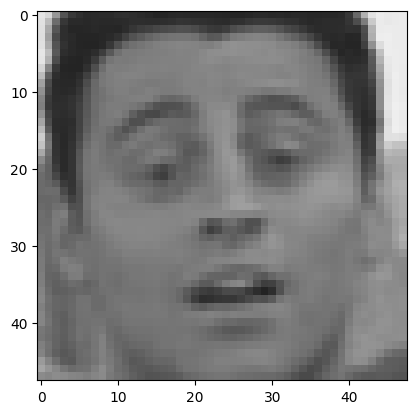

1507.0


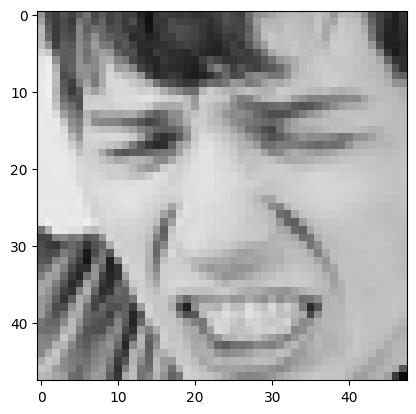

1508.0


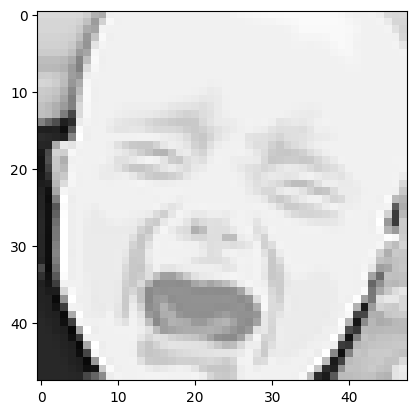

1509.0


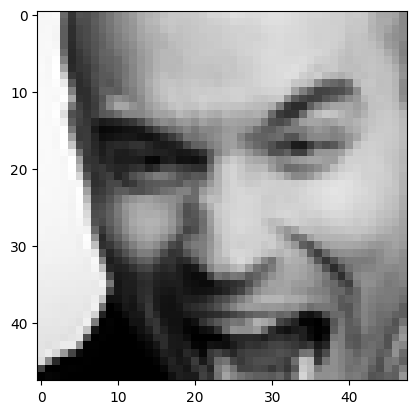

1512.0


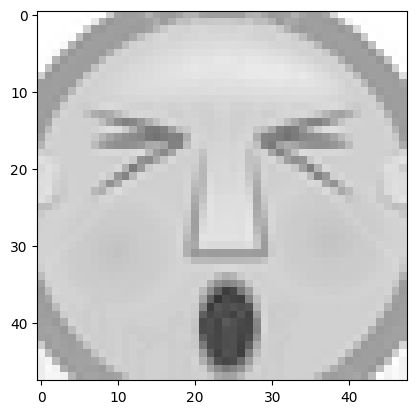

1516.0


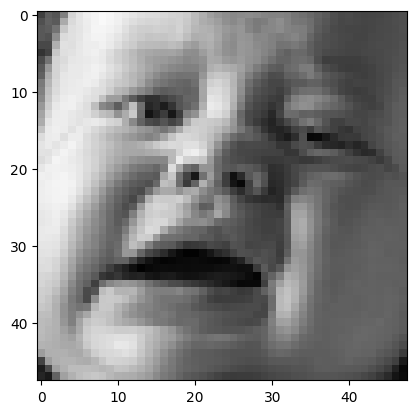

1528.0


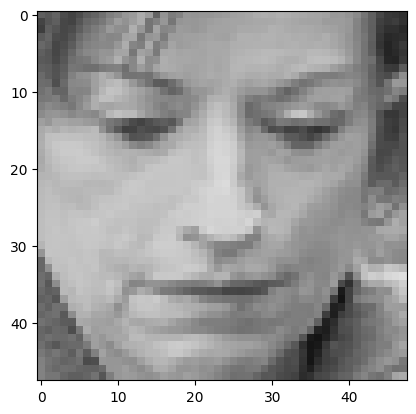

1529.0


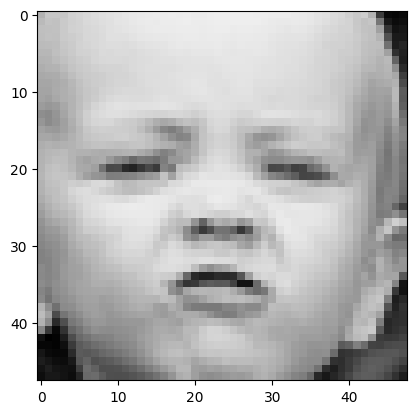

1530.0


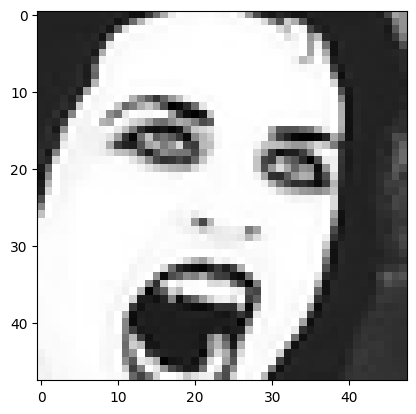

1539.0


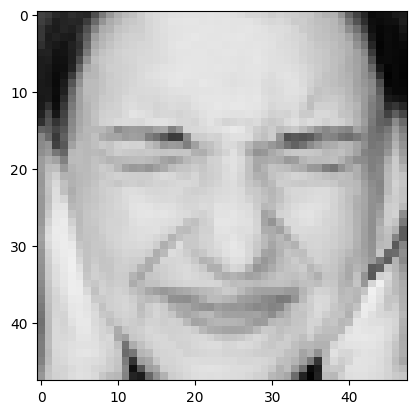

1540.0


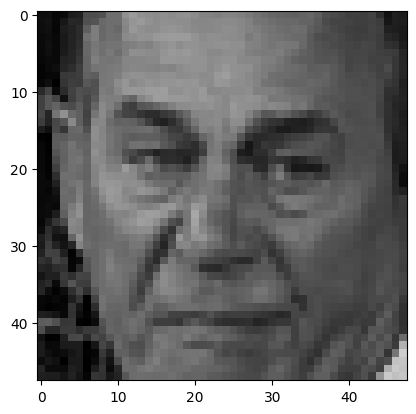

1544.0


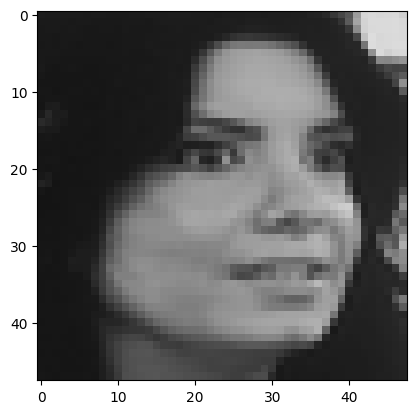

1552.0


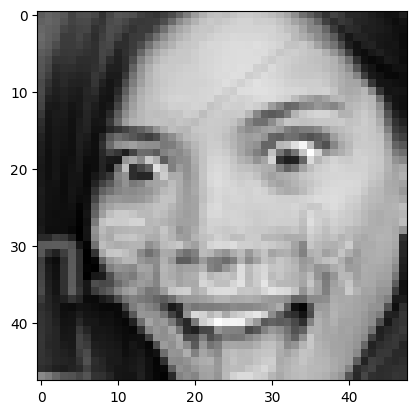

1560.0


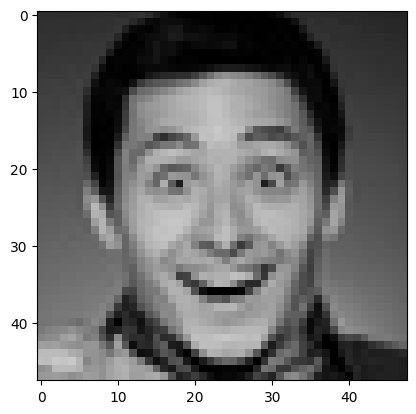

1568.0


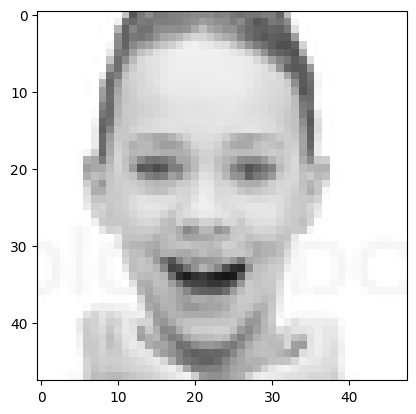

1572.0


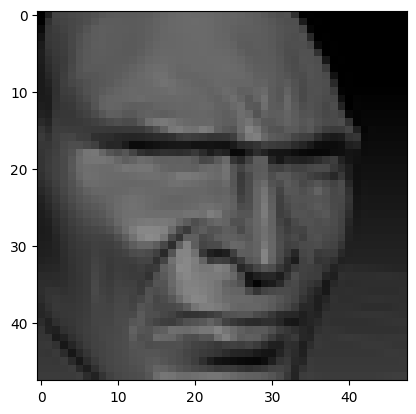

1576.0


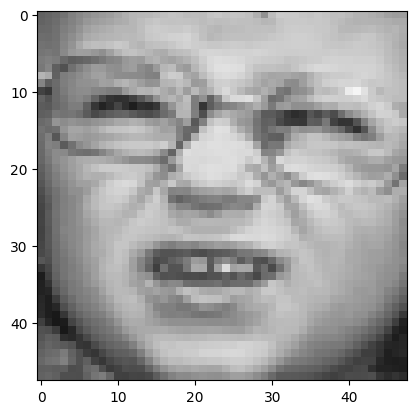

1577.0


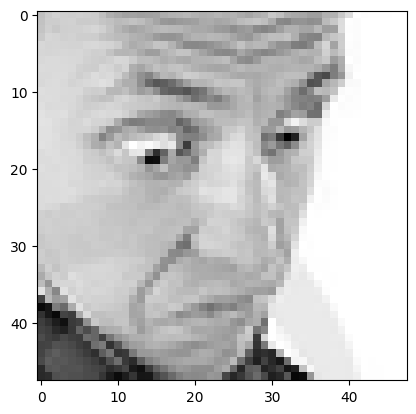

1578.0


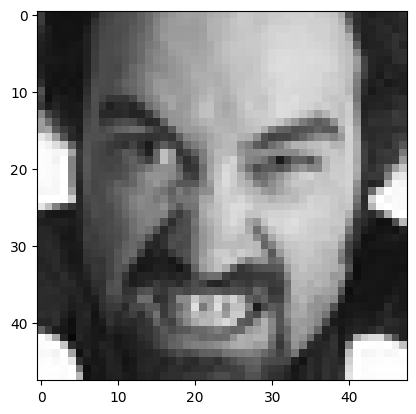

1581.0


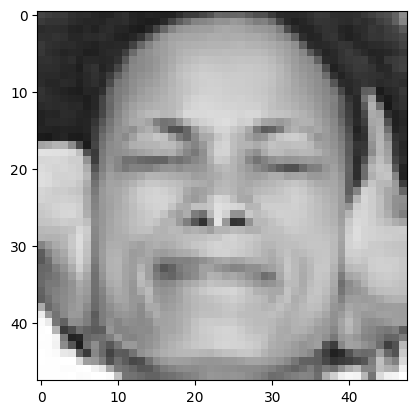

1587.0


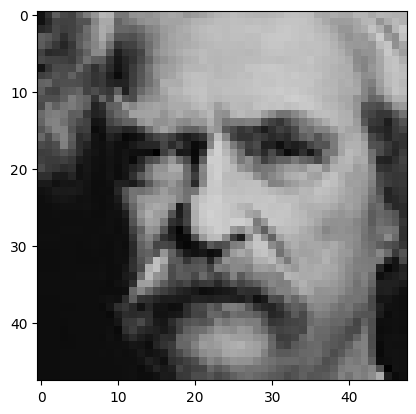

1589.0


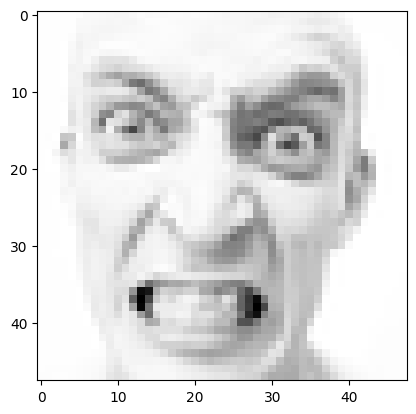

1602.0


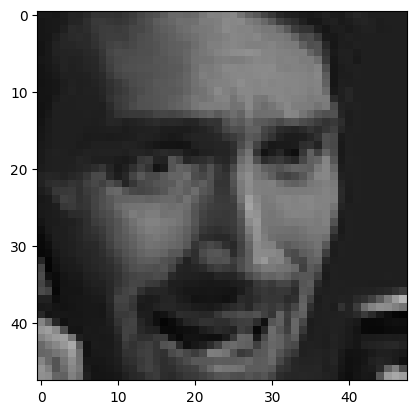

1605.0


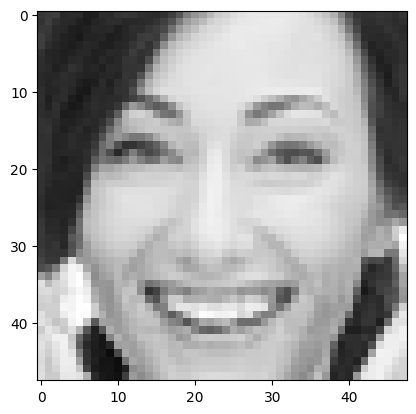

1630.0


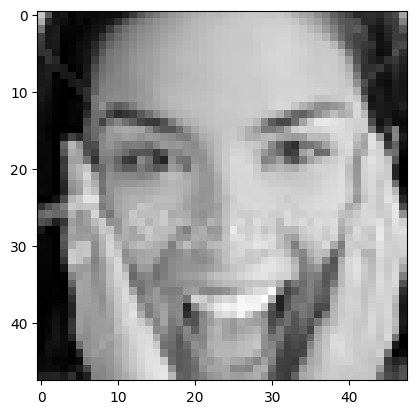

1635.0


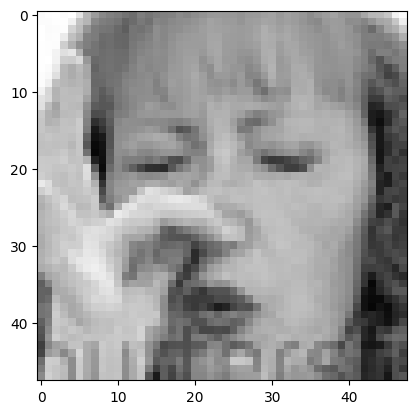

1636.0


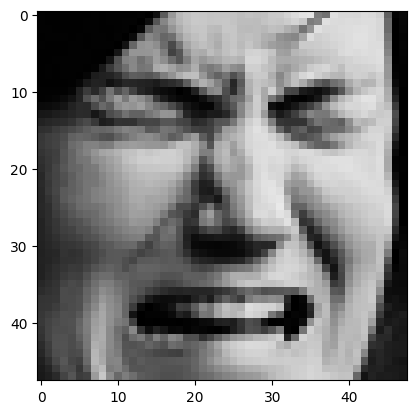

1637.0


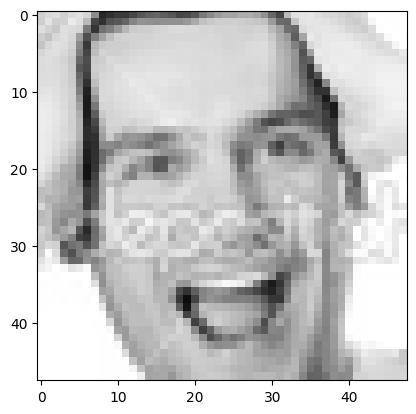

In [34]:
# visualize misclassified images
test_blend_set = []
with open("test_set_full_index.csv", mode= "r") as test_data:
  csvFile = csv.reader(test_data)
  next(csvFile)
  for lines in csvFile:
      test_blend_set.append(lines[0:52])
      # imageee = np.array(str(lines[1]).split(' ')).reshape(48, 48, 1).astype(np.uint8)
      # imageee = cv2.cvtColor(imageee, cv2.COLOR_GRAY2RGB)
      # plt.imshow(imageee)
      # plt.show()
for ind in errors:
      print(ind)
      imageee = np.array(str(test_blend_set[int(float(ind))][1]).split(' ')).reshape(48, 48, 1).astype(np.uint8)
      imageees = cv2.cvtColor(imageee, cv2.COLOR_GRAY2RGB)
      plt.imshow(imageees)
      plt.show()